# **EXP5 Dissociated and Classic Bulks Deconvolution by Adding More Cells**

Data downloaded from GEO Omnibus: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE217517

Cell types per sample from original paper can be accessed here: https://github.com/greenelab/deconvolution_pilot/tree/main/data/cell_labels


**Summary:**
Evaluating the effect of (hypothesized) missing cell-types in the residual of real bulks deconvolved with a missing cell-type reference.

We are using single-cell and bulk matched samples from 8 patients. Each sample has a dissociated sample with ribosomal RNA depletion (-rRNA), non-dissociated sample with ribosomal RNA depletion (-rRNA), and dissociated sample with polyA tail capture (polyA). We are attempting to find evidence in the residual of a missing cell type (adipocyte) only in dissociated samples.

**Hypothesis:**
Dissociation process depletes the single-cell and bulk samples from adipocytes. Thus, only non-dissociated bulks show evidence of adipocytes in the residual. This will be evident by adipocyte-related gene expression in the residual of dissociates bulks compared to non-dissociated bulks.

**Deconv. Method:**
NNLS

**Factorization Methods:**
PCA, NMF

In [1]:
# import the dependencies
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
sys.path.insert(1, '../../../../../')

from functions import sn_sc_preprocess
from functions import validation_processing as vp
from importlib import reload
reload(sn_sc_preprocess)
reload(vp)
# general imports
import warnings
import numpy as np
from numpy import random
from numpy import array
from numpy import diag
from numpy import dot
from numpy import zeros
import pandas as pd
import scanpy as sc
from anndata import AnnData as ad
from tabulate import tabulate

import tensorflow as tf
import sklearn as sk
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import FunctionTransformer
import scipy as sp
from scipy.stats import spearmanr, pearsonr
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
from scipy.stats import wilcoxon
import scipy.stats as stats
from collections import Counter
import scipy as sp
from scipy.optimize import nnls
from scipy.stats import ttest_ind
# Images, plots, display, and visualization
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib.colors as mcolors
import seaborn as sns

import seaborn as sns
from scipy import stats
#sklearns
from sklearn.decomposition import FastICA
from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier

# programming stuff
import time
import os, sys
from io import StringIO 
import pickle
import requests
from pathlib import Path

In [2]:
#####################
### set the study ###
#####################
#results paths:
res_name = "MCT_hgsoc_EXP4"
actual_path = os.getcwd()
data_path = f"{actual_path}/../data/EXP4/"
cibersort_results_path = f"{actual_path}/../data/EXP4/cibersort_results/"
cibersort_path = f"{actual_path}/../data/EXP4/cibersort/"
random_seed = 88
nmf_cut = 'minimum_value'
num_samples = 10000
prop_type = "real"
bulks_type= f"{prop_type}"
use_all_genes = False
add_adipo = False

In [3]:
# Paths:
res_name_adip = f"MCT_adp_EXP3"
pseudo_name_adip = "MCT_adp_EXP3"
files_path_adip= "/../data/EXP3/"
path_results_adip = "/../results/EXP3/"
data_path_adip = "/../data/EXP3/cibersort/"
cibersort_files_adip = (
    "/../data/EXP3/cibersort_results/realisticprop_nonoise_0missing/"
    "CIBERSORTx_MCT_adp_EXP3_realisticprop_nonoise_0missing_signal_inferred_phenoclasses."
    "CIBERSORTx_MCT_adp_EXP3_realisticprop_nonoise_0missing_signal_inferred_refsample.bm.K999.txt")
# parameters into paths
actual_path_adip = os.getcwd()
path_adip = f"{actual_path_adip}{files_path_adip}"
aug_data_path_adip = f"{actual_path_adip}{files_path_adip}"
cibersort_path_adip = f"{actual_path_adip}{cibersort_files_adip}"
path_results_adip = f"{actual_path_adip}{path_results_adip}"
data_path_adip = f"{actual_path_adip}{data_path_adip}"

## **Reading and QCing the data:**

Classic Bulks (Not Dissociated)

In [4]:
bulks_path = os.path.join(data_path, f"{res_name}_bulks.csv")
bulks_path = Path(bulks_path)
bulks = pd.read_csv(bulks_path)
bulks = bulks.drop(labels=["Unnamed: 0"], axis = 1)
#the bulks come in this index:
bulks.index = ['2251', '2267', '2283', '2293', '2380',  '2428', '2467', '2497']
# and we'll reorderby sample type:
bulks  = bulks.reindex(index=['2497', '2467', '2380', '2293', '2283','2428','2251', '2267'])
bulks

MIR1302-2HG  FAM138A  OR4F5  AL627309.1  AL627309.3  AL627309.2  \
2497            7        0      0           6           0           1   
2467            1        0      0          12           0           0   
2380            0        0      0           3           0           0   
2293            0        0      0           2           0           0   
2283            8        0      0           5           0           3   
2428            0        0      0           5           0           1   
2251            2        0      0           6           0           2   
2267            0        0      0           5           0           0   

      AL627309.5  AL627309.4  AP006222.2  AL732372.1  ...  AC136612.1  \
2497          28           0           6           1  ...           0   
2467          77           0          10           0  ...           0   
2380          51           0           7           0  ...           0   
2293          27           0          12           0  ...           0   
2283          59           0           0           0  ...           0   
2428          26           0          10           0  ...           0   
2251          47           0           6           0  ...           0   
2267          81           1           3           0  ...           0   

      AC136616.1  AC136616.3  AC136616.2  AC141272.1  AC023491.2  AC007325.1  \
2497          16           0           0           6           2           4   
2467          81           0           0           0           2           0   
2380           1           0           6           1           0           0   
2293          54           0           0           0           1           0   
2283           3           0           0           0           0           0   
2428           8           0           0           0           0           0   
2251           0           0           2          13           0           0   
2267           7           0           1           3           0           0   

      AC007325.4  AC007325.2   condition  
2497          47          36  rrna_chunk  
2467          18          13  rrna_chunk  
2380          10          23  rrna_chunk  
2293           8           0  rrna_chunk  
2283          18          34  rrna_chunk  
2428          46          24  rrna_chunk  
2251          16           7  rrna_chunk  
2267           2           3  rrna_chunk  

[8 rows x 36602 columns]

Dissociated Bulks:

In [5]:
dbulks_path = os.path.join(data_path, f"{res_name}_dissociated_bulks.csv")
dbulks_path = Path(dbulks_path)
diss_bulks = pd.read_csv(dbulks_path)
diss_bulks = diss_bulks.drop(labels=["Unnamed: 0"], axis=1)
#the bulks come in this index:
diss_bulks.index = ['2251', '2267', '2283', '2293', '2380',  '2428', '2467', '2497']
# and we'll reorderby sample type:
diss_bulks  = diss_bulks.reindex(index=['2497', '2467', '2380', '2293', '2283','2428','2251', '2267'])
diss_bulks

MIR1302-2HG  FAM138A  OR4F5  AL627309.1  AL627309.3  AL627309.2  \
2497            3        0      0           2           0           0   
2467            1        0      0           5           0           0   
2380            4        0      0           2           0           0   
2293            2        0      0           4           0           0   
2283            1        0      0           1           0           0   
2428            3        2      0           1           0           0   
2251            8        0      0           1           0           1   
2267            1        0      0           1           0           0   

      AL627309.5  AL627309.4  AP006222.2  AL732372.1  ...  AC136612.1  \
2497          15           0           1           0  ...           0   
2467          63           1           6           0  ...           0   
2380          37           0           2           0  ...           0   
2293          31           0           3           0  ...           0   
2283          33           0           2           0  ...           0   
2428           7           0           5           0  ...           0   
2251          38           0           0           0  ...           0   
2267          26           0           5           0  ...           0   

      AC136616.1  AC136616.3  AC136616.2  AC141272.1  AC023491.2  AC007325.1  \
2497          19           0           1           1           3           4   
2467          27           0           0           0           0           0   
2380           2           0           0           0           0           0   
2293           6           0           0           6           0           0   
2283           6           0           0           1           0           0   
2428          17           0           0           2           0           0   
2251           4           0           0           4           0           0   
2267          19           0           2          11           0           1   

      AC007325.4  AC007325.2  condition  
2497          39          28  rrna_diss  
2467           8           6  rrna_diss  
2380          10          21  rrna_diss  
2293           6           2  rrna_diss  
2283          20          16  rrna_diss  
2428          57          30  rrna_diss  
2251          10           9  rrna_diss  
2267          15           3  rrna_diss  

[8 rows x 36602 columns]

Dissociated polyA:

In [6]:
disspolyA_bulks_path = os.path.join(data_path, f"{res_name}_dissociatedpolyA_bulks.csv")
disspolyA_bulks_path = Path(disspolyA_bulks_path)
disspolya_bulks = pd.read_csv(disspolyA_bulks_path)
disspolya_bulks = disspolya_bulks.drop(labels=["Unnamed: 0"], axis = 1)
#the bulks come in this index:
disspolya_bulks.index = ['2251', '2267', '2283', '2293', '2380',  '2428', '2467', '2497']
# and we'll reorderby sample type:
disspolya_bulks  = disspolya_bulks.reindex(index=['2497', '2467', '2380', '2293', '2283','2428','2251', '2267'])
disspolya_bulks

MIR1302-2HG  FAM138A  OR4F5  AL627309.1  AL627309.3  AL627309.2  \
2497           17        2      0          10           0           2   
2467            2        1      0           7           0           3   
2380            5        1      0           6           0           0   
2293            4        0      0          13           0           4   
2283            7        0      0          11           0           9   
2428            0        0      0           1           0           0   
2251            2        0      0           6           0           1   
2267            0        0      0           5           0           1   

      AL627309.5  AL627309.4  AP006222.2  AL732372.1  ...  AC136612.1  \
2497          66           0          15           1  ...           1   
2467         134           0           8           0  ...           4   
2380         159           0          16           0  ...           0   
2293          92           0           5           0  ...           0   
2283         114           0          12           0  ...           0   
2428          14           0          10           0  ...           0   
2251          93           0           9           1  ...           0   
2267          69           0          12           0  ...           1   

      AC136616.1  AC136616.3  AC136616.2  AC141272.1  AC023491.2  AC007325.1  \
2497          35           0           0           9           9           7   
2467          58           0           1           2           0           0   
2380           2           0           2           6           0           0   
2293          16           0           0           1           0           0   
2283           9           0           0           1           0           0   
2428          35           0           0           6           0           0   
2251           6           0           2          16           0           0   
2267          33           0           4          30           0           0   

      AC007325.4  AC007325.2   condition  
2497          56          78  polyA_diss  
2467          15          11  polyA_diss  
2380          27          32  polyA_diss  
2293           4           6  polyA_diss  
2283          10          17  polyA_diss  
2428          51          27  polyA_diss  
2251          10          12  polyA_diss  
2267           6           3  polyA_diss  

[8 rows x 36602 columns]

And all single-cells:

In [7]:
#saved as anndata objects
adata_path = os.path.join(data_path, f"{res_name}_adata1_notlog.h5ad")
adata_path = Path(adata_path)
adata_1 = sc.read_h5ad(adata_path)

adata_path = os.path.join(data_path, f"{res_name}_adata2_notlog.h5ad")
adata_path = Path(adata_path)
adata_2 = sc.read_h5ad(adata_path)

adata_path = os.path.join(data_path, f"{res_name}_adata3_notlog.h5ad")
adata_path = Path(adata_path)
adata_3 = sc.read_h5ad(adata_path)

adata_path = os.path.join(data_path, f"{res_name}_adata4_notlog.h5ad")
adata_path = Path(adata_path)
adata_4 = sc.read_h5ad(adata_path)

adata_path = os.path.join(data_path, f"{res_name}_adata5_notlog.h5ad")
adata_path = Path(adata_path)
adata_5 = sc.read_h5ad(adata_path)

adata_path = os.path.join(data_path, f"{res_name}_adata6_notlog.h5ad")
adata_path = Path(adata_path)
adata_6 = sc.read_h5ad(adata_path)

adata_path = os.path.join(data_path, f"{res_name}_adata7_notlog.h5ad")
adata_path = Path(adata_path)
adata_7 = sc.read_h5ad(adata_path)

adata_path = os.path.join(data_path, f"{res_name}_adata8_notlog.h5ad")
adata_path = Path(adata_path)
adata_8 = sc.read_h5ad(adata_path)

In [8]:
#attaching adatas (single-cells) into dict
adatas=dict()
adatas[1] = adata_1
adatas[2] = adata_2
adatas[3] = adata_3
adatas[4] = adata_4
adatas[5] = adata_5
adatas[6] = adata_6
adatas[7] = adata_7
adatas[8] = adata_8
#QC
for adata in adatas.items():
    print(adata[1])

AnnData object with n_obs × n_vars = 3102 × 28313
    obs: 'cell_types', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
AnnData object with n_obs × n_vars = 1039 × 28578
    obs: 'cell_types', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
AnnData object with n_obs × n_vars = 1088 × 28704
    obs: 'cell_types', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
AnnData object with n_obs × n_vars = 4329 × 24272
    obs: 'cell_types', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt',

In [9]:
#Our ground truth in this case is single cell! But'll we'll merge them to get more cells.
prop_df = dict()
for num in adatas:
    prop_df[num], adatas[num] = vp.get_prop(adatas[num])
for  adata in adatas:
    print(Counter(adatas[adata].obs["cell_types"]))
    print(" ")    

                   Num_Cells  Prop_Cells
Cell_Types                              
B cells                   62    0.019987
DC                        13    0.004191
Endothelial cells        503    0.162153
Epithelial cells          56    0.018053
Fibroblasts              206    0.066409
ILC                       24    0.007737
Macrophages              123    0.039652
Monocytes                 54    0.017408
NK cells                 114    0.036750
Plasma cells            1432    0.461638
T cells                  506    0.163121
pDC                        9    0.002901
                   Num_Cells  Prop_Cells
Cell_Types                              
B cells                   41    0.039461
DC                         6    0.005775
Endothelial cells         18    0.017324
Epithelial cells          99    0.095284
Fibroblasts               13    0.012512
Macrophages               26    0.025024
Monocytes                 17    0.016362
NK cells                  67    0.064485
Plasma cells    

Making genes the same in all single-cell datas, and merging.

In [10]:
# Extract the values (Anndata objects) from the dictionary
adatas_list = list(adatas.values())

# Concatenate the Anndata objects into a single object
merged_adata = sc.concat(adatas_list, join='inner')
merged_adata.var['gene_ids'] = merged_adata.var_names
merged_adata

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


AnnData object with n_obs × n_vars = 17438 × 13724
    obs: 'cell_types', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids'

## Adding Adipocyte and Medothelial Cells to Reference (if set)

In [11]:
#Reading in the CIBERSORTx barcode genes
cibersort_ref = dict()
cibersort_genes = dict()
print("genes to keep per experiment:")
#name is long so we're cutting it
cut_str1 = "missing_signal_inferred_phenoclasses.CIBERSORTx_"
cut_str2 = "missing_signal_inferred_refsample.bm.K999.txt"
for num in adatas:    
    # read in cibersort genes from cibersort reference
    cibersort_path_ = os.path.join(cibersort_results_path, 
        f"CIBERSORTx_{res_name}_{bulks_type}_{num}{cut_str1}{res_name}_{bulks_type}_{num}{cut_str2}")
    cibersort_path_ = Path(cibersort_path_)
    cibersort_df = pd.read_csv(cibersort_path_, sep="\t")
    cibersort_genes[num] = pd.DataFrame(columns = cibersort_df["NAME"].values.tolist())
    cibersort_df.index = cibersort_genes[num].columns
    cibersort_ref[num] = cibersort_df.drop(columns = "NAME", inplace=False)
cibersort_genes = cibersort_genes[1].columns
cibersort_genes = cibersort_genes.tolist()
cibersort_genes

genes to keep per experiment:


['A1BG',
 'A2M',
 'AAGAB',
 'AASS',
 'AATK',
 'ABCA1',
 'ABCA10',
 'ABCA5',
 'ABCA6',
 'ABCA9',
 'ABCB1',
 'ABCC4',
 'ABCC9',
 'ABCE1',
 'ABHD12',
 'ABHD15',
 'ABHD15.AS1',
 'ABHD17A',
 'ABHD17C',
 'ABHD2',
 'ABHD3',
 'ABI2',
 'ABI3BP',
 'ABL2',
 'ABLIM1',
 'ABR',
 'ABRACL',
 'ABTB2',
 'AC002091.1',
 'AC002429.2',
 'AC004687.1',
 'AC004817.3',
 'AC004854.2',
 'AC005037.1',
 'AC005261.1',
 'AC005264.1',
 'AC005480.1',
 'AC005920.2',
 'AC006064.2',
 'AC006449.6',
 'AC007032.1',
 'AC007365.1',
 'AC007381.1',
 'AC007384.1',
 'AC007569.1',
 'AC007991.3',
 'AC008014.1',
 'AC008105.3',
 'AC008569.1',
 'AC008691.1',
 'AC008696.2',
 'AC008760.2',
 'AC008764.7',
 'AC008764.8',
 'AC009313.1',
 'AC010609.1',
 'AC010883.3',
 'AC010894.3',
 'AC011462.5',
 'AC011476.3',
 'AC011511.2',
 'AC012184.4',
 'AC012368.1',
 'AC012447.1',
 'AC013652.1',
 'AC015871.7',
 'AC015912.3',
 'AC016831.1',
 'AC017101.1',
 'AC017104.1',
 'AC018682.1',
 'AC018755.4',
 'AC018816.1',
 'AC020656.1',
 'AC021180.1',
 'AC02159

In [12]:
cibersort_df = pd.read_csv(cibersort_path_adip, sep="\t")
cibersort_genes_adip = cibersort_df["NAME"].values

cibersort_genes = np.unique(np.concatenate((cibersort_genes,cibersort_genes_adip)))
cibersort_genes.shape

(6037,)

In [13]:
#and as anndata object single nucleus 
adata_path_adip = os.path.join(path_adip, f"MCT_adp_EXP3_snadata_notlog.h5ad")
adata_path_adip = Path(adata_path_adip)
sn_adata = sc.read_h5ad(adata_path_adip)
cells_to_keep = ["Fat cell", "fat cell"]
sn_adata = sn_adata[sn_adata.obs.cell_types.isin(cells_to_keep)]
sn_adata.obs.cell_types.value_counts()

Fat cell    24825
Name: cell_types, dtype: int64

In [14]:
genes_adatas = np.intersect1d(merged_adata.var["gene_ids"].values, sn_adata.var["gene_ids"].values)
merged_adata = merged_adata[:, genes_adatas]
sn_adata = sn_adata[:, genes_adatas]
merged_adata = sc.concat([sn_adata, merged_adata])
merged_adata.obs_names_make_unique()
print(merged_adata.obs.cell_types.value_counts())

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Fat cell             24825
T cells               7419
Plasma cells          1983
Epithelial cells      1694
Fibroblasts           1587
Endothelial cells     1189
Macrophages           1116
NK cells               842
Unknown1               512
Monocytes              272
B cells                264
pDC                    170
Unknown2               155
DC                      98
ILC                     89
Mast cells              27
Erythroid               21
Name: cell_types, dtype: int64


In [15]:
if add_adipo:
    print("Keeping all cells")
    print(merged_adata.obs.cell_types.value_counts())
else:
    print("Removing adipocytes")
    merged_adata = merged_adata[merged_adata.obs.cell_types != "Fat cell"]
    print(merged_adata.obs.cell_types.value_counts())

Removing adipocytes
T cells              7419
Plasma cells         1983
Epithelial cells     1694
Fibroblasts          1587
Endothelial cells    1189
Macrophages          1116
NK cells              842
Unknown1              512
Monocytes             272
B cells               264
pDC                   170
Unknown2              155
DC                     98
ILC                    89
Mast cells             27
Erythroid              21
Name: cell_types, dtype: int64


And final formatting on the bulks:

In [16]:
#combining the dissociated and non dissociated
combo = pd.DataFrame(np.concatenate([bulks.values, diss_bulks.values]), 
index = range(1,17), columns = bulks.columns)

In [17]:
#making sure index matches:
sample_ids = ['2497', '2467', '2380', '2293', '2283','2428','2251', '2267']
bulks.index = sample_ids
diss_bulks.index = sample_ids
disspolya_bulks.index = sample_ids
combo.index = sample_ids * 2
bulks

MIR1302-2HG  FAM138A  OR4F5  AL627309.1  AL627309.3  AL627309.2  \
2497            7        0      0           6           0           1   
2467            1        0      0          12           0           0   
2380            0        0      0           3           0           0   
2293            0        0      0           2           0           0   
2283            8        0      0           5           0           3   
2428            0        0      0           5           0           1   
2251            2        0      0           6           0           2   
2267            0        0      0           5           0           0   

      AL627309.5  AL627309.4  AP006222.2  AL732372.1  ...  AC136612.1  \
2497          28           0           6           1  ...           0   
2467          77           0          10           0  ...           0   
2380          51           0           7           0  ...           0   
2293          27           0          12           0  ...           0   
2283          59           0           0           0  ...           0   
2428          26           0          10           0  ...           0   
2251          47           0           6           0  ...           0   
2267          81           1           3           0  ...           0   

      AC136616.1  AC136616.3  AC136616.2  AC141272.1  AC023491.2  AC007325.1  \
2497          16           0           0           6           2           4   
2467          81           0           0           0           2           0   
2380           1           0           6           1           0           0   
2293          54           0           0           0           1           0   
2283           3           0           0           0           0           0   
2428           8           0           0           0           0           0   
2251           0           0           2          13           0           0   
2267           7           0           1           3           0           0   

      AC007325.4  AC007325.2   condition  
2497          47          36  rrna_chunk  
2467          18          13  rrna_chunk  
2380          10          23  rrna_chunk  
2293           8           0  rrna_chunk  
2283          18          34  rrna_chunk  
2428          46          24  rrna_chunk  
2251          16           7  rrna_chunk  
2267           2           3  rrna_chunk  

[8 rows x 36602 columns]

Assigning genes: 

In [18]:
#Reading in the CIBERSORTx barcode genes
cibersort_ref = dict()
cibersort_genes = dict()
print("genes to keep per experiment:")
#name is long so we're cutting it
cut_str1 = "missing_signal_inferred_phenoclasses.CIBERSORTx_"
cut_str2 = "missing_signal_inferred_refsample.bm.K999.txt"
for num in adatas:    
    # read in cibersort genes from cibersort reference
    cibersort_path_ = os.path.join(cibersort_results_path, 
        f"CIBERSORTx_{res_name}_{bulks_type}_{num}{cut_str1}{res_name}_{bulks_type}_{num}{cut_str2}")
    cibersort_path_ = Path(cibersort_path_)
    cibersort_df = pd.read_csv(cibersort_path_, sep="\t")
    cibersort_genes[num] = pd.DataFrame(columns = cibersort_df["NAME"].values.tolist())
    cibersort_df.index = cibersort_genes[num].columns
    cibersort_ref[num] = cibersort_df.drop(columns = "NAME", inplace=False)
cibersort_genes = cibersort_genes[1].columns
cibersort_genes = cibersort_genes.tolist()
cibersort_genes

genes to keep per experiment:


['A1BG',
 'A2M',
 'AAGAB',
 'AASS',
 'AATK',
 'ABCA1',
 'ABCA10',
 'ABCA5',
 'ABCA6',
 'ABCA9',
 'ABCB1',
 'ABCC4',
 'ABCC9',
 'ABCE1',
 'ABHD12',
 'ABHD15',
 'ABHD15.AS1',
 'ABHD17A',
 'ABHD17C',
 'ABHD2',
 'ABHD3',
 'ABI2',
 'ABI3BP',
 'ABL2',
 'ABLIM1',
 'ABR',
 'ABRACL',
 'ABTB2',
 'AC002091.1',
 'AC002429.2',
 'AC004687.1',
 'AC004817.3',
 'AC004854.2',
 'AC005037.1',
 'AC005261.1',
 'AC005264.1',
 'AC005480.1',
 'AC005920.2',
 'AC006064.2',
 'AC006449.6',
 'AC007032.1',
 'AC007365.1',
 'AC007381.1',
 'AC007384.1',
 'AC007569.1',
 'AC007991.3',
 'AC008014.1',
 'AC008105.3',
 'AC008569.1',
 'AC008691.1',
 'AC008696.2',
 'AC008760.2',
 'AC008764.7',
 'AC008764.8',
 'AC009313.1',
 'AC010609.1',
 'AC010883.3',
 'AC010894.3',
 'AC011462.5',
 'AC011476.3',
 'AC011511.2',
 'AC012184.4',
 'AC012368.1',
 'AC012447.1',
 'AC013652.1',
 'AC015871.7',
 'AC015912.3',
 'AC016831.1',
 'AC017101.1',
 'AC017104.1',
 'AC018682.1',
 'AC018755.4',
 'AC018816.1',
 'AC020656.1',
 'AC021180.1',
 'AC02159

Now the other cibersort genes for adipocytes and dissociation markers:

In [19]:
cibersort_df = pd.read_csv(cibersort_path_adip, sep="\t")
cibersort_genes_adip = cibersort_df["NAME"].values
cibersort_genes = np.unique(np.concatenate((cibersort_genes,cibersort_genes_adip)))
cibersort_genes.shape

(6037,)

Defining gene markers:

In [20]:
#From deconv paper: https://genomebiology.biomedcentral.com/articles/10.1186/s13059-023-03077-7
#Erythocyte markers
eryth_markers = ['ALAS2','HBB', 'HBA2','HBA1']
#Dissociation Response
diss_response = ['PYDC1', 'PRRR35', 'AGXT', 'EREG', 'CSF3', 'ASTL'
    'HSPC3', 'SELE', 'IL1B', 'TRIM72', 'CTRB2', 'RNF223', 'CSF2','CXCL8',
    'KRT17', 'PMAIP1', 'CSF2','ADRA2B','CCL3L1', 'SLC32A1','DLX2','CXCR1','LEP',
    'TEX48','FCGR3B','CXCR2','THRSP','TMC2', 'AL845331.2','SLC7A10','BOD1L2',
    'SERPINI2','BLID']
#And adipocyte markers
adipocyte_genes = ["PLIN1", "CIDEC", "GPD1", "ACVR1C"]
#adipocyte markers from CellMarker: https://academic.oup.com/nar/article/51/D1/D870/6775381
markers_path = os.path.join(data_path, f"CellMarker.csv")
markers_path = Path(markers_path)
markers = pd.read_csv(markers_path)
adip_markers = markers["Cell Marker"]
adip_markers = adip_markers.tolist()
adip_markers.append(adipocyte_genes)
#deleting genes that are also highly expressed in cancer
removed_marker = ['CD44','CD45','CD34','CD29','CD137','CD106']
for remove_gene in removed_marker:
    adip_markers.remove(remove_gene)
adip_markers

['ACRP30',
 'ADIPOR1',
 'ADIPOR2',
 'BSCL2',
 'CHC22',
 'CIDEA',
 'DLK1',
 'DLK2',
 'FABP4',
 'FATP1',
 'FATP2',
 'FATP4',
 'FATP5',
 'FATP6',
 'GLUT4',
 'Galectin-12',
 'HLA-ABC',
 'Leptin',
 'PGC-1-alpha',
 'PPARgamma',
 'Perilipin-2',
 'UCP1',
 'VSTM2A',
 'VSTM2B',
 'ZIC1',
 'gACRP30',
 ['PLIN1', 'CIDEC', 'GPD1', 'ACVR1C']]

In [21]:
#Some of the names are not in the right format, so reassigning manually
adip_markers = np.array(adip_markers)
adip_markers = ['ACRP30', 'ADIPOR1', 'ADIPOR2', 'CIDEA', 'FABP4',
       'FATP1', 'FATP2', 'FATP4', 'FATP5', 'FATP6', 'GLUT4',
       'LGALS12', 'LEP', 'PPARG',
       'PLIN1', 'UCP1', 'GACRP30','ACVR1C', 
       'CIDEC', 'GPD1', 'ADIPOQ', 'MRAP', 'TRARG1', 'ADGRL4', 'LIPE']

/projects/aivich@xsede.org/code-server/tmp/ipykernel_2500818/1432233138.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  adip_markers = np.array(adip_markers)


In [22]:
#merging the cibersort, adipocyte, erythocyte, and dissociation genes:
gene_ids = list()
gene_ids.extend(cibersort_genes)
gene_ids.extend(adip_markers)
gene_ids.extend(eryth_markers)
gene_ids.extend(diss_response)
gene_ids

['A1BG',
 'A2M',
 'A2M.AS1',
 'A2ML1.AS1',
 'AADACL2.AS1',
 'AAGAB',
 'AASS',
 'AATF',
 'AATK',
 'ABAT',
 'ABCA1',
 'ABCA10',
 'ABCA5',
 'ABCA6',
 'ABCA8',
 'ABCA9',
 'ABCA9.AS1',
 'ABCB1',
 'ABCB10',
 'ABCC3',
 'ABCC4',
 'ABCC5',
 'ABCC6',
 'ABCC9',
 'ABCD2',
 'ABCE1',
 'ABCG1',
 'ABHD12',
 'ABHD12B',
 'ABHD15',
 'ABHD15.AS1',
 'ABHD17A',
 'ABHD17B',
 'ABHD17C',
 'ABHD2',
 'ABHD3',
 'ABHD5',
 'ABHD6',
 'ABI2',
 'ABI3BP',
 'ABL2',
 'ABLIM1',
 'ABLIM3',
 'ABO',
 'ABR',
 'ABRACL',
 'ABTB2',
 'AC002066.1',
 'AC002070.1',
 'AC002091.1',
 'AC002429.2',
 'AC003991.1',
 'AC004551.1',
 'AC004594.1',
 'AC004687.1',
 'AC004817.3',
 'AC004854.2',
 'AC004862.1',
 'AC004917.1',
 'AC005037.1',
 'AC005064.1',
 'AC005162.3',
 'AC005237.1',
 'AC005261.1',
 'AC005264.1',
 'AC005480.1',
 'AC005699.1',
 'AC005920.2',
 'AC006064.2',
 'AC006160.1',
 'AC006369.1',
 'AC006387.1',
 'AC006449.6',
 'AC007032.1',
 'AC007114.2',
 'AC007319.1',
 'AC007365.1',
 'AC007381.1',
 'AC007384.1',
 'AC007529.2',
 'AC007563.

In [23]:
#and set intersection of gene_ids from adata, bulks, and cibersort:
genes_in_both = np.intersect1d(gene_ids, bulks.columns)
genes_in_both = np.intersect1d(genes_in_both, diss_bulks.columns)
genes_in_both = np.intersect1d(genes_in_both, merged_adata.var_names)
gene_ids = genes_in_both.copy()
gene_ids.shape

(4584,)

In [24]:
#cutting all to only include marker genes and barcode genes from cibersort.
bulks = bulks [gene_ids]
diss_bulks= diss_bulks[gene_ids]
disspolya_bulks = disspolya_bulks[gene_ids]
combo = combo[gene_ids]
merged_adata = merged_adata[:, gene_ids]

# Prep. for Deconvolution:

Normalizing bulk counts:

In [25]:
combo_norm = pd.DataFrame(columns=bulks.columns)
for idx, bulk in combo.iterrows():
    pseudo_df = pd.DataFrame(bulk)
    clip_upper = np.quantile(pseudo_df, 0.90)
    pseudo_df = np.clip(pseudo_df, 0, clip_upper)
    #and normalize to values between 0 and 1
    scaler = MinMaxScaler()
    scaler.fit(pseudo_df)
    normalized_pseudo_df = scaler.transform(pseudo_df)
    combo_norm = combo_norm.append(pd.DataFrame(normalized_pseudo_df.T, columns = combo_norm.columns))
combo = combo_norm.copy()
combo.index = ['2497', '2467', '2380', '2293', '2283','2428','2251', '2267']*2
combo

A1BG  A2M     AAGAB      AASS      AATF      AATK      ABAT  ABCA1  \
2497  0.030876  1.0  0.209729  0.335750  0.240834  0.076847  0.212703    1.0   
2467  0.034156  1.0  0.224407  0.269735  0.326236  0.291123  0.142369    1.0   
2380  0.006397  1.0  0.212207  0.748020  0.292061  0.061545  0.106986    1.0   
2293  0.017374  1.0  0.336922  0.078354  0.325339  0.050419  0.252095    1.0   
2283  0.074856  1.0  0.319635  0.234299  0.245527  0.080345  0.117524    1.0   
2428  0.036937  1.0  0.204505  0.086486  0.375676  0.178378  0.072072    1.0   
2251  0.021250  1.0  0.190729  0.396149  0.239788  0.079230  0.127502    1.0   
2267  0.007981  1.0  0.254515  0.297082  0.291170  0.093115  0.103757    1.0   
2497  0.042750  1.0  0.181850  0.461569  0.233063  0.139100  0.119352    1.0   
2467  0.029119  1.0  0.157098  0.394004  0.248409  0.149189  0.059316    1.0   
2380  0.022433  1.0  0.196148  0.435246  0.318433  0.368496  0.060732    1.0   
2293  0.013316  1.0  0.295448  0.413072  0.314589  0.106528  0.092379    1.0   
2283  0.044855  1.0  0.217488  0.316346  0.252309  0.135745  0.070233    1.0   
2428  0.068274  1.0  0.192710  0.179496  0.329993  0.666593  0.035973    1.0   
2251  0.017914  1.0  0.172978  0.458757  0.286058  0.187533  0.059059    1.0   
2267  0.022504  1.0  0.190084  0.160638  0.299969  0.060808  0.077087    1.0   

         ABCA5     ABCB1  ...    ZNHIT1    ZNHIT3     ZNRF1     ZNRF3  \
2497  0.231686  0.044828  ...  0.279487  0.071358  0.079135  0.168332   
2467  0.339005  0.010215  ...  0.331982  0.091295  0.203658  0.224088   
2380  0.414047  0.108751  ...  0.150442  0.059780  0.067721  0.187501   
2293  0.230292  0.031682  ...  0.292635  0.110377  0.101519  0.059958   
2283  0.272226  0.099059  ...  0.355566  0.090825  0.216084  0.280959   
2428  1.000000  0.018468  ...  0.168468  0.100000  0.100450  0.406306   
2251  0.401133  0.084214  ...  0.211717  0.079492  0.086576  0.095495   
2267  0.281711  0.112625  ...  0.179432  0.052322  0.123563  0.145142   
2497  0.170132  0.112191  ...  0.331366  0.062280  0.078339  0.123910   
2467  0.304850  0.103534  ...  0.265305  0.078369  0.143078  0.112162   
2380  0.251409  0.145265  ...  0.228156  0.055534  0.090825  0.195327   
2293  0.147863  0.083502  ...  0.267429  0.072405  0.106528  0.212778   
2283  0.163189  0.120105  ...  0.317821  0.070529  0.151385  0.282999   
2428  0.497375  0.082223  ...  0.209962  0.041479  0.064237  0.173623   
2251  0.261707  0.296414  ...  0.212164  0.040586  0.096846  0.140230   
2267  0.141725  0.094084  ...  0.225755  0.060090  0.083551  0.017955   

          ZPR1     ZRSR2   ZSCAN18    ZSWIM8      ZXDC       ZYX  
2497  0.300528  0.048944  0.493790  0.490588  0.408481  1.000000  
2467  0.321767  0.071823  0.281227  0.512976  0.777285  0.691416  
2380  0.475151  0.039486  0.128383  0.522136  0.208237  0.761476  
2293  0.284459  0.112421  0.129795  0.516795  0.539279  0.749131  
2283  0.429922  0.089827  0.757542  1.000000  0.515757  0.335354  
2428  0.306757  0.031081  0.436937  0.662613  0.819820  0.253604  
2251  0.241624  0.117533  0.266810  0.746124  0.472493  0.877299  
2267  0.464986  0.088681  0.151645  0.549233  0.259541  1.000000  
2497  0.418819  0.045571  0.512999  0.485439  0.358708  1.000000  
2467  0.241579  0.092749  0.216055  0.707122  0.422763  1.000000  
2380  0.583794  0.050610  0.157028  0.604311  0.336488  1.000000  
2293  0.706300  0.125669  0.218326  0.407524  0.379505  1.000000  
2283  0.832178  0.077611  0.472453  0.913625  0.583410  0.711482  
2428  0.703667  0.027163  0.343942  0.499945  0.745880  0.601255  
2251  0.599547  0.074453  0.268145  0.441123  0.443922  0.873009  
2267  0.493644  0.125206  0.087860  0.470422  0.276508  1.000000  

[16 rows x 4584 columns]

In [26]:
bulks_norm = pd.DataFrame(columns=bulks.columns)
for idx, bulk in bulks.iterrows():
    pseudo_df = pd.DataFrame(bulk)
    clip_upper = np.quantile(pseudo_df, 0.90)
    pseudo_df = np.clip(pseudo_df, 0, clip_upper)
    #and normalize to values between 0 and 1
    scaler = MinMaxScaler()
    scaler.fit(pseudo_df)
    normalized_pseudo_df = scaler.transform(pseudo_df)
    bulks_norm = bulks_norm.append(pd.DataFrame(normalized_pseudo_df.T, columns = bulks_norm.columns))
bulks = bulks_norm.copy()
bulks.index = ['2497', '2467', '2380', '2293', '2283','2428','2251', '2267']
bulks

A1BG  A2M     AAGAB      AASS      AATF      AATK      ABAT  ABCA1  \
2497  0.030876  1.0  0.209729  0.335750  0.240834  0.076847  0.212703    1.0   
2467  0.034156  1.0  0.224407  0.269735  0.326236  0.291123  0.142369    1.0   
2380  0.006397  1.0  0.212207  0.748020  0.292061  0.061545  0.106986    1.0   
2293  0.017374  1.0  0.336922  0.078354  0.325339  0.050419  0.252095    1.0   
2283  0.074856  1.0  0.319635  0.234299  0.245527  0.080345  0.117524    1.0   
2428  0.036937  1.0  0.204505  0.086486  0.375676  0.178378  0.072072    1.0   
2251  0.021250  1.0  0.190729  0.396149  0.239788  0.079230  0.127502    1.0   
2267  0.007981  1.0  0.254515  0.297082  0.291170  0.093115  0.103757    1.0   

         ABCA5     ABCB1  ...    ZNHIT1    ZNHIT3     ZNRF1     ZNRF3  \
2497  0.231686  0.044828  ...  0.279487  0.071358  0.079135  0.168332   
2467  0.339005  0.010215  ...  0.331982  0.091295  0.203658  0.224088   
2380  0.414047  0.108751  ...  0.150442  0.059780  0.067721  0.187501   
2293  0.230292  0.031682  ...  0.292635  0.110377  0.101519  0.059958   
2283  0.272226  0.099059  ...  0.355566  0.090825  0.216084  0.280959   
2428  1.000000  0.018468  ...  0.168468  0.100000  0.100450  0.406306   
2251  0.401133  0.084214  ...  0.211717  0.079492  0.086576  0.095495   
2267  0.281711  0.112625  ...  0.179432  0.052322  0.123563  0.145142   

          ZPR1     ZRSR2   ZSCAN18    ZSWIM8      ZXDC       ZYX  
2497  0.300528  0.048944  0.493790  0.490588  0.408481  1.000000  
2467  0.321767  0.071823  0.281227  0.512976  0.777285  0.691416  
2380  0.475151  0.039486  0.128383  0.522136  0.208237  0.761476  
2293  0.284459  0.112421  0.129795  0.516795  0.539279  0.749131  
2283  0.429922  0.089827  0.757542  1.000000  0.515757  0.335354  
2428  0.306757  0.031081  0.436937  0.662613  0.819820  0.253604  
2251  0.241624  0.117533  0.266810  0.746124  0.472493  0.877299  
2267  0.464986  0.088681  0.151645  0.549233  0.259541  1.000000  

[8 rows x 4584 columns]

In [27]:
diss_bulks_norm = pd.DataFrame(columns=diss_bulks.columns)
for idx, bulk in diss_bulks.iterrows():
    pseudo_df = pd.DataFrame(bulk)
    clip_upper = np.quantile(pseudo_df, 0.90)
    pseudo_df = np.clip(pseudo_df, 0, clip_upper)
    #and normalize to values between 0 and 1
    scaler = MinMaxScaler()
    scaler.fit(pseudo_df)
    normalized_pseudo_df = scaler.transform(pseudo_df)
    diss_bulks_norm = diss_bulks_norm.append(pd.DataFrame(normalized_pseudo_df.T, columns = diss_bulks_norm.columns))
diss_bulks = diss_bulks_norm.copy()
diss_bulks.index = ['2497', '2467', '2380', '2293', '2283','2428','2251', '2267']
diss_bulks

A1BG  A2M     AAGAB      AASS      AATF      AATK      ABAT  ABCA1  \
2497  0.042750  1.0  0.181850  0.461569  0.233063  0.139100  0.119352    1.0   
2467  0.029119  1.0  0.157098  0.394004  0.248409  0.149189  0.059316    1.0   
2380  0.022433  1.0  0.196148  0.435246  0.318433  0.368496  0.060732    1.0   
2293  0.013316  1.0  0.295448  0.413072  0.314589  0.106528  0.092379    1.0   
2283  0.044855  1.0  0.217488  0.316346  0.252309  0.135745  0.070233    1.0   
2428  0.068274  1.0  0.192710  0.179496  0.329993  0.666593  0.035973    1.0   
2251  0.017914  1.0  0.172978  0.458757  0.286058  0.187533  0.059059    1.0   
2267  0.022504  1.0  0.190084  0.160638  0.299969  0.060808  0.077087    1.0   

         ABCA5     ABCB1  ...    ZNHIT1    ZNHIT3     ZNRF1     ZNRF3  \
2497  0.170132  0.112191  ...  0.331366  0.062280  0.078339  0.123910   
2467  0.304850  0.103534  ...  0.265305  0.078369  0.143078  0.112162   
2380  0.251409  0.145265  ...  0.228156  0.055534  0.090825  0.195327   
2293  0.147863  0.083502  ...  0.267429  0.072405  0.106528  0.212778   
2283  0.163189  0.120105  ...  0.317821  0.070529  0.151385  0.282999   
2428  0.497375  0.082223  ...  0.209962  0.041479  0.064237  0.173623   
2251  0.261707  0.296414  ...  0.212164  0.040586  0.096846  0.140230   
2267  0.141725  0.094084  ...  0.225755  0.060090  0.083551  0.017955   

          ZPR1     ZRSR2   ZSCAN18    ZSWIM8      ZXDC       ZYX  
2497  0.418819  0.045571  0.512999  0.485439  0.358708  1.000000  
2467  0.241579  0.092749  0.216055  0.707122  0.422763  1.000000  
2380  0.583794  0.050610  0.157028  0.604311  0.336488  1.000000  
2293  0.706300  0.125669  0.218326  0.407524  0.379505  1.000000  
2283  0.832178  0.077611  0.472453  0.913625  0.583410  0.711482  
2428  0.703667  0.027163  0.343942  0.499945  0.745880  0.601255  
2251  0.599547  0.074453  0.268145  0.441123  0.443922  0.873009  
2267  0.493644  0.125206  0.087860  0.470422  0.276508  1.000000  

[8 rows x 4584 columns]

In [28]:
disspolya_bulks_norm = pd.DataFrame(columns= disspolya_bulks.columns)
for idx, bulk in disspolya_bulks.iterrows():
    pseudo_df = pd.DataFrame(bulk)
    clip_upper = np.quantile(pseudo_df, 0.90)
    pseudo_df = np.clip(pseudo_df, 0, clip_upper)
    #and normalize to values between 0 and 1
    scaler = MinMaxScaler()
    scaler.fit(pseudo_df)
    normalized_pseudo_df = scaler.transform(pseudo_df)
    disspolya_bulks_norm = disspolya_bulks_norm.append(pd.DataFrame(normalized_pseudo_df.T, columns = disspolya_bulks_norm.columns))
disspolya_bulks = disspolya_bulks_norm.copy()
disspolya_bulks.index = ['2497', '2467', '2380', '2293', '2283','2428','2251', '2267']
disspolya_bulks

A1BG  A2M     AAGAB      AASS      AATF      AATK      ABAT  \
2497  0.022896  1.0  0.169267  0.493974  0.209695  0.059999  0.117051   
2467  0.028579  1.0  0.169502  0.439521  0.244398  0.100518  0.050259   
2380  0.010532  1.0  0.203908  0.493592  0.295521  0.072453  0.047963   
2293  0.006858  1.0  0.292518  0.466563  0.249716  0.046349  0.097427   
2283  0.016514  1.0  0.210502  0.348468  0.248338  0.053305  0.073373   
2428  0.028283  1.0  0.195912  0.150383  0.268574  0.154752  0.026443   
2251  0.009285  1.0  0.144343  0.476753  0.246480  0.068542  0.045075   
2267  0.012057  1.0  0.195362  0.167578  0.247785  0.036346  0.076013   

         ABCA1     ABCA5     ABCB1  ...    ZNHIT1    ZNHIT3     ZNRF1  \
2497  0.721049  0.171837  0.085767  ...  0.299845  0.057959  0.073979   
2467  1.000000  0.241638  0.077655  ...  0.345704  0.089678  0.140134   
2380  1.000000  0.254790  0.107601  ...  0.236899  0.057734  0.081462   
2293  1.000000  0.117054  0.064557  ...  0.290863  0.057463  0.133844   
2283  0.882353  0.165559  0.109745  ...  0.336134  0.069819  0.177265   
2428  1.000000  0.316172  0.074502  ...  0.243050  0.059785  0.045989   
2251  1.000000  0.241753  0.233987  ...  0.207820  0.043218  0.102475   
2267  1.000000  0.155346  0.068150  ...  0.241494  0.065354  0.085100   

         ZNRF3      ZPR1     ZRSR2   ZSCAN18    ZSWIM8      ZXDC       ZYX  
2497  0.080024  0.390222  0.062871  0.479541  0.571202  0.308006  1.000000  
2467  0.067012  0.240061  0.182313  0.251099  0.976408  0.373100  1.000000  
2380  0.108489  0.617942  0.106966  0.118894  0.617942  0.254663  1.000000  
2293  0.175936  0.654086  0.188942  0.222522  0.439841  0.296302  1.000000  
2283  0.242903  0.728082  0.119988  0.431247  1.000000  0.475145  1.000000  
2428  0.106464  0.713744  0.033342  0.286969  0.473223  0.695118  0.986456  
2251  0.101124  0.572138  0.101968  0.236013  0.435561  0.360097  1.000000  
2267  0.010659  0.461670  0.200430  0.084925  0.518811  0.219127  1.000000  

[8 rows x 4584 columns]

As it is recommended in deconvolution methods, we will delete cells that have low quantities (<50):

In [29]:
Counter(merged_adata.obs["cell_types"])

Counter({'Plasma cells': 1983,
         'Monocytes': 272,
         'T cells': 7419,
         'Endothelial cells': 1189,
         'NK cells': 842,
         'Epithelial cells': 1694,
         'ILC': 89,
         'Fibroblasts': 1587,
         'B cells': 264,
         'DC': 98,
         'Macrophages': 1116,
         'pDC': 170,
         'Mast cells': 27,
         'Unknown1': 512,
         'Unknown2': 155,
         'Erythroid': 21})

In [30]:
# remove cells that are unlabeled or unclassified
cell_type_id = merged_adata.obs["cell_types"].values
cell_type_id = np.unique(cell_type_id)
cell_type_remove = ["Unknown1", "Unknown2"]
cell_type_id = set(cell_type_id).difference(set(cell_type_remove))
merged_adata = merged_adata[merged_adata.obs["cell_types"].isin(cell_type_id)]
#matching obs
print(np.unique(merged_adata.obs["cell_types"].values))

['B cells' 'DC' 'Endothelial cells' 'Epithelial cells' 'Erythroid'
 'Fibroblasts' 'ILC' 'Macrophages' 'Mast cells' 'Monocytes' 'NK cells'
 'Plasma cells' 'T cells' 'pDC']


## References

In [31]:
#Making cell type reference without scaling
ref_raw_all = dict()
idx = 1
adata = merged_adata
cell_types = adata.obs["cell_types"].unique()
ref_raw = pd.DataFrame(index = gene_ids, columns = cell_types)
for cell_type in cell_types:
    cell_df = adata[adata.obs["cell_types"].isin([cell_type])]
    cell_sample = sk.utils.resample(cell_df, n_samples = num_samples, replace=True)
    x = cell_sample.X.sum(axis=0)
    sum_over_genes = pd.DataFrame(x).T
    #and save to df dict
    ref_raw[cell_type] = sum_over_genes.values
ref_raw_all = ref_raw
ref_raw_all

Plasma cells     Monocytes      T cells  Endothelial cells  \
A1BG      3028.507568   2761.082764  4468.275879        1745.214844   
A2M       6275.808105   1516.848022  1608.992310       93951.968750   
AAGAB     1496.276001   2851.319824  1410.875488        1584.877319   
AASS       959.859436    380.206177   328.744507        2784.003418   
AATF      3002.204590   3385.584717  5874.491699        6076.612305   
...               ...           ...          ...                ...   
ZRSR2     1480.625244   1968.991089  5582.577148        2390.327637   
ZSCAN18    731.437866    558.267639   791.615112        2602.828857   
ZSWIM8    1093.881958    852.643188  1831.265503        1462.159790   
ZXDC      2818.184814   2096.222656  1791.270386        1532.138794   
ZYX       2135.048340  15325.376953  5910.662109        9362.939453   

            NK cells  Epithelial cells          ILC   Fibroblasts  \
A1BG     5045.837891       4595.388672  4204.067383   4430.975586   
A2M      1583.827393       4339.071289  2533.322021  28899.736328   
AAGAB    1921.921631       1341.124268  2125.309082   1468.626099   
AASS      198.699310        716.389526   690.496338   4531.135254   
AATF     4715.019531       3760.461914  2717.907959   4328.294922   
...              ...               ...          ...           ...   
ZRSR2    5585.529785       1504.372437  3611.503418   2388.536133   
ZSCAN18  1782.902222       3784.723389  3644.962646   2719.398193   
ZSWIM8   1454.321655       1131.087646   995.288818   1768.849121   
ZXDC     2246.705566       2184.978516  1627.415527   1332.540649   
ZYX      7907.487305       7727.335938  4231.829590   8019.489746   

             B cells            DC   Macrophages           pDC   Mast cells  \
A1BG     3736.322510   2888.995850   3061.555420  14017.700195  3851.060303   
A2M       977.564270   4454.257324  11239.053711    579.426514     0.000000   
AAGAB    2890.686768    883.185974   3064.394043    712.303589   646.432312   
AASS      783.817749      0.000000    320.128357     50.556099  2523.488037   
AATF     5189.783203   1943.975952   4388.954102   3144.744385  3610.432373   
...              ...           ...           ...           ...          ...   
ZRSR2    5884.272461   2210.221680   3155.723633   1065.169312  2999.069092   
ZSCAN18  2730.324463    397.292786    514.014526    381.401215   843.526245   
ZSWIM8   1035.392578   1596.018921   2225.348877   2199.360840  3082.020752   
ZXDC     1768.632690   1743.422241   1614.911255   1651.011719     0.000000   
ZYX      2040.518799  10360.962891  11993.341797   2291.854248  2402.785400   

           Erythroid  
A1BG     1948.589111  
A2M      2565.161865  
AAGAB       0.000000  
AASS        0.000000  
AATF      912.167480  
...              ...  
ZRSR2       0.000000  
ZSCAN18     0.000000  
ZSWIM8      0.000000  
ZXDC        0.000000  
ZYX      9523.479492  

[4584 rows x 14 columns]

In [32]:
#clippign before scaling to 95th pecentile
ref_raw_val = ref_raw_all.values
clip_upper = np.quantile(ref_raw_val, 0.90)
ref_raw_val = np.clip(ref_raw_val, 0, clip_upper)
#and scaling to be between values 0 and 1 to use for NNLS
scaler = MinMaxScaler()
scaler.fit(ref_raw_val)
ref_df = scaler.transform(ref_raw_val)
ref_df = pd.DataFrame(ref_df, index = gene_ids, columns = ref_raw_all.columns)
ref_raw = pd.DataFrame(ref_raw_val, index = gene_ids, columns = ref_raw_all.columns)
ref_df_all = ref_df
ref_raw_all = ref_raw
all_refs = ref_df_all.copy()
ref_df_all

Plasma cells  Monocytes   T cells  Endothelial cells  NK cells  \
A1BG         0.344635   0.314203  0.508476           0.198600  0.574201   
A2M          0.714167   0.172613  0.183098           1.000000  0.180235   
AAGAB        0.170272   0.324471  0.160553           0.180354  0.218709   
AASS         0.109229   0.043266  0.037410           0.316811  0.022611   
AATF         0.341642   0.385269  0.668499           0.691500  0.536555   
...               ...        ...       ...                ...       ...   
ZRSR2        0.168491   0.224065  0.635280           0.272012  0.635616   
ZSCAN18      0.083235   0.063529  0.090083           0.296194  0.202889   
ZSWIM8       0.124480   0.097028  0.208392           0.166389  0.165497   
ZXDC         0.320701   0.238544  0.203841           0.174353  0.255668   
ZYX          0.242962   1.000000  0.672615           1.000000  0.899847   

         Epithelial cells       ILC  Fibroblasts   B cells        DC  \
A1BG             0.522941  0.478410     0.504231  0.425182  0.328759   
A2M              0.493773  0.288284     1.000000  0.111244  0.506881   
AAGAB            0.152616  0.241854     0.167125  0.328951  0.100504   
AASS             0.081523  0.078576     0.515629  0.089196  0.000000   
AATF             0.427929  0.309289     0.492546  0.590581  0.221218   
...                   ...       ...          ...       ...       ...   
ZRSR2            0.171193  0.410978     0.271808  0.669612  0.251516   
ZSCAN18          0.430690  0.414785     0.309459  0.310702  0.045211   
ZSWIM8           0.128714  0.113261     0.201290  0.117824  0.181622   
ZXDC             0.248644  0.185195     0.151639  0.201265  0.198396   
ZYX              0.879347  0.481569     0.912593  0.232205  1.000000   

         Macrophages       pDC  Mast cells  Erythroid  
A1BG        0.348395  1.000000    0.438239   0.221743  
A2M         1.000000  0.065937    0.000000   0.291907  
AAGAB       0.348718  0.081058    0.073562   0.000000  
AASS        0.036430  0.005753    0.287165   0.000000  
AATF        0.499449  0.357862    0.410856   0.103802  
...              ...       ...         ...        ...  
ZRSR2       0.359112  0.121213    0.341285   0.000000  
ZSCAN18     0.058493  0.043402    0.095991   0.000000  
ZSWIM8      0.253238  0.250280    0.350724   0.000000  
ZXDC        0.183772  0.187880    0.000000   0.000000  
ZYX         1.000000  0.260806    0.273429   1.000000  

[4584 rows x 14 columns]

## NNLS Deconvolution:

Here, we use the SC-reference to deconvolve the dissociated bulk and the non-dissociated bulk (from matched tissue).

In [33]:
#dissociated bulks
calc_prop_tot_dissbulks, calc_res_tot_dissbulks = vp.calc_nnls_hgsoc(all_refs, prop_df, diss_bulks, num_missing_cells = [0,1])

Sample No.:2497
Sample No.:2467
Sample No.:2380
Sample No.:2293
Sample No.:2283
Sample No.:2428
Sample No.:2251
Sample No.:2267


In [34]:
#dissociated polyA bulks
calc_prop_tot_disspolyabulks, calc_res_tot_disspolyabulks = vp.calc_nnls_hgsoc(all_refs, prop_df, disspolya_bulks, num_missing_cells = [0,1])

Sample No.:2497
Sample No.:2467
Sample No.:2380
Sample No.:2293
Sample No.:2283
Sample No.:2428
Sample No.:2251
Sample No.:2267


In [35]:
#non dissociated bulks
calc_prop_tot_bulks, calc_res_tot_bulks = vp.calc_nnls_hgsoc(all_refs, prop_df, bulks, num_missing_cells = [0,1])

Sample No.:2497
Sample No.:2467
Sample No.:2380
Sample No.:2293
Sample No.:2283
Sample No.:2428
Sample No.:2251
Sample No.:2267


In [36]:
#combination
calc_prop_tot_combo = pd.concat([calc_prop_tot_bulks, calc_prop_tot_dissbulks])
calc_prop_tot_combo

Plasma cells  Monocytes   T cells  Endothelial cells  NK cells  \
2497      0.168129   0.000000  0.000000           0.001952  0.000000   
2467      0.189183   0.000000  0.000000           0.000000  0.000000   
2380      0.054033   0.065596  0.000000           0.273897  0.000000   
2293      0.104255   0.000000  0.002306           0.000000  0.009614   
2283      0.135043   0.000000  0.000000           0.057883  0.000000   
2428      0.214877   0.000000  0.000000           0.000000  0.000000   
2251      0.299681   0.000000  0.000000           0.001020  0.000000   
2267      0.071013   0.115836  0.000000           0.221303  0.000000   
2497      0.177951   0.000000  0.000000           0.109419  0.000000   
2467      0.212424   0.000000  0.000000           0.125180  0.000000   
2380      0.150659   0.079309  0.000000           0.248631  0.000000   
2293      0.182654   0.018475  0.000000           0.154943  0.000000   
2283      0.182793   0.000000  0.000000           0.092171  0.000000   
2428      0.288531   0.000000  0.000000           0.091134  0.000000   
2251      0.349856   0.000000  0.000000           0.325277  0.000000   
2267      0.166094   0.000000  0.073379           0.022119  0.033373   

      Epithelial cells       ILC  Fibroblasts   B cells   DC  Macrophages  \
2497          0.332513  0.009466     0.411669  0.007517  0.0     0.068754   
2467          0.588033  0.017411     0.097271  0.000000  0.0     0.108102   
2380          0.000000  0.000000     0.492033  0.000000  0.0     0.114442   
2293          0.400556  0.000000     0.000000  0.000000  0.0     0.473087   
2283          0.470268  0.000000     0.265076  0.000000  0.0     0.071730   
2428          0.545113  0.008705     0.093632  0.053490  0.0     0.084183   
2251          0.000000  0.000000     0.392360  0.025019  0.0     0.281920   
2267          0.000000  0.000000     0.346018  0.000000  0.0     0.245830   
2497          0.226143  0.000000     0.449894  0.000000  0.0     0.028841   
2467          0.031689  0.000000     0.357342  0.000000  0.0     0.273365   
2380          0.000000  0.000000     0.438024  0.000000  0.0     0.083378   
2293          0.227778  0.041141     0.150264  0.000000  0.0     0.224744   
2283          0.357205  0.000000     0.322631  0.000000  0.0     0.045200   
2428          0.345894  0.000000     0.161475  0.000000  0.0     0.112966   
2251          0.000000  0.000000     0.220778  0.000000  0.0     0.104089   
2267          0.014624  0.000000     0.178246  0.000000  0.0     0.508578   

      pDC  Mast cells  Erythroid  
2497  0.0    0.000000   0.000000  
2467  0.0    0.000000   0.000000  
2380  0.0    0.000000   0.000000  
2293  0.0    0.010181   0.000000  
2283  0.0    0.000000   0.000000  
2428  0.0    0.000000   0.000000  
2251  0.0    0.000000   0.000000  
2267  0.0    0.000000   0.000000  
2497  0.0    0.000000   0.007752  
2467  0.0    0.000000   0.000000  
2380  0.0    0.000000   0.000000  
2293  0.0    0.000000   0.000000  
2283  0.0    0.000000   0.000000  
2428  0.0    0.000000   0.000000  
2251  0.0    0.000000   0.000000  
2267  0.0    0.000000   0.003587

## Evalutating NNLS Performance:

In [37]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
classic_bulks_values = calc_res_tot_bulks.values[0]
dissociated_bulks_values = calc_res_tot_dissbulks.values[0]
dissociatedpolya_bulks_values = calc_res_tot_disspolyabulks.values[0]

# Create x-coordinates for the bars
x_coordinates = np.arange(len(classic_bulks_values))
# Width of each bar
bar_width = 0.25

plt.figure(figsize=(15, 6))

# Plot "Classic Bulks" residuals
plt.bar(x_coordinates, classic_bulks_values, width=bar_width, alpha=1, label='Classic (-rRNA) Bulks',
                        color='lightblue', edgecolor='grey', linewidth=1.5)

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates + bar_width, dissociated_bulks_values, width=bar_width, alpha=0.9, label='Dissociated (-rRNA) Bulks', 
                        color='lightgreen', edgecolor='grey', linewidth=1.5)

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates + bar_width + bar_width, dissociatedpolya_bulks_values, width=bar_width, alpha=1, 
                label='Dissociated (polyA) Bulks', color="lightpink", edgecolor='grey', linewidth=1.5)

plt.xlabel('Sample Number', fontsize=16)
plt.ylabel('NNLS Regression Residual Values', fontsize = '16')

# Make the title bold
plt.title('NNLS Regression Residual (Unexplained Variance)', fontweight='bold', fontsize = '18')

plt.xticks(x_coordinates + bar_width, ['2251', '2267', '2283', '2293', '2380', '2428', '2467', '2497'])  # Adjust x-axis labels

# Move the legend to the upper right corner
plt.legend(loc='lower right')

plt.show()

In [38]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
bulk_type_1 = calc_res_tot_bulks.values[0]
bulk_type_2 = calc_res_tot_dissbulks.values[0]

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['BulkType1'] * len(bulk_type_1) +
                                  ['BulkType2'] * len(bulk_type_2),
                   'Residuals': np.concatenate([bulk_type_1, bulk_type_2])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals', data=df, ax=ax, inner='quartile', palette=['lightblue', 'lightgreen'])

# Add labels to the x-axis
ax.set_xticklabels(['Classic (-rRNA) Bulks', 'Dissociated (-rRNA) Bulks'], fontsize=16, fontname='Arial',fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
t_statistic, p_value = wilcoxon(bulk_type_1, bulk_type_2)

# Set a significance level (e.g., 0.05)
alpha = 0.05

#getting maximum value for significance line:
max_val = np.max([max(bulk_type_1),max(bulk_type_2)])

# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value, 3)}"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 1.4, max_val +1.55
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2-.1, asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', 
                    fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value, 3)}"
    x1, x2 = 0, 1
    y1, y2 = max_val + 1.4, max_val +1.55
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2-.25, "N.S.", ha='center', va='bottom', fontsize=18, fontweight='bold', 
                    fontname='Arial', x=0.5, y=1.03)

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('NNLS Residuals (sum of squared difference)', fontsize=16, fontname='Arial')
plt.title('Deconv. Unexplained Variance: Classic Bulks and Dissociated Bulks', fontsize=16, 
                fontname='Arial', fontweight='bold', x=0.5, y=1.03)
plt.ylim(14, 21.5)
plt.show()

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


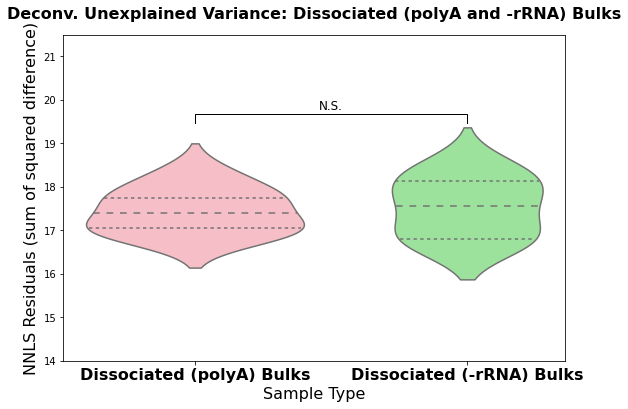

In [39]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
bulk_type_1 = calc_res_tot_disspolyabulks.values[0]
bulk_type_2 = calc_res_tot_dissbulks.values[0]

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['BulkType1'] * len(bulk_type_1) +
                                  ['BulkType2'] * len(bulk_type_2),
                   'Residuals': np.concatenate([bulk_type_1, bulk_type_2])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals', data=df, ax=ax, inner='quartile', 
                palette=['lightpink', 'lightgreen'])

# Add labels to the x-axis
ax.set_xticklabels(['Dissociated (polyA) Bulks', 'Dissociated (-rRNA) Bulks'], fontsize=16, 
                fontname='Arial',fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
# Perform the paired t-test
t_statistic, p_value = wilcoxon(bulk_type_1, bulk_type_2)

# Set a significance level (e.g., 0.05)
alpha = 0.05

#getting maximum value for significance line:
max_val = np.max([max(bulk_type_1),max(bulk_type_2)])

# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value, 3)}"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 1, max_val +1.55
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2, asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', 
                    fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value, 3)}"
    significance_label = f"Significant p={np.round(p_value, 3)}"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 1, max_val +1.2
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2+0.03, s='N.S.', ha='center', va='bottom', fontsize=12, 
                    fontname='Arial')
    # No asterisks for non-significant results

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('NNLS Residuals (sum of squared difference)', fontsize=16, fontname='Arial')
plt.title('Deconv. Unexplained Variance: Dissociated (polyA and -rRNA) Bulks', 
                fontsize=16, fontname='Arial', fontweight='bold', x=0.5, y=1.03)
plt.ylim(14, 21.5)
plt.show()

## Residuals Prep

Putting bulks together for multiplication:

Recreate Matrices:

In [40]:
#recreate matrix with calculated proportion nnls and multiplying by the used reference
bulks_recreated_mat_all = pd.DataFrame(all_refs @ calc_prop_tot_bulks.T)
bulks_recreated_mat_all = bulks_recreated_mat_all.T
bulks_recreated_mat_all.columns = gene_ids
bulks_recreated_mat_all   

A1BG       A2M     AAGAB      AASS      AATF      AATK      ABAT  \
2497  0.471470  0.770198  0.177265  0.262278  0.445554  0.119424  0.078670   
2467  0.467744  0.635855  0.180120  0.124064  0.423556  0.098004  0.083507   
2380  0.381597  0.930283  0.202022  0.353389  0.532638  0.139360  0.075037   
2293  0.421373  0.747481  0.247079  0.064504  0.454194  0.111518  0.086918   
2283  0.462608  0.723338  0.174518  0.210720  0.453791  0.111202  0.077763   
2428  0.462565  0.608895  0.184486  0.124711  0.429126  0.089603  0.083036   
2251  0.410180  0.892106  0.223325  0.247871  0.451925  0.114154  0.084245   
2267  0.364939  0.883861  0.233144  0.270252  0.515129  0.145084  0.090203   

         ABCA1     ABCA5     ABCB1  ...    ZNHIT1    ZNHIT3     ZNRF1  \
2497  0.827467  0.195228  0.056184  ...  0.948922  0.274365  0.273404   
2467  0.703326  0.145517  0.055875  ...  0.946465  0.263086  0.308454   
2380  0.898467  0.204098  0.219736  ...  0.985608  0.256588  0.297869   
2293  0.794764  0.164700  0.048635  ...  0.972231  0.244007  0.300130   
2283  0.748604  0.156368  0.079662  ...  0.964030  0.275701  0.311931   
2428  0.698649  0.160255  0.060564  ...  0.908558  0.258453  0.289688   
2251  0.985478  0.271246  0.073387  ...  0.904913  0.219571  0.212491   
2267  0.917964  0.204680  0.186202  ...  0.981085  0.233011  0.276472   

         ZNRF3      ZPR1     ZRSR2   ZSCAN18    ZSWIM8      ZXDC       ZYX  
2497  0.209173  0.248390  0.231292  0.295461  0.166286  0.215263  0.785939  
2467  0.162206  0.264883  0.204958  0.312653  0.148165  0.244722  0.768305  
2380  0.213979  0.238570  0.273141  0.248749  0.186686  0.176373  0.916088  
2293  0.113793  0.252485  0.267080  0.212001  0.189981  0.222899  0.863631  
2283  0.190347  0.263448  0.216814  0.317150  0.158493  0.223707  0.817858  
2428  0.158274  0.258945  0.224600  0.306790  0.144366  0.246497  0.717794  
2251  0.188520  0.202993  0.275411  0.170929  0.190793  0.212627  0.719625  
2267  0.175180  0.227564  0.280448  0.200276  0.188805  0.186637  0.915996  

[8 rows x 4584 columns]

In [41]:
#recreate matrix with calculated proportion nnls and multiplying by the used reference
dissbulks_recreated_mat_all = pd.DataFrame(all_refs @ calc_prop_tot_dissbulks.T)
dissbulks_recreated_mat_all = dissbulks_recreated_mat_all.T
dissbulks_recreated_mat_all.columns = gene_ids
dissbulks_recreated_mat_all 

A1BG       A2M     AAGAB      AASS      AATF      AATK      ABAT  \
2497  0.439936  0.829167  0.169793  0.305568  0.470035  0.115780  0.072984   
2467  0.390063  0.923241  0.218631  0.259659  0.485235  0.116189  0.077248   
2380  0.376133  0.891317  0.198508  0.327552  0.511345  0.130153  0.081481   
2293  0.392390  0.787917  0.213238  0.177308  0.473121  0.102778  0.078750   
2283  0.446527  0.766925  0.171945  0.246292  0.460530  0.108764  0.076325   
2428  0.419197  0.742428  0.184734  0.175963  0.445566  0.091557  0.081684   
2251  0.332760  0.900000  0.191431  0.258897  0.505185  0.080632  0.071317   
2267  0.393615  0.855280  0.260722  0.140278  0.487434  0.111869  0.092949   

         ABCA1     ABCA5     ABCB1  ...    ZNHIT1    ZNHIT3     ZNRF1  \
2497  0.841113  0.201122  0.122934  ...  0.946459  0.265657  0.284765   
2467  0.938102  0.237970  0.141057  ...  0.943419  0.228377  0.260890   
2380  0.907833  0.216277  0.213996  ...  0.959871  0.237943  0.281226   
2293  0.809561  0.190896  0.177136  ...  0.943919  0.230780  0.293626   
2283  0.791176  0.179464  0.109806  ...  0.951312  0.264699  0.300454   
2428  0.797091  0.190989  0.121271  ...  0.923148  0.231848  0.289766   
2251  0.879421  0.234046  0.288113  ...  0.906814  0.195106  0.294767   
2267  0.892583  0.246894  0.113502  ...  0.952918  0.233943  0.257046   

         ZNRF3      ZPR1     ZRSR2   ZSCAN18    ZSWIM8      ZXDC       ZYX  
2497  0.220561  0.241946  0.231102  0.285530  0.167328  0.205897  0.798676  
2467  0.188573  0.219886  0.270564  0.194979  0.192506  0.202253  0.804129  
2380  0.208261  0.225512  0.259786  0.231649  0.177103  0.192328  0.847659  
2293  0.159215  0.242593  0.254515  0.237083  0.171449  0.218342  0.799778  
2283  0.202145  0.251004  0.220947  0.298845  0.160456  0.220739  0.790320  
2428  0.175147  0.236223  0.217077  0.256560  0.156712  0.239672  0.725724  
2251  0.190015  0.211359  0.244815  0.199876  0.168472  0.221519  0.715848  
2267  0.125615  0.220950  0.335419  0.124964  0.211723  0.204741  0.829550  

[8 rows x 4584 columns]

In [42]:
#recreate matrix with calculated proportion nnls and multiplying by the used reference
disspolyabulks_recreated_mat_all = pd.DataFrame(all_refs @ calc_prop_tot_disspolyabulks.T)
disspolyabulks_recreated_mat_all = disspolyabulks_recreated_mat_all.T
disspolyabulks_recreated_mat_all.columns = gene_ids
disspolyabulks_recreated_mat_all 

A1BG       A2M     AAGAB      AASS      AATF      AATK      ABAT  \
2497  0.437826  0.815924  0.163266  0.306749  0.468127  0.116763  0.068527   
2467  0.389340  0.941881  0.221313  0.276117  0.509621  0.127167  0.070338   
2380  0.364619  0.867531  0.202545  0.310282  0.510524  0.133645  0.083910   
2293  0.398502  0.755953  0.211394  0.174305  0.475916  0.110354  0.082049   
2283  0.452825  0.771333  0.172324  0.256322  0.473583  0.115766  0.073385   
2428  0.408844  0.708158  0.178745  0.150751  0.436231  0.087800  0.076514   
2251  0.323251  0.905399  0.185423  0.276671  0.522207  0.081068  0.067113   
2267  0.392807  0.848195  0.254010  0.139965  0.469316  0.116244  0.085291   

         ABCA1     ABCA5     ABCB1  ...    ZNHIT1    ZNHIT3     ZNRF1  \
2497  0.799009  0.183660  0.123427  ...  0.937354  0.273706  0.287495   
2467  0.894782  0.208772  0.156711  ...  0.969794  0.250161  0.285414   
2380  0.884751  0.203170  0.219593  ...  0.955649  0.235233  0.280585   
2293  0.783165  0.172153  0.171397  ...  0.957520  0.239688  0.303458   
2283  0.767435  0.162392  0.112736  ...  0.971594  0.279688  0.316573   
2428  0.727380  0.164565  0.121359  ...  0.900129  0.235095  0.291149   
2251  0.849909  0.219554  0.325432  ...  0.914637  0.201327  0.313122   
2267  0.860093  0.223079  0.103422  ...  0.934546  0.235479  0.245907   

         ZNRF3      ZPR1     ZRSR2   ZSCAN18    ZSWIM8      ZXDC       ZYX  
2497  0.216555  0.247345  0.226485  0.292165  0.163607  0.193574  0.838148  
2467  0.186595  0.238123  0.281423  0.217445  0.198533  0.180832  0.904852  
2380  0.195445  0.225898  0.258780  0.223924  0.173804  0.186989  0.877423  
2293  0.156905  0.250245  0.249905  0.254152  0.167337  0.216873  0.832578  
2283  0.203582  0.263204  0.225785  0.318779  0.163408  0.211772  0.842233  
2428  0.158538  0.241140  0.207855  0.254840  0.149290  0.226406  0.770315  
2251  0.193285  0.218774  0.244680  0.215526  0.166241  0.213817  0.749439  
2267  0.123740  0.223394  0.314384  0.137658  0.204229  0.190974  0.881829  

[8 rows x 4584 columns]

In [43]:
calc_prop_tot_combo

Plasma cells  Monocytes   T cells  Endothelial cells  NK cells  \
2497      0.168129   0.000000  0.000000           0.001952  0.000000   
2467      0.189183   0.000000  0.000000           0.000000  0.000000   
2380      0.054033   0.065596  0.000000           0.273897  0.000000   
2293      0.104255   0.000000  0.002306           0.000000  0.009614   
2283      0.135043   0.000000  0.000000           0.057883  0.000000   
2428      0.214877   0.000000  0.000000           0.000000  0.000000   
2251      0.299681   0.000000  0.000000           0.001020  0.000000   
2267      0.071013   0.115836  0.000000           0.221303  0.000000   
2497      0.177951   0.000000  0.000000           0.109419  0.000000   
2467      0.212424   0.000000  0.000000           0.125180  0.000000   
2380      0.150659   0.079309  0.000000           0.248631  0.000000   
2293      0.182654   0.018475  0.000000           0.154943  0.000000   
2283      0.182793   0.000000  0.000000           0.092171  0.000000   
2428      0.288531   0.000000  0.000000           0.091134  0.000000   
2251      0.349856   0.000000  0.000000           0.325277  0.000000   
2267      0.166094   0.000000  0.073379           0.022119  0.033373   

      Epithelial cells       ILC  Fibroblasts   B cells   DC  Macrophages  \
2497          0.332513  0.009466     0.411669  0.007517  0.0     0.068754   
2467          0.588033  0.017411     0.097271  0.000000  0.0     0.108102   
2380          0.000000  0.000000     0.492033  0.000000  0.0     0.114442   
2293          0.400556  0.000000     0.000000  0.000000  0.0     0.473087   
2283          0.470268  0.000000     0.265076  0.000000  0.0     0.071730   
2428          0.545113  0.008705     0.093632  0.053490  0.0     0.084183   
2251          0.000000  0.000000     0.392360  0.025019  0.0     0.281920   
2267          0.000000  0.000000     0.346018  0.000000  0.0     0.245830   
2497          0.226143  0.000000     0.449894  0.000000  0.0     0.028841   
2467          0.031689  0.000000     0.357342  0.000000  0.0     0.273365   
2380          0.000000  0.000000     0.438024  0.000000  0.0     0.083378   
2293          0.227778  0.041141     0.150264  0.000000  0.0     0.224744   
2283          0.357205  0.000000     0.322631  0.000000  0.0     0.045200   
2428          0.345894  0.000000     0.161475  0.000000  0.0     0.112966   
2251          0.000000  0.000000     0.220778  0.000000  0.0     0.104089   
2267          0.014624  0.000000     0.178246  0.000000  0.0     0.508578   

      pDC  Mast cells  Erythroid  
2497  0.0    0.000000   0.000000  
2467  0.0    0.000000   0.000000  
2380  0.0    0.000000   0.000000  
2293  0.0    0.010181   0.000000  
2283  0.0    0.000000   0.000000  
2428  0.0    0.000000   0.000000  
2251  0.0    0.000000   0.000000  
2267  0.0    0.000000   0.000000  
2497  0.0    0.000000   0.007752  
2467  0.0    0.000000   0.000000  
2380  0.0    0.000000   0.000000  
2293  0.0    0.000000   0.000000  
2283  0.0    0.000000   0.000000  
2428  0.0    0.000000   0.000000  
2251  0.0    0.000000   0.000000  
2267  0.0    0.000000   0.003587

In [44]:
#recreate matrix with calculated proportion nnls and multiplying by the used reference
combo_recreated_mat_all = pd.DataFrame(all_refs @ calc_prop_tot_combo.T)
combo_recreated_mat_all = combo_recreated_mat_all.T
combo_recreated_mat_all.columns = gene_ids
combo_recreated_mat_all 

A1BG       A2M     AAGAB      AASS      AATF      AATK      ABAT  \
2497  0.471470  0.770198  0.177265  0.262278  0.445554  0.119424  0.078670   
2467  0.467744  0.635855  0.180120  0.124064  0.423556  0.098004  0.083507   
2380  0.381597  0.930283  0.202022  0.353389  0.532638  0.139360  0.075037   
2293  0.421373  0.747481  0.247079  0.064504  0.454194  0.111518  0.086918   
2283  0.462608  0.723338  0.174518  0.210720  0.453791  0.111202  0.077763   
2428  0.462565  0.608895  0.184486  0.124711  0.429126  0.089603  0.083036   
2251  0.410180  0.892106  0.223325  0.247871  0.451925  0.114154  0.084245   
2267  0.364939  0.883861  0.233144  0.270252  0.515129  0.145084  0.090203   
2497  0.439936  0.829167  0.169793  0.305568  0.470035  0.115780  0.072984   
2467  0.390063  0.923241  0.218631  0.259659  0.485235  0.116189  0.077248   
2380  0.376133  0.891317  0.198508  0.327552  0.511345  0.130153  0.081481   
2293  0.392390  0.787917  0.213238  0.177308  0.473121  0.102778  0.078750   
2283  0.446527  0.766925  0.171945  0.246292  0.460530  0.108764  0.076325   
2428  0.419197  0.742428  0.184734  0.175963  0.445566  0.091557  0.081684   
2251  0.332760  0.900000  0.191431  0.258897  0.505185  0.080632  0.071317   
2267  0.393615  0.855280  0.260722  0.140278  0.487434  0.111869  0.092949   

         ABCA1     ABCA5     ABCB1  ...    ZNHIT1    ZNHIT3     ZNRF1  \
2497  0.827467  0.195228  0.056184  ...  0.948922  0.274365  0.273404   
2467  0.703326  0.145517  0.055875  ...  0.946465  0.263086  0.308454   
2380  0.898467  0.204098  0.219736  ...  0.985608  0.256588  0.297869   
2293  0.794764  0.164700  0.048635  ...  0.972231  0.244007  0.300130   
2283  0.748604  0.156368  0.079662  ...  0.964030  0.275701  0.311931   
2428  0.698649  0.160255  0.060564  ...  0.908558  0.258453  0.289688   
2251  0.985478  0.271246  0.073387  ...  0.904913  0.219571  0.212491   
2267  0.917964  0.204680  0.186202  ...  0.981085  0.233011  0.276472   
2497  0.841113  0.201122  0.122934  ...  0.946459  0.265657  0.284765   
2467  0.938102  0.237970  0.141057  ...  0.943419  0.228377  0.260890   
2380  0.907833  0.216277  0.213996  ...  0.959871  0.237943  0.281226   
2293  0.809561  0.190896  0.177136  ...  0.943919  0.230780  0.293626   
2283  0.791176  0.179464  0.109806  ...  0.951312  0.264699  0.300454   
2428  0.797091  0.190989  0.121271  ...  0.923148  0.231848  0.289766   
2251  0.879421  0.234046  0.288113  ...  0.906814  0.195106  0.294767   
2267  0.892583  0.246894  0.113502  ...  0.952918  0.233943  0.257046   

         ZNRF3      ZPR1     ZRSR2   ZSCAN18    ZSWIM8      ZXDC       ZYX  
2497  0.209173  0.248390  0.231292  0.295461  0.166286  0.215263  0.785939  
2467  0.162206  0.264883  0.204958  0.312653  0.148165  0.244722  0.768305  
2380  0.213979  0.238570  0.273141  0.248749  0.186686  0.176373  0.916088  
2293  0.113793  0.252485  0.267080  0.212001  0.189981  0.222899  0.863631  
2283  0.190347  0.263448  0.216814  0.317150  0.158493  0.223707  0.817858  
2428  0.158274  0.258945  0.224600  0.306790  0.144366  0.246497  0.717794  
2251  0.188520  0.202993  0.275411  0.170929  0.190793  0.212627  0.719625  
2267  0.175180  0.227564  0.280448  0.200276  0.188805  0.186637  0.915996  
2497  0.220561  0.241946  0.231102  0.285530  0.167328  0.205897  0.798676  
2467  0.188573  0.219886  0.270564  0.194979  0.192506  0.202253  0.804129  
2380  0.208261  0.225512  0.259786  0.231649  0.177103  0.192328  0.847659  
2293  0.159215  0.242593  0.254515  0.237083  0.171449  0.218342  0.799778  
2283  0.202145  0.251004  0.220947  0.298845  0.160456  0.220739  0.790320  
2428  0.175147  0.236223  0.217077  0.256560  0.156712  0.239672  0.725724  
2251  0.190015  0.211359  0.244815  0.199876  0.168472  0.221519  0.715848  
2267  0.125615  0.220950  0.335419  0.124964  0.211723  0.204741  0.829550  

[16 rows x 4584 columns]

## **Calculate Residuals:**

1. Residual uses:

pseudobulks - recreated_mat_all (reference used normalized (all_refs) * calculated proportions (calc_prop_tot))

In [45]:
#Classic Bulks: Residual as the the difference between the recreated matrix and pseudobulks.
res = bulks.values - bulks_recreated_mat_all.values
residuals_bulks = pd.DataFrame(res, columns = bulks_recreated_mat_all.columns, index = sample_ids)
residuals_bulks

A1BG       A2M     AAGAB      AASS      AATF      AATK      ABAT  \
2497 -0.440594  0.229802  0.032465  0.073472 -0.204720 -0.042577  0.134033   
2467 -0.433589  0.364145  0.044287  0.145671 -0.097320  0.193119  0.058862   
2380 -0.375200  0.069717  0.010186  0.394631 -0.240577 -0.077815  0.031949   
2293 -0.403999  0.252519  0.089843  0.013850 -0.128855 -0.061099  0.165177   
2283 -0.387753  0.276662  0.145117  0.023579 -0.208264 -0.030857  0.039760   
2428 -0.425628  0.391105  0.020019 -0.038225 -0.053451  0.088775 -0.010964   
2251 -0.388930  0.107894 -0.032597  0.148278 -0.212137 -0.034924  0.043257   
2267 -0.356958  0.116139  0.021372  0.026830 -0.223959 -0.051968  0.013554   

         ABCA1     ABCA5     ABCB1  ...    ZNHIT1    ZNHIT3     ZNRF1  \
2497  0.172533  0.036458 -0.011356  ... -0.669435 -0.203006 -0.194269   
2467  0.296674  0.193487 -0.045660  ... -0.614483 -0.171791 -0.104796   
2380  0.101533  0.209949 -0.110985  ... -0.835166 -0.196808 -0.230148   
2293  0.205236  0.065592 -0.016953  ... -0.679596 -0.133630 -0.198610   
2283  0.251396  0.115858  0.019397  ... -0.608465 -0.184876 -0.095847   
2428  0.301351  0.839745 -0.042095  ... -0.740090 -0.158453 -0.189237   
2251  0.014522  0.129887  0.010827  ... -0.693197 -0.140079 -0.125915   
2267  0.082036  0.077031 -0.073577  ... -0.801653 -0.180689 -0.152909   

         ZNRF3      ZPR1     ZRSR2   ZSCAN18    ZSWIM8      ZXDC       ZYX  
2497 -0.040840  0.052138 -0.182348  0.198330  0.324302  0.193218  0.214061  
2467  0.061881  0.056884 -0.133135 -0.031426  0.364811  0.532562 -0.076889  
2380 -0.026478  0.236581 -0.233655 -0.120366  0.335450  0.031864 -0.154611  
2293 -0.053835  0.031973 -0.154659 -0.082206  0.326814  0.316380 -0.114500  
2283  0.090612  0.166474 -0.126987  0.440391  0.841507  0.292050 -0.482504  
2428  0.248032  0.047812 -0.193519  0.130147  0.518247  0.573323 -0.464190  
2251 -0.093024  0.038631 -0.157878  0.095881  0.555331  0.259865  0.157674  
2267 -0.030038  0.237422 -0.191766 -0.048631  0.360428  0.072903  0.084004  

[8 rows x 4584 columns]

In [46]:
#Dissociated dissbulks: Residual as the the difference between the recreated matrix and pseudodissbulks.
res = diss_bulks.values - dissbulks_recreated_mat_all.values
residuals_dissbulks = pd.DataFrame(res, columns = dissbulks_recreated_mat_all.columns, index = sample_ids)
residuals_dissbulks

A1BG       A2M     AAGAB      AASS      AATF      AATK      ABAT  \
2497 -0.397186  0.170833  0.012057  0.156001 -0.236972  0.023320  0.046368   
2467 -0.360944  0.076759 -0.061533  0.134345 -0.236826  0.033000 -0.017932   
2380 -0.353701  0.108683 -0.002360  0.107695 -0.192912  0.238343 -0.020749   
2293 -0.379074  0.212083  0.082210  0.235764 -0.158532  0.003750  0.013629   
2283 -0.401672  0.233075  0.045543  0.070053 -0.208221  0.026981 -0.006091   
2428 -0.350922  0.257572  0.007976  0.003533 -0.115573  0.575036 -0.045712   
2251 -0.314846  0.100000 -0.018452  0.199859 -0.219127  0.106901 -0.012258   
2267 -0.371112  0.144720 -0.070638  0.020360 -0.187465 -0.051061 -0.015863   

         ABCA1     ABCA5     ABCB1  ...    ZNHIT1    ZNHIT3     ZNRF1  \
2497  0.158887 -0.030991 -0.010742  ... -0.615094 -0.203377 -0.206427   
2467  0.061898  0.066880 -0.037524  ... -0.678114 -0.150008 -0.117812   
2380  0.092167  0.035132 -0.068731  ... -0.731715 -0.182409 -0.190401   
2293  0.190439 -0.043034 -0.093634  ... -0.676490 -0.158374 -0.187099   
2283  0.208824 -0.016274  0.010299  ... -0.633491 -0.194170 -0.149068   
2428  0.202909  0.306387 -0.039048  ... -0.713186 -0.190369 -0.225529   
2251  0.120579  0.027661  0.008302  ... -0.694649 -0.154520 -0.197922   
2267  0.107417 -0.105169 -0.019418  ... -0.727163 -0.173853 -0.173495   

         ZNRF3      ZPR1     ZRSR2   ZSCAN18    ZSWIM8      ZXDC       ZYX  
2497 -0.096652  0.176872 -0.185531  0.227469  0.318111  0.152811  0.201324  
2467 -0.076411  0.021693 -0.177815  0.021076  0.514616  0.220510  0.195871  
2380 -0.012933  0.358281 -0.209176 -0.074621  0.427209  0.144160  0.152341  
2293  0.053563  0.463707 -0.128845 -0.018757  0.236075  0.161163  0.200222  
2283  0.080854  0.581174 -0.143336  0.173608  0.753168  0.362671 -0.078838  
2428 -0.001525  0.467444 -0.189914  0.087382  0.343233  0.506208 -0.124469  
2251 -0.049785  0.388188 -0.170362  0.068269  0.272651  0.222403  0.157161  
2267 -0.107660  0.272694 -0.210213 -0.037104  0.258699  0.071767  0.170450  

[8 rows x 4584 columns]

In [47]:
#Dissociated dissbulks: Residual as the the difference between the recreated matrix and pseudodissbulks.
residuals_disspolyabulks = pd.DataFrame()
res = disspolya_bulks.values - disspolyabulks_recreated_mat_all.values
residuals_disspolyabulks = pd.DataFrame(res, columns = disspolyabulks_recreated_mat_all.columns, index = sample_ids)
residuals_disspolyabulks

A1BG       A2M     AAGAB      AASS      AATF      AATK      ABAT  \
2497 -0.414930  0.184076  0.006002  0.187224 -0.258432 -0.056764  0.048525   
2467 -0.360762  0.058119 -0.051811  0.163405 -0.265223 -0.026648 -0.020078   
2380 -0.354087  0.132469  0.001363  0.183310 -0.215003 -0.061192 -0.035946   
2293 -0.391644  0.244047  0.081124  0.292258 -0.226200 -0.064005  0.015379   
2283 -0.436311  0.228667  0.038178  0.092145 -0.225245 -0.062461 -0.000013   
2428 -0.380561  0.291842  0.017166 -0.000368 -0.167657  0.066952 -0.050071   
2251 -0.313966  0.094601 -0.041080  0.200083 -0.275727 -0.012526 -0.022037   
2267 -0.380749  0.151805 -0.058647  0.027613 -0.221531 -0.079898 -0.009278   

         ABCA1     ABCA5     ABCB1  ...    ZNHIT1    ZNHIT3     ZNRF1  \
2497 -0.077960 -0.011824 -0.037659  ... -0.637509 -0.215747 -0.213516   
2467  0.105218  0.032867 -0.079056  ... -0.624089 -0.160483 -0.145280   
2380  0.115249  0.051620 -0.111992  ... -0.718750 -0.177499 -0.199123   
2293  0.216835 -0.055098 -0.106840  ... -0.666657 -0.182225 -0.169614   
2283  0.114918  0.003167 -0.002991  ... -0.635459 -0.209869 -0.139308   
2428  0.272620  0.151607 -0.046857  ... -0.657079 -0.175309 -0.245160   
2251  0.150091  0.022199 -0.091445  ... -0.706817 -0.158108 -0.210647   
2267  0.139907 -0.067733 -0.035272  ... -0.693051 -0.170125 -0.160807   

         ZNRF3      ZPR1     ZRSR2   ZSCAN18    ZSWIM8      ZXDC       ZYX  
2497 -0.136531  0.142877 -0.163614  0.187375  0.407595  0.114432  0.161852  
2467 -0.119582  0.001939 -0.099111  0.033654  0.777875  0.192269  0.095148  
2380 -0.086956  0.392044 -0.151814 -0.105031  0.444138  0.067674  0.122577  
2293  0.019031  0.403841 -0.060962 -0.031630  0.272504  0.079428  0.167422  
2283  0.039321  0.464878 -0.105797  0.112468  0.836592  0.263373  0.157767  
2428 -0.052075  0.472604 -0.174513  0.032130  0.323933  0.468713  0.216141  
2251 -0.092160  0.353363 -0.142712  0.020487  0.269320  0.146280  0.250561  
2267 -0.113081  0.238276 -0.113954 -0.052733  0.314582  0.028154  0.118171  

[8 rows x 4584 columns]

In [48]:
#Dissociated combo: Residual as the the difference between the recreated matrix and pseudocombo.
residuals_combo = pd.DataFrame()
res = combo.values - combo_recreated_mat_all.values
residuals_combo = pd.DataFrame(res, columns = combo_recreated_mat_all.columns)
residuals_combo.index = np.concatenate([residuals_bulks.index.values, residuals_dissbulks.index.values])
residuals_combo

A1BG       A2M     AAGAB      AASS      AATF      AATK      ABAT  \
2497 -0.440594  0.229802  0.032465  0.073472 -0.204720 -0.042577  0.134033   
2467 -0.433589  0.364145  0.044287  0.145671 -0.097320  0.193119  0.058862   
2380 -0.375200  0.069717  0.010186  0.394631 -0.240577 -0.077815  0.031949   
2293 -0.403999  0.252519  0.089843  0.013850 -0.128855 -0.061099  0.165177   
2283 -0.387753  0.276662  0.145117  0.023579 -0.208264 -0.030857  0.039760   
2428 -0.425628  0.391105  0.020019 -0.038225 -0.053451  0.088775 -0.010964   
2251 -0.388930  0.107894 -0.032597  0.148278 -0.212137 -0.034924  0.043257   
2267 -0.356958  0.116139  0.021372  0.026830 -0.223959 -0.051968  0.013554   
2497 -0.397186  0.170833  0.012057  0.156001 -0.236972  0.023320  0.046368   
2467 -0.360944  0.076759 -0.061533  0.134345 -0.236826  0.033000 -0.017932   
2380 -0.353701  0.108683 -0.002360  0.107695 -0.192912  0.238343 -0.020749   
2293 -0.379074  0.212083  0.082210  0.235764 -0.158532  0.003750  0.013629   
2283 -0.401672  0.233075  0.045543  0.070053 -0.208221  0.026981 -0.006091   
2428 -0.350922  0.257572  0.007976  0.003533 -0.115573  0.575036 -0.045712   
2251 -0.314846  0.100000 -0.018452  0.199859 -0.219127  0.106901 -0.012258   
2267 -0.371112  0.144720 -0.070638  0.020360 -0.187465 -0.051061 -0.015863   

         ABCA1     ABCA5     ABCB1  ...    ZNHIT1    ZNHIT3     ZNRF1  \
2497  0.172533  0.036458 -0.011356  ... -0.669435 -0.203006 -0.194269   
2467  0.296674  0.193487 -0.045660  ... -0.614483 -0.171791 -0.104796   
2380  0.101533  0.209949 -0.110985  ... -0.835166 -0.196808 -0.230148   
2293  0.205236  0.065592 -0.016953  ... -0.679596 -0.133630 -0.198610   
2283  0.251396  0.115858  0.019397  ... -0.608465 -0.184876 -0.095847   
2428  0.301351  0.839745 -0.042095  ... -0.740090 -0.158453 -0.189237   
2251  0.014522  0.129887  0.010827  ... -0.693197 -0.140079 -0.125915   
2267  0.082036  0.077031 -0.073577  ... -0.801653 -0.180689 -0.152909   
2497  0.158887 -0.030991 -0.010742  ... -0.615094 -0.203377 -0.206427   
2467  0.061898  0.066880 -0.037524  ... -0.678114 -0.150008 -0.117812   
2380  0.092167  0.035132 -0.068731  ... -0.731715 -0.182409 -0.190401   
2293  0.190439 -0.043034 -0.093634  ... -0.676490 -0.158374 -0.187099   
2283  0.208824 -0.016274  0.010299  ... -0.633491 -0.194170 -0.149068   
2428  0.202909  0.306387 -0.039048  ... -0.713186 -0.190369 -0.225529   
2251  0.120579  0.027661  0.008302  ... -0.694649 -0.154520 -0.197922   
2267  0.107417 -0.105169 -0.019418  ... -0.727163 -0.173853 -0.173495   

         ZNRF3      ZPR1     ZRSR2   ZSCAN18    ZSWIM8      ZXDC       ZYX  
2497 -0.040840  0.052138 -0.182348  0.198330  0.324302  0.193218  0.214061  
2467  0.061881  0.056884 -0.133135 -0.031426  0.364811  0.532562 -0.076889  
2380 -0.026478  0.236581 -0.233655 -0.120366  0.335450  0.031864 -0.154611  
2293 -0.053835  0.031973 -0.154659 -0.082206  0.326814  0.316380 -0.114500  
2283  0.090612  0.166474 -0.126987  0.440391  0.841507  0.292050 -0.482504  
2428  0.248032  0.047812 -0.193519  0.130147  0.518247  0.573323 -0.464190  
2251 -0.093024  0.038631 -0.157878  0.095881  0.555331  0.259865  0.157674  
2267 -0.030038  0.237422 -0.191766 -0.048631  0.360428  0.072903  0.084004  
2497 -0.096652  0.176872 -0.185531  0.227469  0.318111  0.152811  0.201324  
2467 -0.076411  0.021693 -0.177815  0.021076  0.514616  0.220510  0.195871  
2380 -0.012933  0.358281 -0.209176 -0.074621  0.427209  0.144160  0.152341  
2293  0.053563  0.463707 -0.128845 -0.018757  0.236075  0.161163  0.200222  
2283  0.080854  0.581174 -0.143336  0.173608  0.753168  0.362671 -0.078838  
2428 -0.001525  0.467444 -0.189914  0.087382  0.343233  0.506208 -0.124469  
2251 -0.049785  0.388188 -0.170362  0.068269  0.272651  0.222403  0.157161  
2267 -0.107660  0.272694 -0.210213 -0.037104  0.258699  0.071767  0.170450  

[16 rows x 4584 columns]

## Comparing Residuals

In [49]:
adip_markers = np.intersect1d(adip_markers, residuals_bulks.columns)
diss_response= np.intersect1d(diss_response, residuals_bulks.columns)
cibersort_genes= np.intersect1d(cibersort_genes, residuals_bulks.columns)

Residual Correlation: Classic vs. Dissociated

In [50]:
# Create a scatter plot with labels for multiple genes
plt.figure(figsize=(28,19))
# Plot CIBERSORT genes
genes_of_interest = cibersort_genes
for gene in genes_of_interest:
    gene_data_bulks = residuals_bulks[gene]
    gene_data_dissbulks = residuals_dissbulks[gene]
    plt.scatter(gene_data_dissbulks, gene_data_bulks, alpha=0.5, c='lightblue', s=150,
                    label='CSx Barcode Genes' if gene == genes_of_interest[0] else "")

# Plot Adipocyte markers
for gene in adip_markers:
    gene_data_bulks = residuals_bulks[gene]
    gene_data_dissbulks = residuals_dissbulks[gene]
    plt.scatter(gene_data_dissbulks, gene_data_bulks, alpha=1, c='darkviolet', marker='d', s=150,
                    label='Adipocyte Markers' if gene == adip_markers[0] else "")

# Plot Dissociation Response genes
for gene in diss_response:
    gene_data_bulks = residuals_bulks[gene]
    gene_data_dissbulks = residuals_dissbulks[gene]
    plt.scatter(gene_data_dissbulks, gene_data_bulks, alpha=1, c='black', marker='*', s=150,
                    label='Dissociation Response' if gene == diss_response[0] else "")


# Plot 1:1 Line
plt.plot([-1, 1], [-1, 1], label='1:1 Line', color='blue', linewidth=1.3, linestyle='--')

# Set axis labels and title
plt.title("Comparison of Classic and Dissociated Bulks\nResidual's Adipocyte Cell Markers and Dissociation Markers", 
                fontsize=46, fontname='Arial', fontweight='bold', x=0.5, y=1.0003)
plt.ylabel('Residual Classic Bulks (-rRNA)', fontsize=36, fontname='Arial', fontweight='bold')
plt.xlabel('Residual Dissociated Bulks (-rRNA)', fontsize=36, fontname='Arial', fontweight='bold')
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

# Add legend
plt.legend(fontsize=34, markerscale=1)

# Show the plot
plt.show()

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


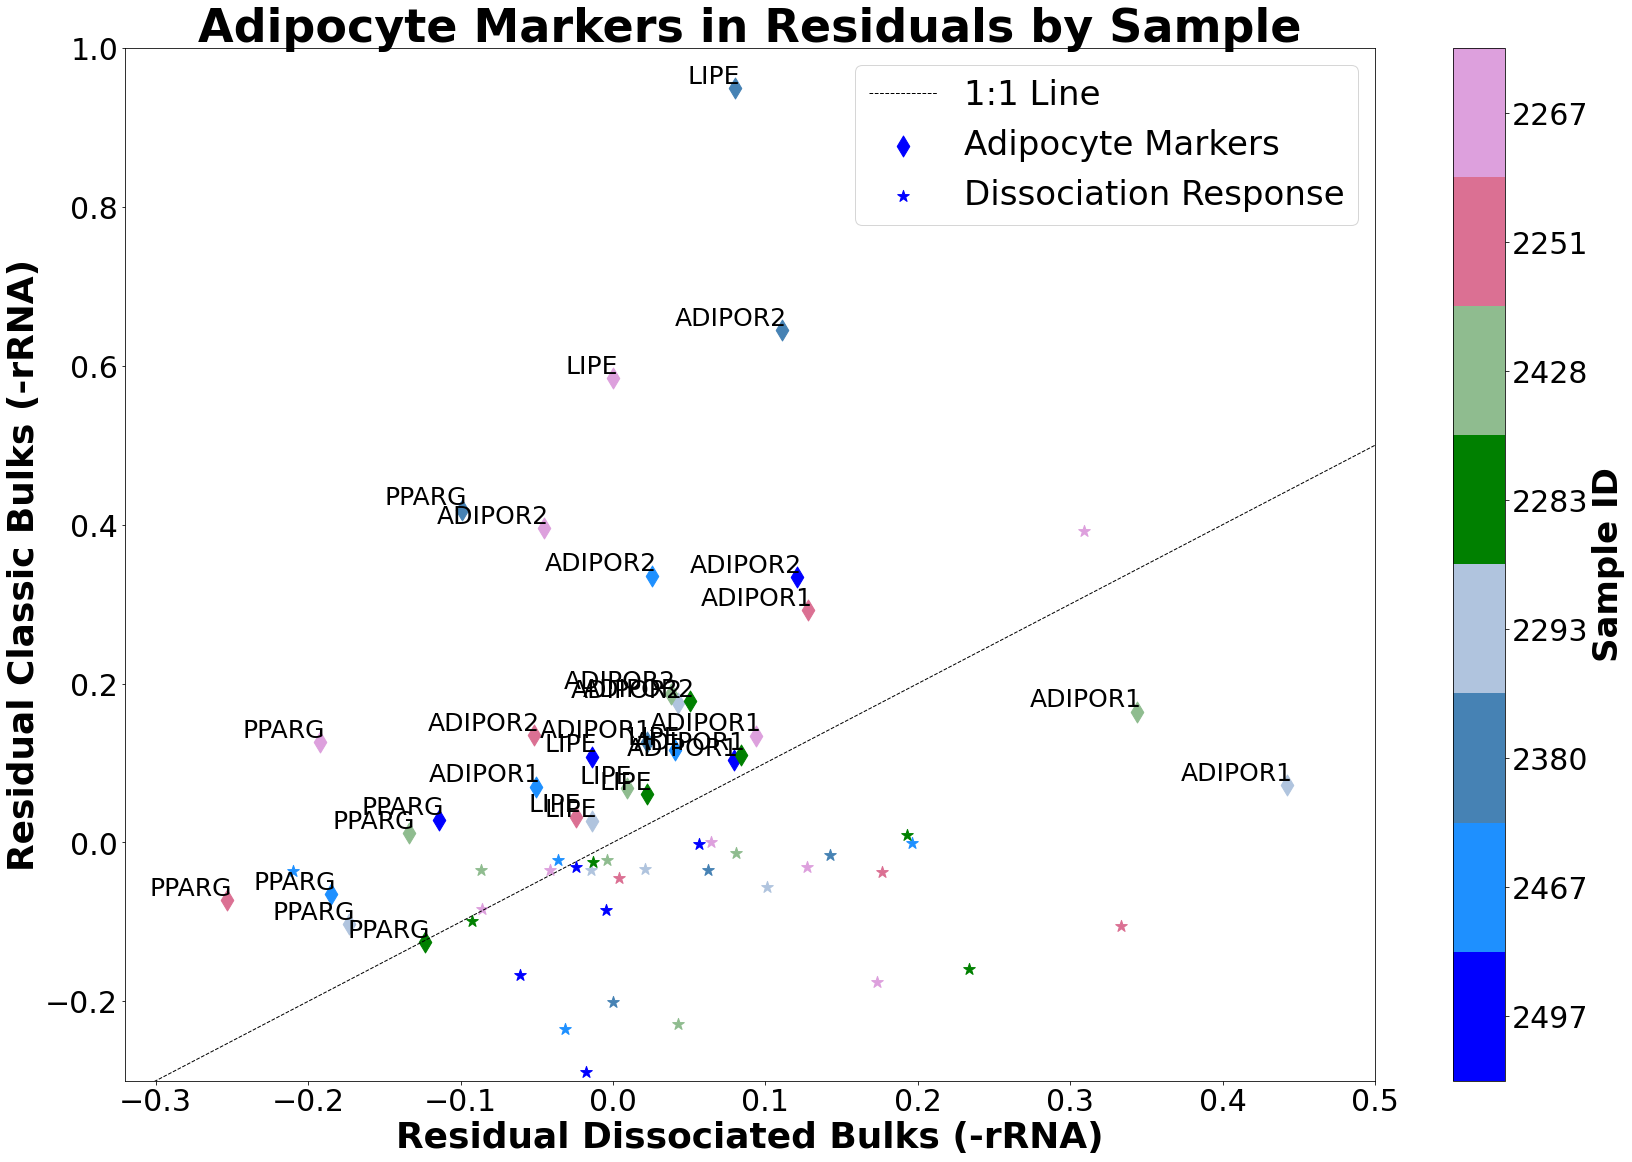

In [58]:
#making copy for numerated index:
res_dissbulks_copy = residuals_dissbulks.copy()
res_bulks_copy = residuals_bulks.copy()

res_dissbulks_copy.index = range(0,8)
res_bulks_copy.index = range(0,8)

row_indices = sample_ids *2
# Define custom colors
custom_colors = ['blue', 'dodgerblue','steelblue','lightsteelblue','green','darkseagreen', 'palevioletred', 'plum']

# Create a custom colormap
cmap_custom = mcolors.ListedColormap(custom_colors)
marker_size = 110

# Create a sc_atter plot with labels for multiple genes
plt.figure(figsize=(28,19))

# Get unique colors for each sample using the previously defined custom colormap
unique_colors = mcolors.ListedColormap(custom_colors)(np.arange(len(res_bulks_copy)))
# Plot each gene for both bulks and dissbulks
for sample_idx, sample_color in enumerate(unique_colors):

    # Plot Adipocyte markers
    for gene in adip_markers:

        gene_data_bulks = res_bulks_copy.at[sample_idx, gene]
        gene_data_dissbulks = res_dissbulks_copy.at[sample_idx, gene]
        plt.scatter(gene_data_dissbulks, gene_data_bulks, alpha=1, c=[sample_color], marker='d', s=220,
                    label='Adipocyte Markers' if gene == adip_markers[0] and sample_idx == 0 else "")
        plt.annotate(str(gene), (gene_data_dissbulks, gene_data_bulks), textcoords="offset points", xytext=(5, 5),
                     ha='right', fontsize=25)

    # Plot Dissociation Response genes
    for gene in diss_response:
        gene_data_bulks = res_bulks_copy.at[sample_idx, gene]
        gene_data_dissbulks = res_dissbulks_copy.at[sample_idx, gene]
        plt.scatter(gene_data_dissbulks, gene_data_bulks, alpha=1, c=[sample_color], marker='*',
                    label='Dissociation Response' if gene == diss_response[0] and sample_idx == 0 else "",s=150)

# Plot 1:1 Line
plt.plot([-1, 1], [-1, 1], label='1:1 Line', color='black', linewidth=1, linestyle='--')

# Set axis labels and title
plt.title('Adipocyte Markers in Residuals by Sample',  fontsize=46, fontname='Arial', fontweight='bold', x=0.5, y=1.0003)
plt.ylabel('Residual Values of Classic Bulks (-rRNA)', fontsize=26, fontname='Arial')
plt.xlabel('Residual Values of Dissociated Bulks (-rRNA)', fontsize=26, fontname='Arial')

# Add legend
legend = plt.legend()
plt.xlim(-0.32, 0.5)
plt.ylim(-0.3, 1)
ax = plt.gca()
leg = ax.get_legend()
leg.legendHandles[1].set_color('black')
leg.legendHandles[2].set_color('black')

# Set font size and font family for legend
for text in legend.get_texts():
    text.set_fontsize(24)
    text.set_fontname('Arial')

#add colorbar 
sc_ = plt.scatter([], [], c=[], cmap=cmap_custom, marker='d', s=marker_size)
colorbar = plt.colorbar(sc_, ticks=np.arange(len(custom_colors)),label='Sample Index', orientation='vertical')
colorbar.set_label("Sample ID", fontweight='bold', fontsize=34)
colorbar.set_ticks([0+1/16,1/8+1/16,2/8+1/16,3/8+1/16,4/8+1/16,5/8+1/16,6/8+1/16,7/8+1/16,8/8+1/16])
colorbar.set_ticklabels(sample_ids)
# Set colorbar tick font size
colorbar.ax.tick_params(labelsize=30)

plt.ylabel('Residual Classic Bulks (-rRNA)', fontsize=36, fontname='Arial', fontweight='bold')
plt.xlabel('Residual Dissociated Bulks (-rRNA)', fontsize=36, fontname='Arial', fontweight='bold')
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

# Add legend
plt.legend(fontsize=34, markerscale=1)

# Show the plot
plt.show()


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


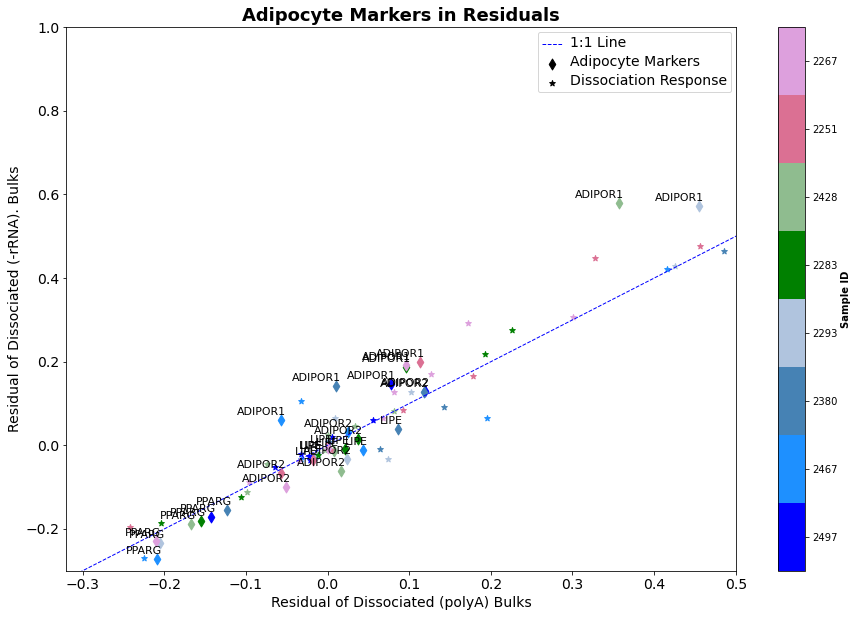

In [53]:
#making copy for numerated index:
res_dissbulks_copy = residuals_dissbulks.copy()
res_bulks_copy = residuals_disspolyabulks.copy()

res_dissbulks_copy.index = range(0,8)
res_bulks_copy.index = range(0,8)

row_indices = sample_ids *2
# Define custom colors
custom_colors = ['blue', 'dodgerblue','steelblue','lightsteelblue','green','darkseagreen', 'palevioletred', 'plum']

# Create a custom colormap
cmap_custom = mcolors.ListedColormap(custom_colors)
marker_size = 100

# Create a scatter plot with labels for multiple genes
plt.figure(figsize=(15, 10))

# Get unique colors for each sample using the previously defined custom colormap
unique_colors = mcolors.ListedColormap(custom_colors)(np.arange(len(res_bulks_copy)))
# Plot each gene for both bulks and dissbulks
for sample_idx, sample_color in enumerate(unique_colors):

    # Plot Adipocyte markers
    for gene in adip_markers:

        gene_data_bulks = res_bulks_copy.at[sample_idx, gene]
        gene_data_dissbulks = res_dissbulks_copy.at[sample_idx, gene]
        marker_size = 60  # Increase size for the first Adipocyte marker
        plt.scatter(gene_data_dissbulks, gene_data_bulks, alpha=1, c=[sample_color], marker='d', s=marker_size,
                    label='Adipocyte Markers' if gene == adip_markers[0] and sample_idx == 0 else "")
        plt.annotate(str(gene), (gene_data_dissbulks, gene_data_bulks), textcoords="offset points", xytext=(5, 5),
                     ha='right', fontsize=11)

    # Plot Dissociation Response genes
    for gene in diss_response:
        gene_data_bulks = res_bulks_copy.at[sample_idx, gene]
        gene_data_dissbulks = res_dissbulks_copy.at[sample_idx, gene]
        plt.scatter(gene_data_dissbulks, gene_data_bulks, alpha=1, c=[sample_color], marker='*',
                    label='Dissociation Response' if gene == diss_response[0] and sample_idx == 0 else "")

# Plot 1:1 Line
plt.plot([-1, 1], [-1, 1], label='1:1 Line', color='blue', linewidth=1, linestyle='--')

# Set axis labels and title
plt.title('Adipocyte Markers in Residuals', fontsize=18, fontname='Arial', fontweight='bold')
plt.ylabel('Residual of Dissociated (-rRNA). Bulks', fontsize=14, fontname='Arial')
plt.xlabel('Residual of Dissociated (polyA) Bulks', fontsize=14, fontname='Arial')

# Add legend
legend = plt.legend()
plt.xlim(-0.32, 0.5)
plt.ylim(-0.3, 1)

ax = plt.gca()
leg = ax.get_legend()
leg.legendHandles[1].set_color('black')
leg.legendHandles[2].set_color('black')

# Set font size and font family for legend
for text in legend.get_texts():
    text.set_fontsize(14)
    text.set_fontname('Arial')

# Set font size for tick labels
plt.xticks(fontsize=14, fontname='Arial')
plt.yticks(fontsize=14, fontname='Arial')
#add colorbar 
sc_ = plt.scatter([], [], c=[], cmap=cmap_custom, marker='d', s=marker_size)
colorbar = plt.colorbar(sc_, ticks=np.arange(len(custom_colors)), label='Sample Index', orientation='vertical')
colorbar.set_label("Sample ID", fontweight='bold')
colorbar.set_ticks([0+1/16,1/8+1/16,2/8+1/16,3/8+1/16,4/8+1/16,5/8+1/16,6/8+1/16,7/8+1/16,8/8+1/16])
colorbar.set_ticklabels(sample_ids)
# Show the plot
plt.show()


## Top Genes per Sample's Residual:

Analyzing the main genes in the Residual of the samples with high adipocyte markers:

In [54]:
# Extract the top genes
top_genes_per_sample_bulk = pd.DataFrame()

for num in range(0,8):

    row = residuals_bulks.values[num, :]  

    # Get the indices of the top 15 genes with the highest expression
    top_10_genes_indices = np.argsort(row)[::-1][:10]

    # Extract the gene names corresponding to the top 15 indices
    gene_names_top_10 = residuals_bulks.columns[top_10_genes_indices]  
    top_genes_per_sample_bulk[num] = gene_names_top_10
top_genes_per_sample_bulk.columns = sample_ids
top_genes_per_sample_bulk                                

2497        2467     2380     2293     2283      2428     2251     2267
0    F13A1    TMEM132C       PC    GABRE     DTX4      ACPP    ITGB4     GPAM
1    STAB1  AC136475.3     LIPE   NUP210    F13A1     GABRE     TEP1      TTN
2  RAPGEF3       GABRE     GPAM     LY75      TTN     CMYA5    ABCC5    PTPRF
3   NBEAL2  MIRLET7BHG    MARC1     HID1  PLEKHG5  B4GALNT3   NBEAL2    ITPR3
4      TTN     TMEM63A      TTN    PTPRS  TMEM63A     CLCN5   ATP8B2   NBEAL2
5    CD163        LY75   PLXNA4    KMT2D      SRC     ITGA9    OBSCN   HEATR1
6    PLCG1     PLEKHA6  TNFSF14   NBEAL2   CEP250    MPPED2    MEGF6  SIGLEC1
7    KMT2D       CIITA   RETSAT  TMEM164    WDR91      DNM1    KMT2D    PTPRS
8     MYRF       OBSCN      PPL     NEO1    STAB1   TSNARE1   AMOTL2    KMT2D
9      CGN      TBC1D2    PTPRF  NADSYN1    OBSCN      CRB2  SIGLEC1   PLXNA4

In [55]:
# Extract the top genes
top_genes_per_sample_dissbulk = pd.DataFrame()

for num in range(0,8):

    row = residuals_dissbulks.values[num, :]

    # Get the indices of the top 15 genes with the highest expression
    top_10_genes_indices = np.argsort(row)[::-1][:10]

    # Extract the gene names corresponding to the top 15 indices
    gene_names_top_10 = residuals_bulks.columns[top_10_genes_indices] 

    top_genes_per_sample_dissbulk[num] = gene_names_top_10
top_genes_per_sample_dissbulk.columns = sample_ids
top_genes_per_sample_dissbulk       

2497     2467     2380    2293     2283     2428    2251      2267
0     STAB1   CELSR1      PPL   OBSCN  TFCP2L1    GABRE     TTN       HK3
1    NBEAL2    OBSCN  TNFSF14   TUFT1  PLEKHG5  TFCP2L1  NBEAL2    NBEAL2
2      MYRF  RAPGEF3    OBSCN  CELSR1     LDB1  NECTIN4   KMT2D    AMOTL2
3     PLCG1    ABCC5    MEGF6   PLCG1    STAB1    OBSCN   ITGA3     KMT2D
4   RAPGEF3   SEMA3B    PTPRF    YOD1   SNHG22     PSD4   PTPRF      PSD4
5    SEC24C   NBEAL2   SEMA3B    PSD4   SEMA7A    PLCG1   PLCG1     THSD4
6    KLHL21     TEP1      TTN  NUP210    OBSCN  PLEKHG3  AMOTL2  ARHGEF17
7  MAPK8IP3    PLCG1    ITGB4  NBEAL2   NBEAL2    TUFT1    H6PD        CP
8     NISCH   MICAL1    KMT2D   KMT2D  TMEM63A     YOD1  KLHL21     LTBP2
9    MFSD2A    KMT2D    ITPR3   LAMB3    WDR91    KMT2D  SH3TC1    CHI3L1

## Distributions of Residuals

Classic (-rRNA) Bulks and Dissociated (-rRNA) Bulks

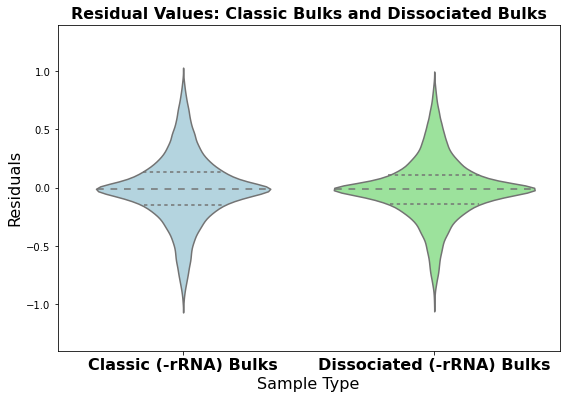

In [56]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
classic_bulks_values = residuals_bulks.values.flatten()
dissociated_bulks_values = residuals_dissbulks.values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Classic Bulks'] * len(classic_bulks_values) +
                                  ['Dissociated Bulks'] * len(dissociated_bulks_values),
                   'Residuals': np.concatenate([classic_bulks_values, dissociated_bulks_values])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals', data=df, ax=ax, inner='quartile', palette=['lightblue', 'lightgreen'])

# Add labels to the x-axis
ax.set_xticklabels(['Classic (-rRNA) Bulks', 'Dissociated (-rRNA) Bulks'], fontsize=16, fontweight='bold', fontname='Arial')

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals', fontsize=16, fontname='Arial')
plt.title('Residual Values: Classic Bulks and Dissociated Bulks', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.4)
plt.show()

#These plots look very similar: could be due to certain genes being high in one distribution but low in the other one, 
#and the other way around, making them look visually the same but it's a different set of genes driving the high and lows.

Dissociated (polyA) Bulks and Dissociated (-rRNA) Bulks

In [57]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
bulk_type_1 = residuals_disspolyabulks.values.flatten()
bulk_type_2 = residuals_dissbulks.values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Bulktype1'] * len(bulk_type_1) +
                                  ['Bulktype2'] * len(bulk_type_2),
                   'Residuals': np.concatenate([bulk_type_1, bulk_type_2])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals', data=df, ax=ax, inner='quartile', palette=[ 'lightpink','lightgreen'])
# Add labels to the x-axis
ax.set_xticklabels(['Dissociated (polyA) Bulks', 'Dissociated (-rRNA) Bulks'], fontsize=16, fontweight='bold', fontname='Arial')

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals', fontsize=16, fontname='Arial')
plt.title('Residual Values', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.4)
plt.show()

#These plots look very similar: could be due to certain genes being high in one distribution but low in the other one, 
#and the other way around, making them look visually the same but it's a different set of genes driving the high and lows.

**Distributions: Only Adipocyte Markers**

Classic (-rRNA) Bulks and Dissociated (-rRNA) Bulks

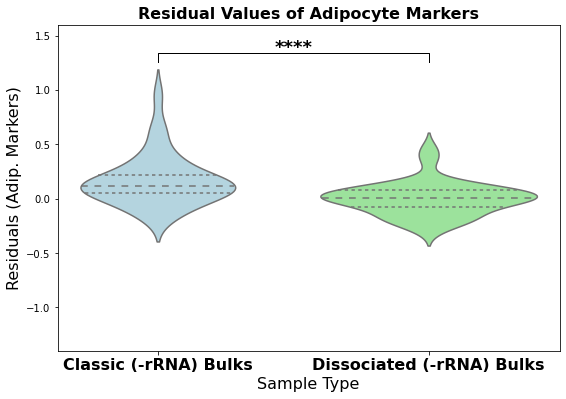

In [58]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
adip_intersect = np.intersect1d(residuals_bulks.columns, adip_markers)

bulk_type_1 = residuals_bulks[adip_intersect].values.flatten()
bulk_type_2 = residuals_dissbulks[adip_intersect].values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Bulktype1'] * len(bulk_type_1) +
                                  ['Bulktype2'] * len(bulk_type_2),
                   'Residuals (Adip. Markers)': np.concatenate([bulk_type_1, bulk_type_2])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals (Adip. Markers)', data=df, ax=ax, inner='quartile', palette=['lightblue','lightgreen'])

# Add labels to the x-axis
ax.set_xticklabels(['Classic (-rRNA) Bulks', 'Dissociated (-rRNA) Bulks'], fontsize=16, fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
# Perform the paired t-test
t_statistic, p_value = stats.wilcoxon(bulk_type_1, bulk_type_2)

# Set a significance level (e.g., 0.05)
alpha = 0.05
#getting maximum value for significance line:
max_val = np.max([max(bulk_type_1), max(bulk_type_2)])

# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value, 3)} (p < 0.05)"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 0.3, max_val+0.38
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, (x1 + x2) / 2, x2, x2], [y1, y2, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2-0.03 , asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value, 3)}"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 0.15, max_val+0.22
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2, s='N.S.', ha='center', va='bottom', fontsize=12, fontname='Arial')
    # No asterisks for non-significant results

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals (Adip. Markers)', fontsize=16, fontname='Arial')
plt.title('Residual Values of Adipocyte Markers', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.6)
plt.show()

Dissociated (-rRNA) Bulks and Dissociated (polyA) Bulks

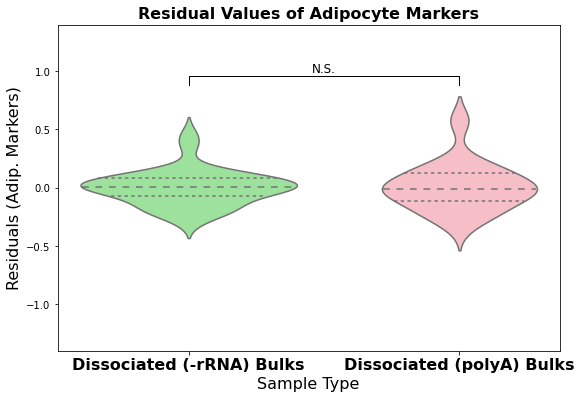

In [59]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
adip_intersect = np.intersect1d(residuals_bulks.columns, adip_markers)

bulk_type_1 = residuals_dissbulks[adip_intersect].values.flatten()
bulk_type_2 = residuals_disspolyabulks[adip_intersect].values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Classic Bulks'] * len(bulk_type_1) +
                                  ['Dissociated Bulks'] * len(bulk_type_2),
                   'Residuals (Adip. Markers)': np.concatenate([bulk_type_1, bulk_type_2])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals (Adip. Markers)', data=df, ax=ax, inner='quartile', palette=['lightgreen', 'lightpink'])

# Add labels to the x-axis
ax.set_xticklabels(['Dissociated (-rRNA) Bulks', 'Dissociated (polyA) Bulks'], fontsize=16, fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
# Perform the paired t-test
t_statistic, p_value = stats.wilcoxon(bulk_type_1, bulk_type_2)

# Set a significance level (e.g., 0.05)
alpha = 0.05
#getting maximum value for significance line:
max_val = np.max([max(bulk_type_1), max(bulk_type_2)])

# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value, 3)} (p < 0.05)"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 0.3, max_val+0.38# Adjusted higher y-coordinate
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, (x1 + x2) / 2, x2, x2], [y1, y2, y2 + 0.1, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2 , asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value, 3)}"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 0.3, max_val+0.38
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2, s='N.S.', ha='center', va='bottom', fontsize=12, fontname='Arial')
    # No asterisks for non-significant results

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals (Adip. Markers)', fontsize=16, fontname='Arial')
plt.title('Residual Values of Adipocyte Markers', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.4)
plt.show()


Classic (-rRNA) Bulks and Dissociated (polyA) Bulks

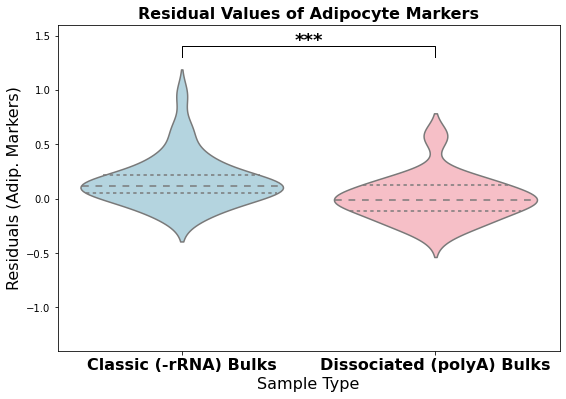

In [60]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
adip_intersect = np.intersect1d(residuals_bulks.columns, adip_markers)

classic_bulks_values = residuals_bulks[adip_intersect].values.flatten()
dissociated_bulks_values = residuals_disspolyabulks[adip_intersect].values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Bulktype1'] * len(classic_bulks_values) +
                                  ['Bulktype2'] * len(dissociated_bulks_values),
                   'Residuals (Adip. Markers)': np.concatenate([classic_bulks_values, dissociated_bulks_values])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals (Adip. Markers)', data=df, ax=ax, inner='quartile', palette=['lightblue', 'lightpink'])

# Add labels to the x-axis
ax.set_xticklabels(['Classic (-rRNA) Bulks', 'Dissociated (polyA) Bulks'], fontsize=16, fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
# Perform the paired t-test
t_statistic, p_value = stats.wilcoxon(classic_bulks_values, dissociated_bulks_values)

# Set a significance level (e.g., 0.05)
alpha = 0.05

#getting maximum value for significance line:
max_val = np.max([max(bulk_type_1), max(bulk_type_2)])
# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value, 3)} (p < 0.05)"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = 1.3, 1.4 # Adjusted higher y-coordinate
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, (x1 + x2) / 2, x2, x2], [y1, y2, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2-0.03 , asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value, 3)}"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = 1.6, 1.7
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2, s='N.S.', ha='center', va='bottom', fontsize=12, fontname='Arial')
    # No asterisks for non-significant results

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals (Adip. Markers)', fontsize=16, fontname='Arial')
plt.title('Residual Values of Adipocyte Markers', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.6)
plt.show()

**Distributions: Only Dissociation Markers**

Classic (-rRNA) Bulks and Dissociated (-rRNA) Bulks

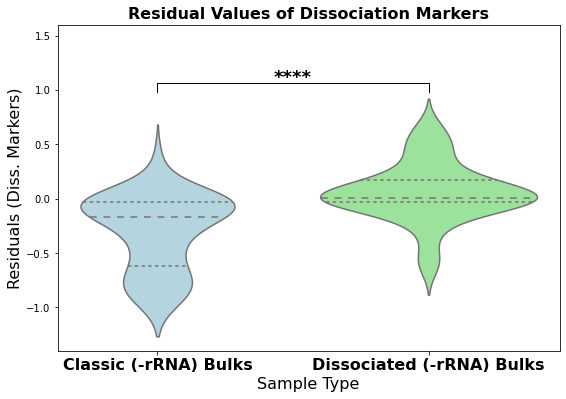

In [61]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
adip_intersect = np.intersect1d(residuals_bulks.columns, diss_response)

bulk_type_1 = residuals_bulks[adip_intersect].values.flatten()
bulk_type_2 = residuals_dissbulks[adip_intersect].values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Bulktype1'] * len(bulk_type_1) +
                                  ['Bulktype2'] * len(bulk_type_2),
                   'Residuals (Diss. Markers)': np.concatenate([bulk_type_1, bulk_type_2])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals (Diss. Markers)', data=df, ax=ax, inner='quartile', palette=['lightblue', 'lightgreen'])

# Add labels to the x-axis
ax.set_xticklabels(['Classic (-rRNA) Bulks', 'Dissociated (-rRNA) Bulks'], fontsize=16, fontname='Arial', fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
# Perform the paired t-test
t_statistic, p_value = stats.wilcoxon(bulk_type_1, bulk_type_2)

# Set a significance level (e.g., 0.05)
alpha = 0.05
#getting maximum value for significance line:
max_val = np.max([max(bulk_type_1), max(bulk_type_2)])
# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value, 3)} (p < 0.05)"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 0.3, max_val+0.38
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2-0.03, asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value, 3)}"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = 1.6, 1.7
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2, s='N.S.', ha='center', va='bottom', fontsize=12, fontname='Arial')
    # No asterisks for non-significant results
    
plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals (Diss. Markers)', fontsize=16, fontname='Arial')
plt.title('Residual Values of Dissociation Markers', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.6)
plt.show()


In [62]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
diss_intersect = np.intersect1d(residuals_bulks.columns, diss_response)

bulk_type_1 = residuals_dissbulks[diss_intersect].values.flatten()
bulk_type_2 = residuals_disspolyabulks[diss_intersect].values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Classic Bulks'] * len(bulk_type_1) +
                                  ['Dissociated Bulks'] * len(bulk_type_2),
                   'Residuals (diss. Markers)': np.concatenate([bulk_type_1, bulk_type_2])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals (diss. Markers)', data=df, ax=ax, inner='quartile', palette=['lightgreen', 'lightpink'])

# Add labels to the x-axis
ax.set_xticklabels(['Dissociated (-rRNA) Bulks', 'Dissociated (polyA) Bulks'], fontsize=16, fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
# Perform the paired t-test
t_statistic, p_value = stats.wilcoxon(bulk_type_1, bulk_type_2)

# Set a significance level (e.g., 0.05)
alpha = 0.05
#getting maximum value for significance line:
max_val = np.max([max(bulk_type_1), max(bulk_type_2)])
# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value, 3)} (p < 0.05)"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 0.3, max_val+0.38
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, (x1 + x2) / 2, x2, x2], [y1, y2, y2 + 0.1, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2 , asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value, 3)}"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 0.3, max_val+0.38
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2, s='N.S.', ha='center', va='bottom', fontsize=12, fontname='Arial')
    # No asterisks for non-significant results

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals (Diss. Markers)', fontsize=16, fontname='Arial')
plt.title('Residual Values of Dissociation Markers', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.4)
plt.show()

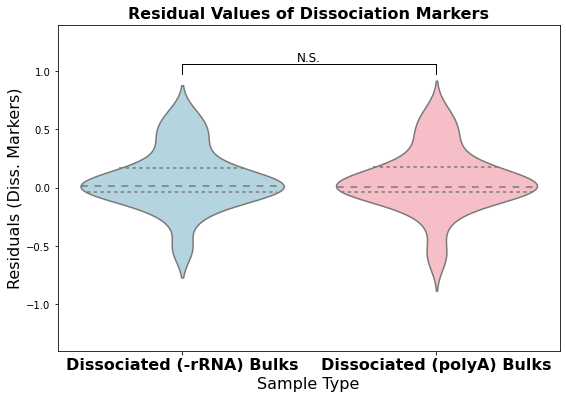

In [63]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
diss_intersect = np.intersect1d(residuals_bulks.columns, diss_response)

bulk_type_1 = residuals_disspolyabulks[diss_intersect].values.flatten()
bulk_type_2 = residuals_dissbulks[diss_intersect].values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Classic Bulks'] * len(bulk_type_1) +
                                  ['Dissociated Bulks'] * len(bulk_type_2),
                   'Residuals (diss. Markers)': np.concatenate([bulk_type_1, bulk_type_2])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals (diss. Markers)', data=df, ax=ax, inner='quartile', palette=['lightblue', 'lightpink'])

# Add labels to the x-axis
ax.set_xticklabels(['Dissociated (-rRNA) Bulks', 'Dissociated (polyA) Bulks'], fontsize=16, fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
# Perform the paired t-test
t_statistic, p_value = stats.wilcoxon(bulk_type_1, bulk_type_2)

# Set a significance level (e.g., 0.05)
alpha = 0.05
#getting maximum value for significance line:
max_val = np.max([max(bulk_type_1), max(bulk_type_2)])
# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value, 3)} (p < 0.05)"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 0.3, max_val+0.38
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, (x1 + x2) / 2, x2, x2], [y1, y2, y2 + 0.1, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2 , asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value, 3)}"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 0.3, max_val+0.38
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2, s='N.S.', ha='center', va='bottom', fontsize=12, fontname='Arial')
    # No asterisks for non-significant results

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals (Diss. Markers)', fontsize=16, fontname='Arial')
plt.title('Residual Values of Dissociation Markers', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.4)
plt.show()

## PCA

Combo (Classic and Dissociated (-rRNA together))

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


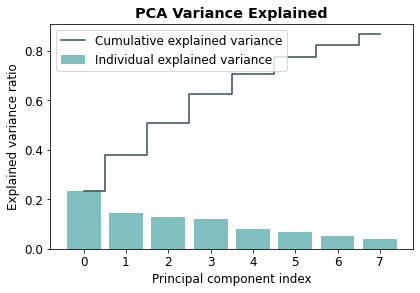

Component_0 Component_1 Component_2 Component_3 Component_4 Component_5  \
0          VTCN1     FAM107A        GPAM       F13A1      KIF26B       LAMA3   
1          PELI2        IRS2        SAA1         PPL       INHBA        NAV2   
2        ZNF780B      MFSD2A      PLXNA4       DAPK1      PDLIM3       NRXN3   
3        TMEM63A    ANKRD33B      CLSTN2      KCNMA1       UNC5B  AC136475.3   
4         SPINT2      B3GNT5        ACO1        SDC1     BHLHE41      RASSF8   
...          ...         ...         ...         ...         ...         ...   
4579         IL6      BTN3A2       DUSP2       IGHG1        ESR1       PELI2   
4580       CXCL8      BTN3A1        PLK2      FBXO32        CCL2      PGRMC1   
4581        RND3       BIRC3         BGN        IGKC       MECOM       SESN3   
4582       CLDN1        LY75  AC245014.3      IFITM1         ADM      NUP210   
4583     ALDH1A3         EHF       SMAD7      CHI3L1       THSD4       PTGDS   

     Component_6 Component_7  
0          CLDN1        EYA2  
1          MYH11      RNF152  
2         KCNMA1        CDH6  
3          MERTK        ESR1  
4          IGLC3      SLC7A2  
...          ...         ...  
4579        PPA1        KLK7  
4580      TUBA1B      SPINT2  
4581       STMN1         CGN  
4582        CD36        ASS1  
4583       ERAP2       KRT19  

[4584 rows x 8 columns]

In [64]:
# Set font to Arial
font = {'family': 'Arial', 'weight': 'normal', 'size': 12}
plt.rc('font', **font)
num_pca_components_combo = 8
pca_res = dict()
df = residuals_combo  # transposing to get length of genes instead of samples
pca_fit = PCA(n_components=num_pca_components_combo)
pca_results = pca_fit.fit_transform(df.values)

exp_var_pca = pca_fit.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

# Plot variance explained
plt.bar(range(0, len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', color='teal', label='Individual explained variance')
plt.step(range(0, len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid', color='darkslategrey', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.title("PCA Variance Explained", fontweight='bold')
plt.show()

# PCA Visualization
plt.scatter(pca_results[:, 0], pca_results[:, 2], label="Classic Bulks", c='steelblue', marker='s', s=marker_size)
plt.legend()
plt.title("PCA Visualization of the Residuals", fontweight='bold')
plt.xlabel("PC0")
plt.ylabel("PC2")
plt.show()

# 'residuals_all.columns' contains the names of the genes
comp_genes= []
pca_genes = pd.DataFrame()
# Iterate through each component
for component_idx in range(num_pca_components_combo):
    # Calculate loadings for the current component
    loadings = pca_fit.components_.T * np.sqrt(pca_fit.explained_variance_)

    # Sort genes by their influence on the current component
    sorted_genes = residuals_bulks.columns[np.argsort(loadings[:, component_idx])]

    # Visualize the top N genes that contribute the most to the current component
    N = pca_fit.components_.shape[1]
    top_genes = sorted_genes[-N:]

    pca_genes[component_idx] = top_genes[::-1]
    comp_genes = np.append(comp_genes, top_genes)
pca_genes.columns = ["Component_0","Component_1","Component_2", "Component_3",
                     "Component_4",  "Component_5", "Component_6", "Component_7"]                      
pca_genes   


In [65]:
# Separate the first and last 8 samples (by sample type)
first_half_samples = pca_results[:8]
second_half_samples = pca_results[-8:]

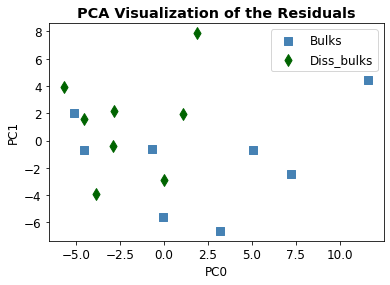

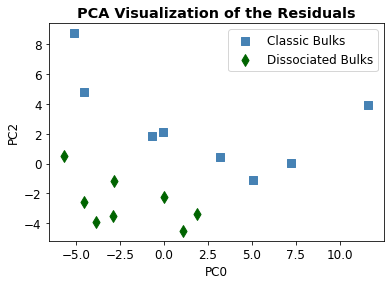

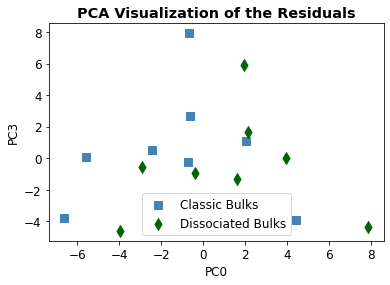

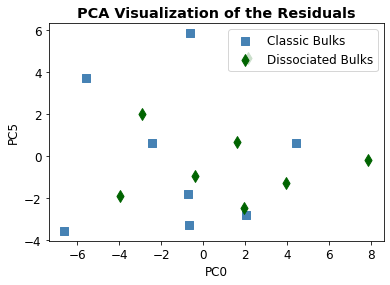

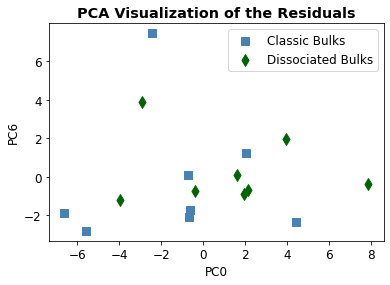

In [66]:
marker_size = 70

# Set font to Arial
font = {'family': 'Arial', 'weight': 'normal', 'size': 12}
plt.rc('font', **font)

# PCA Visualization of the Residuals
plt.scatter(first_half_samples[:, 0], first_half_samples[:, 1], label="Bulks", c='steelblue', marker='s', s=marker_size)
plt.scatter(second_half_samples[:, 0], second_half_samples[:, 1], label="Diss_bulks", c='darkgreen', marker='d', s=marker_size)
plt.legend()
plt.title("PCA Visualization of the Residuals", fontweight='bold')
plt.xlabel("PC0")
plt.ylabel("PC1")
plt.show()

# PCA Visualization
plt.scatter(first_half_samples[:, 0], first_half_samples[:, 2], label="Classic Bulks", c='steelblue', marker='s', s=marker_size)
plt.scatter(second_half_samples[:, 0], second_half_samples[:, 2], label="Dissociated Bulks", c='darkgreen', marker='d', s=marker_size)
plt.legend()
plt.title("PCA Visualization of the Residuals", fontweight='bold')
plt.xlabel("PC0")
plt.ylabel("PC2")
plt.show()

# PCA Visualization
plt.scatter(first_half_samples[:, 1], first_half_samples[:, 3], label="Classic Bulks", c='steelblue', marker='s', s=marker_size)
plt.scatter(second_half_samples[:, 1], second_half_samples[:, 3], label="Dissociated Bulks", c='darkgreen', marker='d', s=marker_size)
plt.legend()
plt.title("PCA Visualization of the Residuals", fontweight='bold')
plt.xlabel("PC0")
plt.ylabel("PC3")
plt.show()

# PCA Visualization
plt.scatter(first_half_samples[:, 1], first_half_samples[:, 4], label="Classic Bulks", c='steelblue', marker='s', s=marker_size)
plt.scatter(second_half_samples[:, 1], second_half_samples[:, 4], label="Dissociated Bulks", c='darkgreen', marker='d', s=marker_size)
plt.legend()
plt.title("PCA Visualization of the Residuals", fontweight='bold')
plt.xlabel("PC0")
plt.ylabel("PC5")
plt.show()

# PCA Visualization
plt.scatter(first_half_samples[:, 1], first_half_samples[:, 5], label="Classic Bulks", c='steelblue', marker='s', s=marker_size)
plt.scatter(second_half_samples[:, 1], second_half_samples[:, 5], label="Dissociated Bulks", c='darkgreen', marker='d', s=marker_size)
plt.legend()
plt.title("PCA Visualization of the Residuals", fontweight='bold')
plt.xlabel("PC0")
plt.ylabel("PC6")
plt.show()



findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


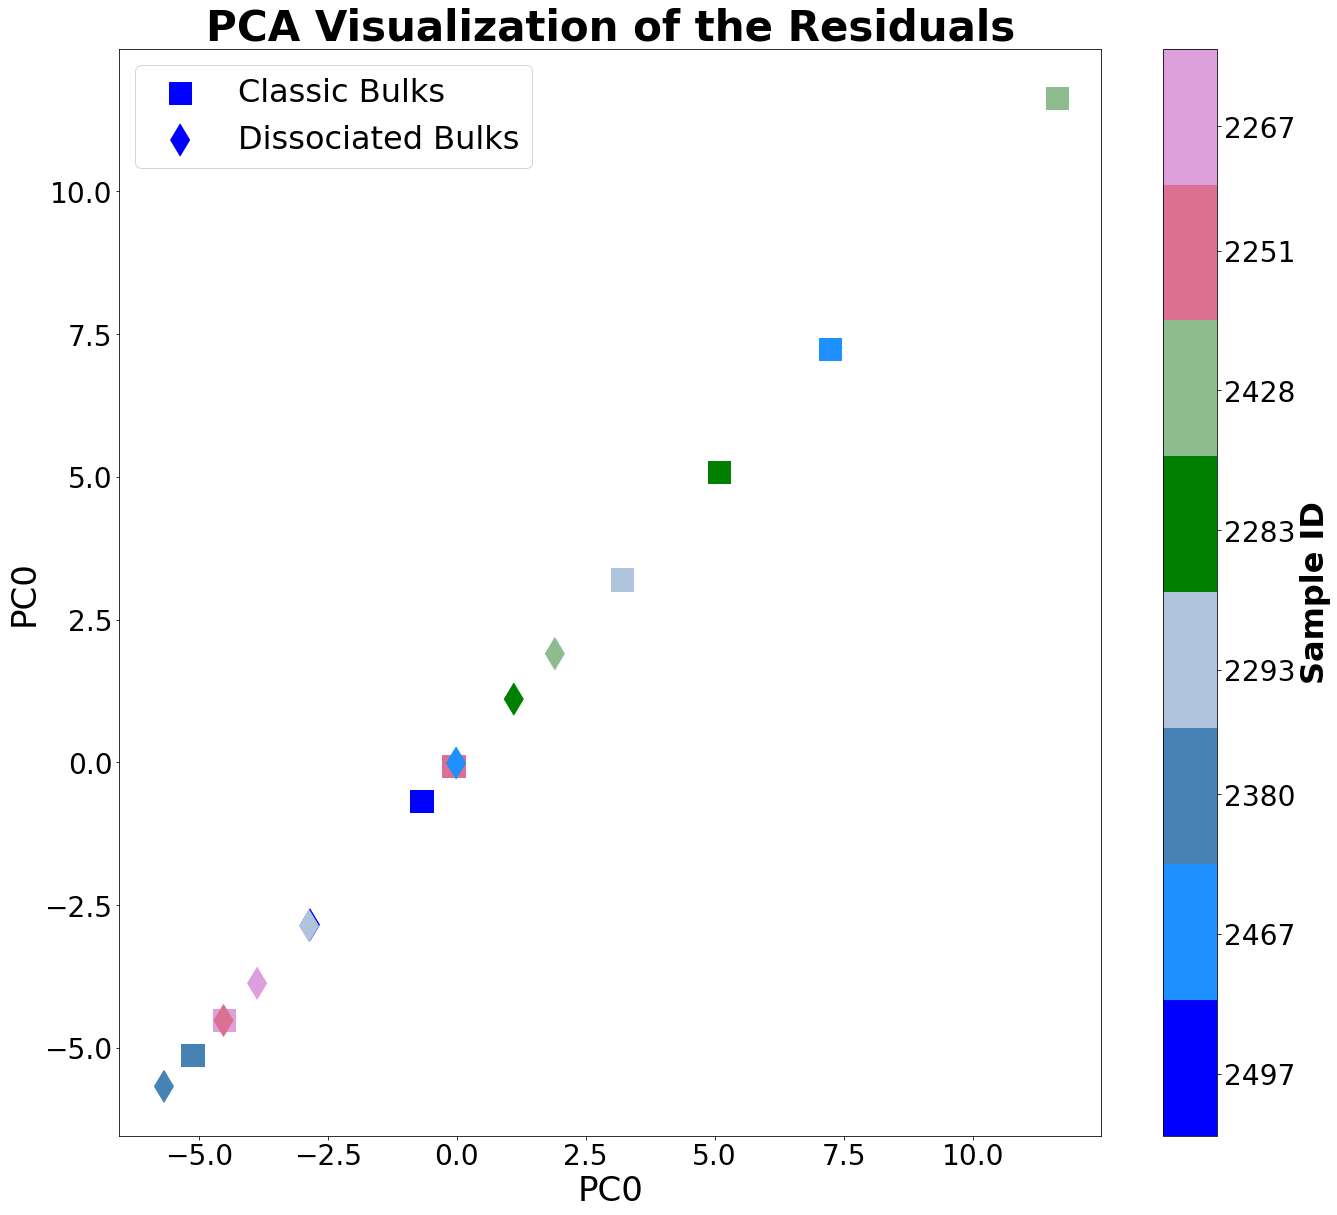

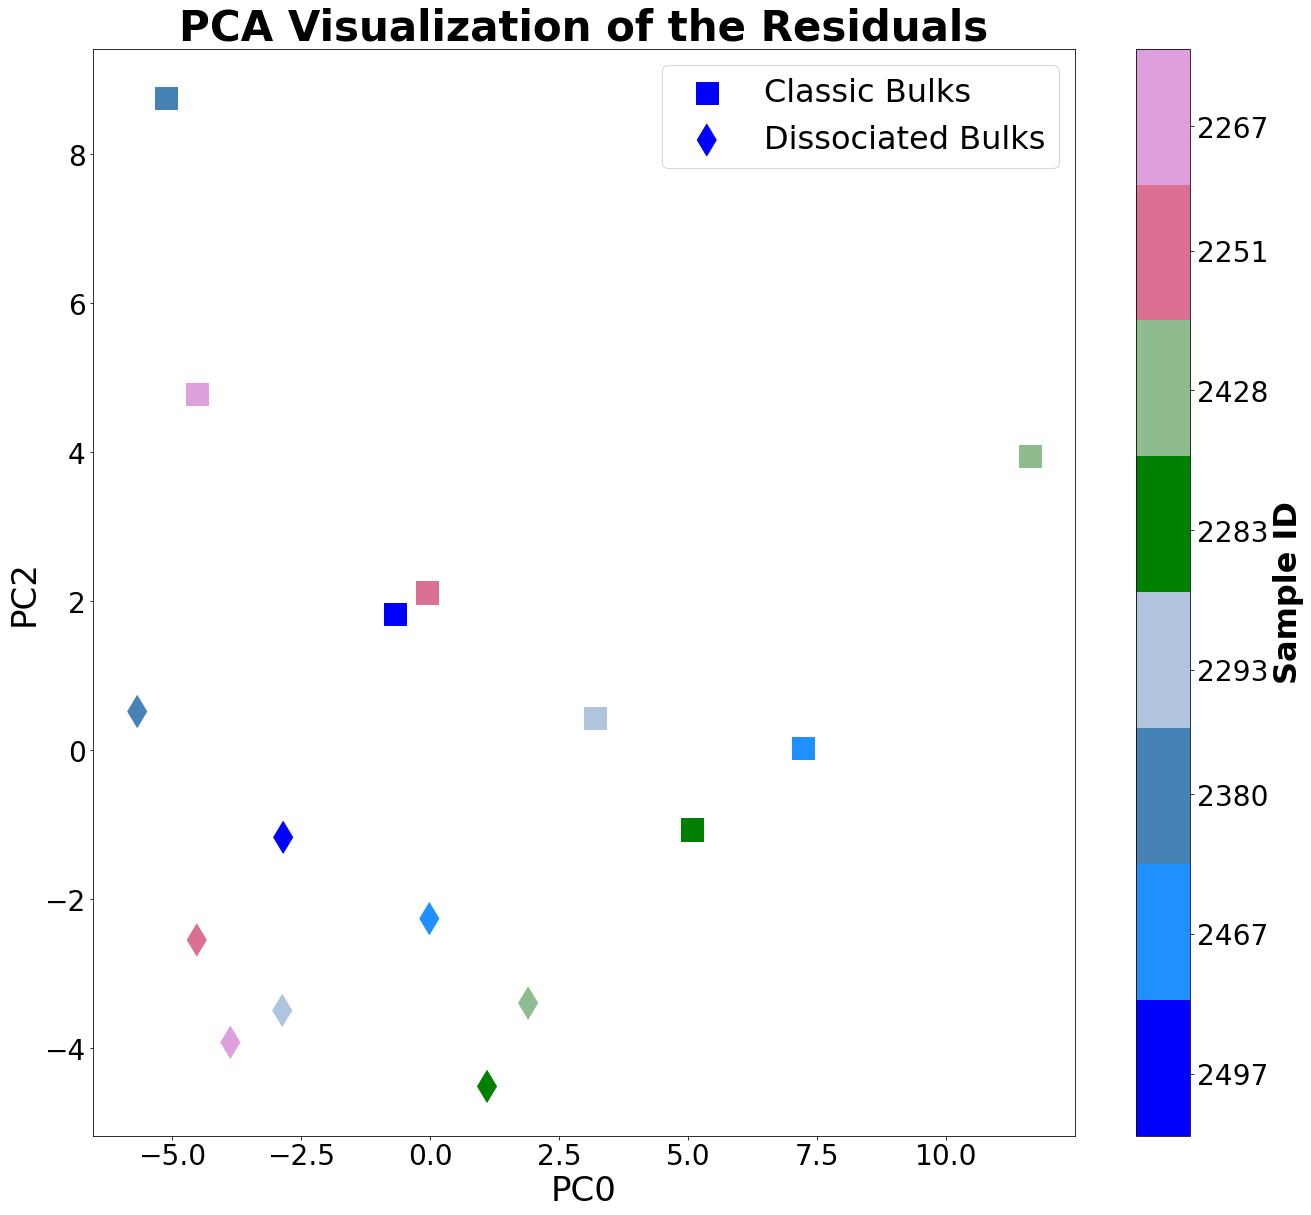

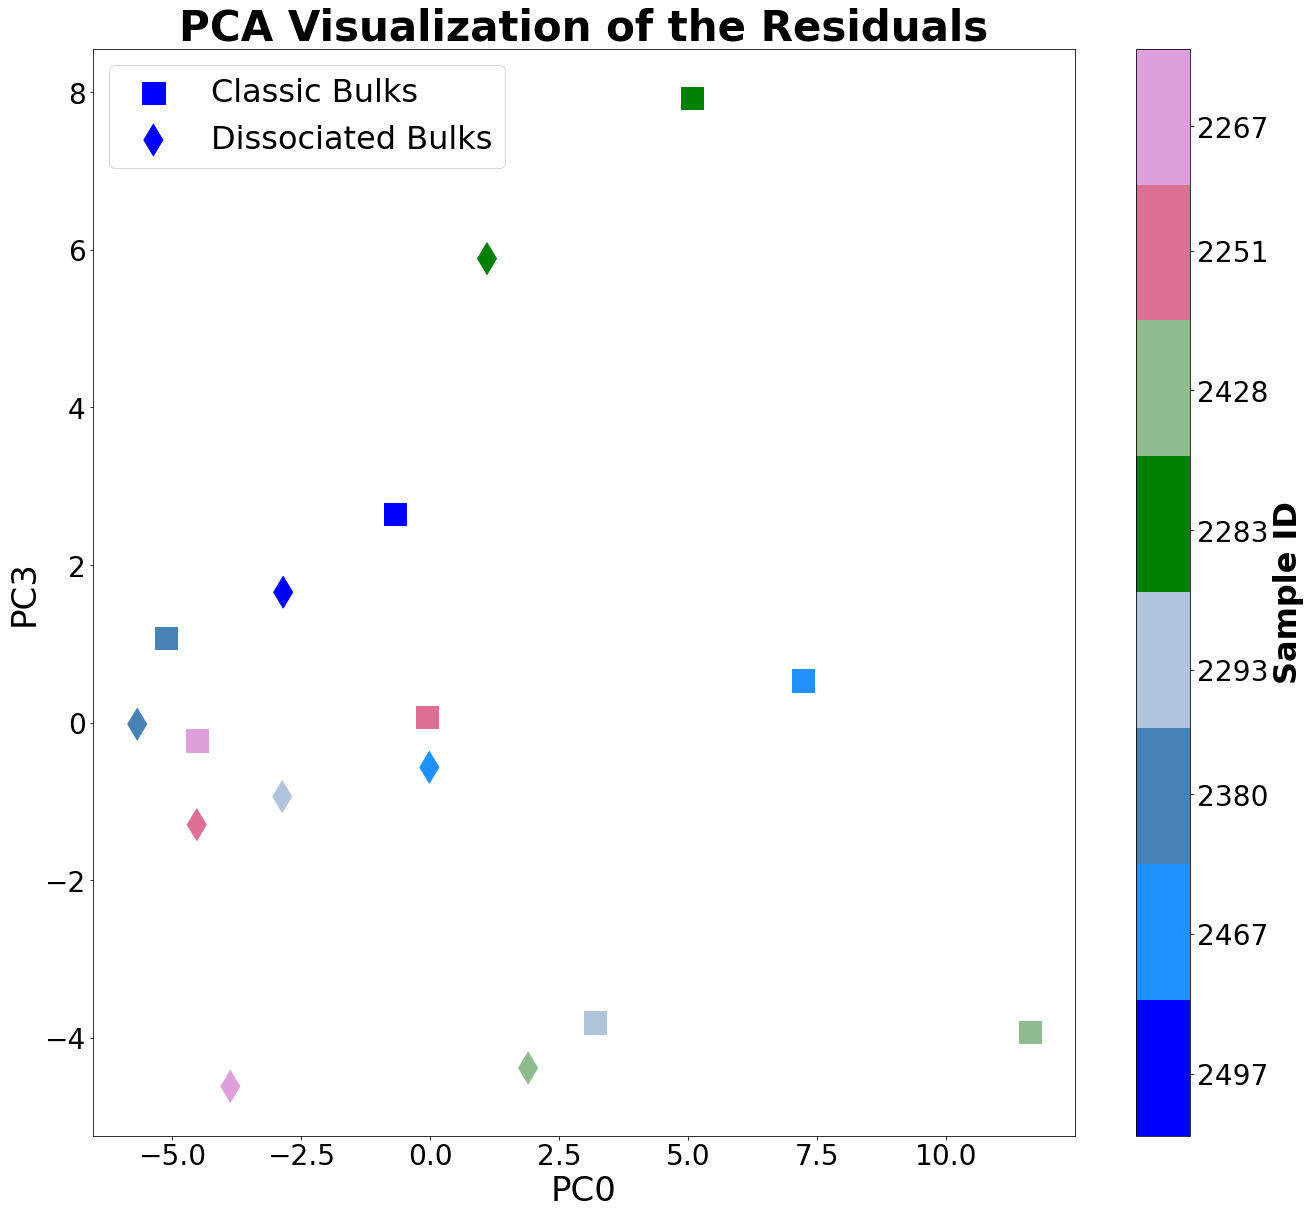

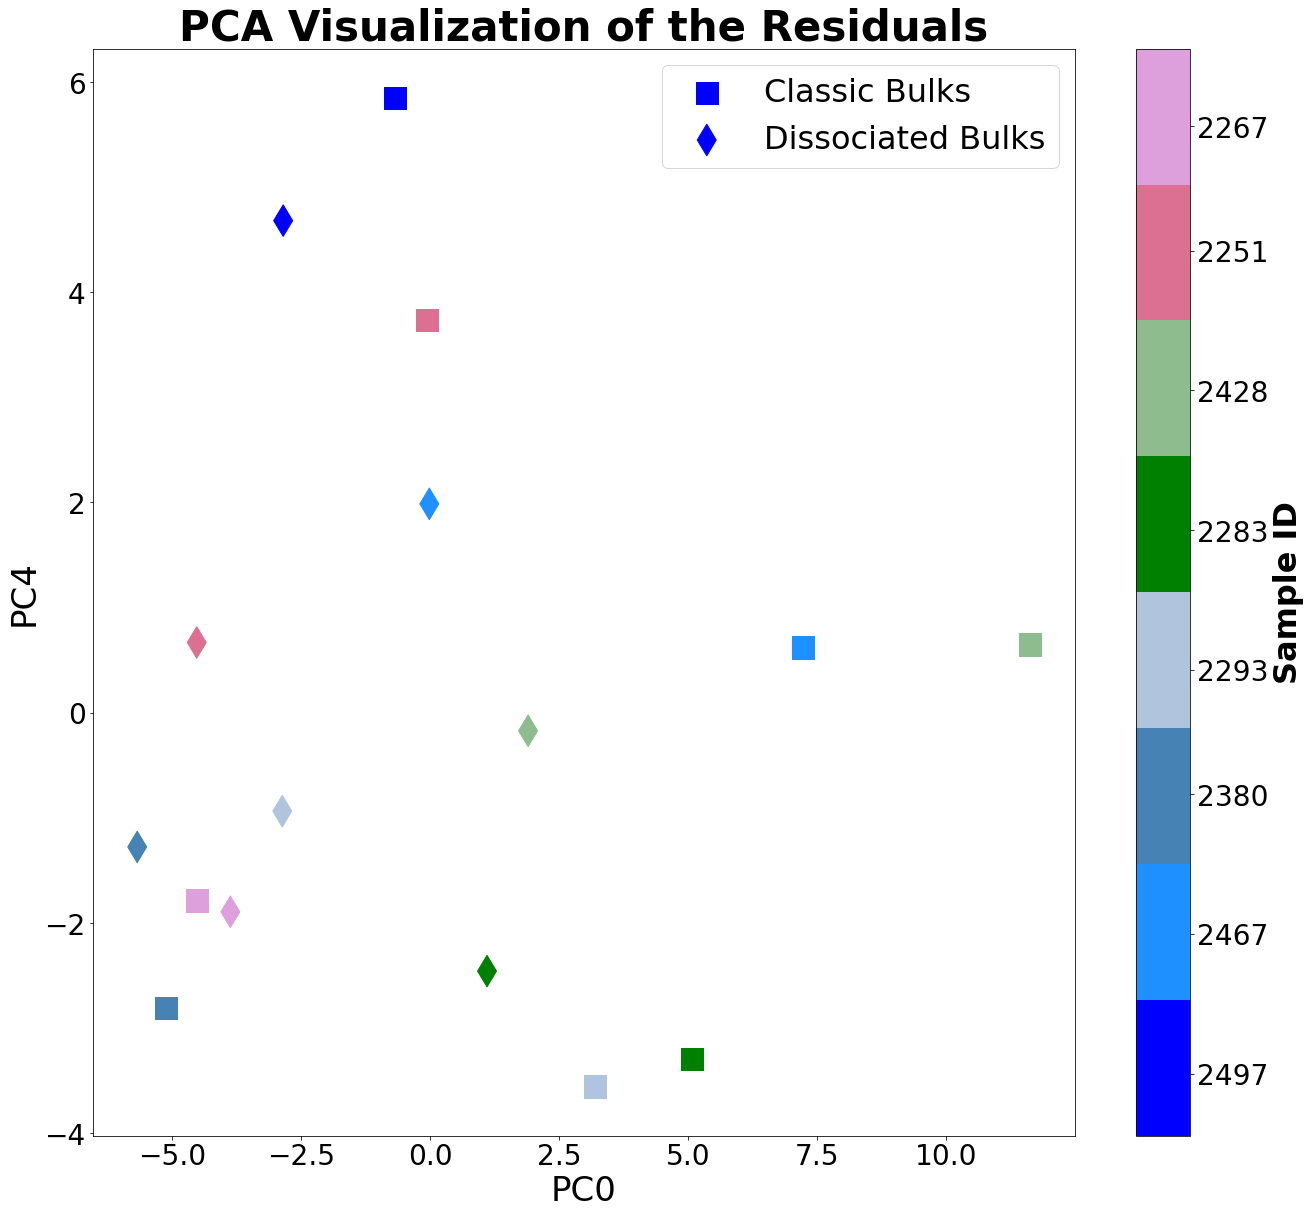

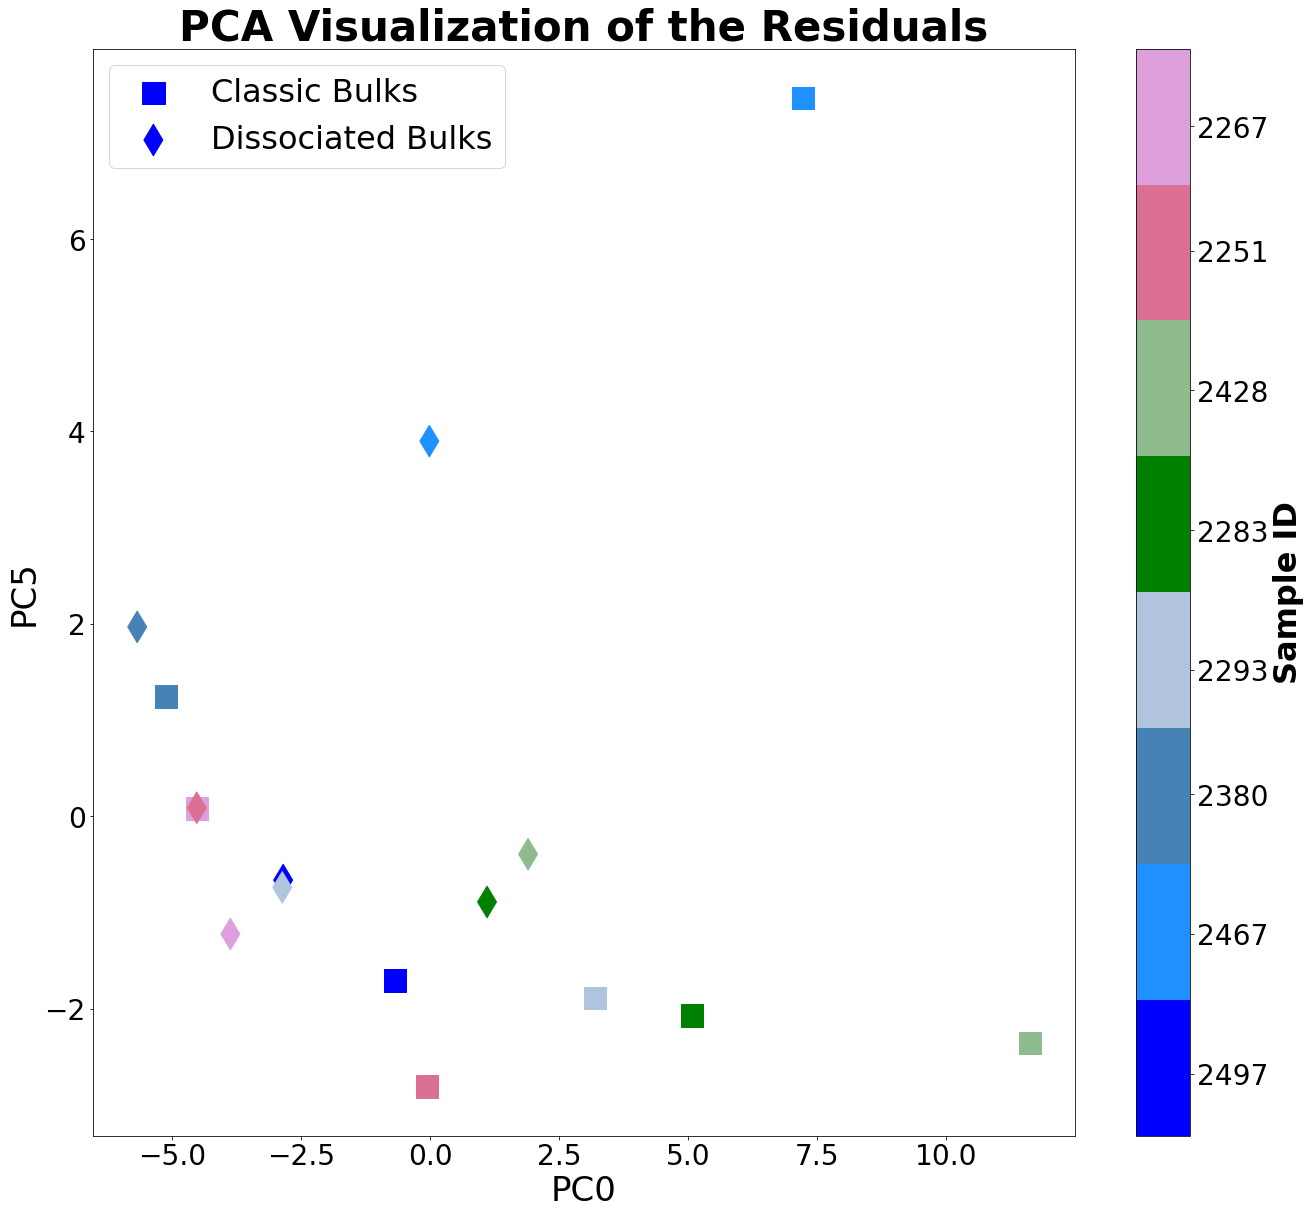

In [67]:
for idx in [0,1,2,3,4,5,6,7]:
    # Assuming `row_indices` contains the row indices of your samples
    row_indices = np.tile(range(1, 9), 2)
    plt.figure(figsize = (22,20))
    # Define custom colors
    custom_colors = ['blue','dodgerblue','steelblue','lightsteelblue','green','darkseagreen','palevioletred','plum']

    # Create a custom colormap
    cmap_custom = mcolors.ListedColormap(custom_colors)
    marker_size = 500

    # PCA Visualization
    scatter1 = plt.scatter(first_half_samples[:, 0], first_half_samples[:, idx], label="Classic Bulks", c=row_indices[:len(first_half_samples)], 
                                cmap=cmap_custom, marker='s', s=marker_size)
    scatter2 = plt.scatter(second_half_samples[:, 0], second_half_samples[:, idx], label="Dissociated Bulks", c=row_indices[len(first_half_samples):], 
                                cmap=cmap_custom, marker='d', s=marker_size)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    # Add colorbar for reference
    cbar = plt.colorbar()
    cbar.set_label('Sample ID', fontsize=32, fontweight='bold')

    # Adjust colorbar ticks to be centered between colors
    cbar.set_ticks([1.4, 2.3 ,3.2 ,4, 4.9 , 5.8 ,6.7 ,7.5])
    cbar.set_ticklabels(sample_ids )
    cbar.ax.tick_params(labelsize=28)
    # Change the color of the little marker in the legend
    legend = plt.legend(fontsize=32)

    plt.title("PCA Visualization of the Residuals", fontweight='bold', fontsize=42, fontname='Arial')
    plt.xlabel("PC0", fontsize=34, fontname='Arial')
    plt.ylabel(f"PC{idx}", fontsize=34, fontname='Arial')
    plt.show()

In [68]:
# Separate the data into "classic bulks" and "dissociated bulks"
df = pd.DataFrame(pca_results)
classic_bulks = df.iloc[:8, :]
dissociated_bulks = df.iloc[8:, :]

# Perform t-test for each component
results = pd.DataFrame(columns=['Component', 'T-Statistic', 'P-Value'])

for column in df.columns:
    t_statistic, p_value = stats.ttest_ind(classic_bulks[column], dissociated_bulks[column])
    results = results.append({'Component': column, 'T-Statistic': t_statistic, 'P-Value': p_value}, ignore_index=True)

# Print the results
print(results)

# Identify components with significantly different means
significantly_different = results[results['P-Value'] < 0.05]
print("Components with significantly different means:")
print(significantly_different)

   Component  T-Statistic   P-Value
0        0.0     1.845847  0.086165
1        1.0    -1.387722  0.186914
2        2.0     4.130653  0.001019
3        3.0     0.601235  0.557294
4        4.0    -0.101416  0.920658
5        5.0    -0.377121  0.711739
6        6.0    -0.291471  0.774965
7        7.0    -0.042513  0.966690
Components with significantly different means:
   Component  T-Statistic   P-Value
2        2.0     4.130653  0.001019


In [69]:
# Bar plot for each component
plt.figure(figsize=(20, 10))
plt.bar(results['Component'], -np.log10(results['P-Value']), color='teal', alpha=0.5)
plt.xlabel('PCA Component Number', fontsize=32, fontname='Arial')
plt.ylabel('-log10(P-Value)', fontsize=32, fontname='Arial')
plt.plot([-1,0,1,2,3,4,5,6,7,8],np.repeat(-np.log10(0.005),10),linestyle='--', label='p-val=0.005')
plt.title('PCA: Difference per Component between \nClassic Bulks and Dissociated Bulks (-rRNA)', 
            fontsize=34, fontname='Arial', fontweight='bold')
plt.xticks([0,1,2,3,4,5,6,7], fontsize=28)
plt.yticks(fontsize=26)
plt.ylim(0,max(-np.log10(results['P-Value']))+0.07)
plt.legend(fontsize=26)
plt.xlim(-0.5,7.5)
plt.show()

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


And evaluating the GOrilla results (of combo residual):

In [70]:
# The sheets on the Excel
#for figure sized
num=0
if add_adipo:
    added = "PCA_genes_residuals_combo_ADIP.xlsx"
else:
    added ="PCA_genes_residuals_combo.xlsx"
sheet_names = ['Component_0','Component_1','Component_2','Component_3', 'Component_4', 'Component_5', 'Component_6', 'Component_7']  

In [71]:
#and exporting PCA genes per component for gene ontology analysis.

''' NOTE: You'll need to run GOrilla on these lists for the next part!'''
pca_name_path = Path(f"{os.getcwd()}/../results/EXP5/", f"{added}")
pca_genes.to_excel(pca_name_path, sheet_name = "PCA_Components_Genes")

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


filtered: (20, 11)


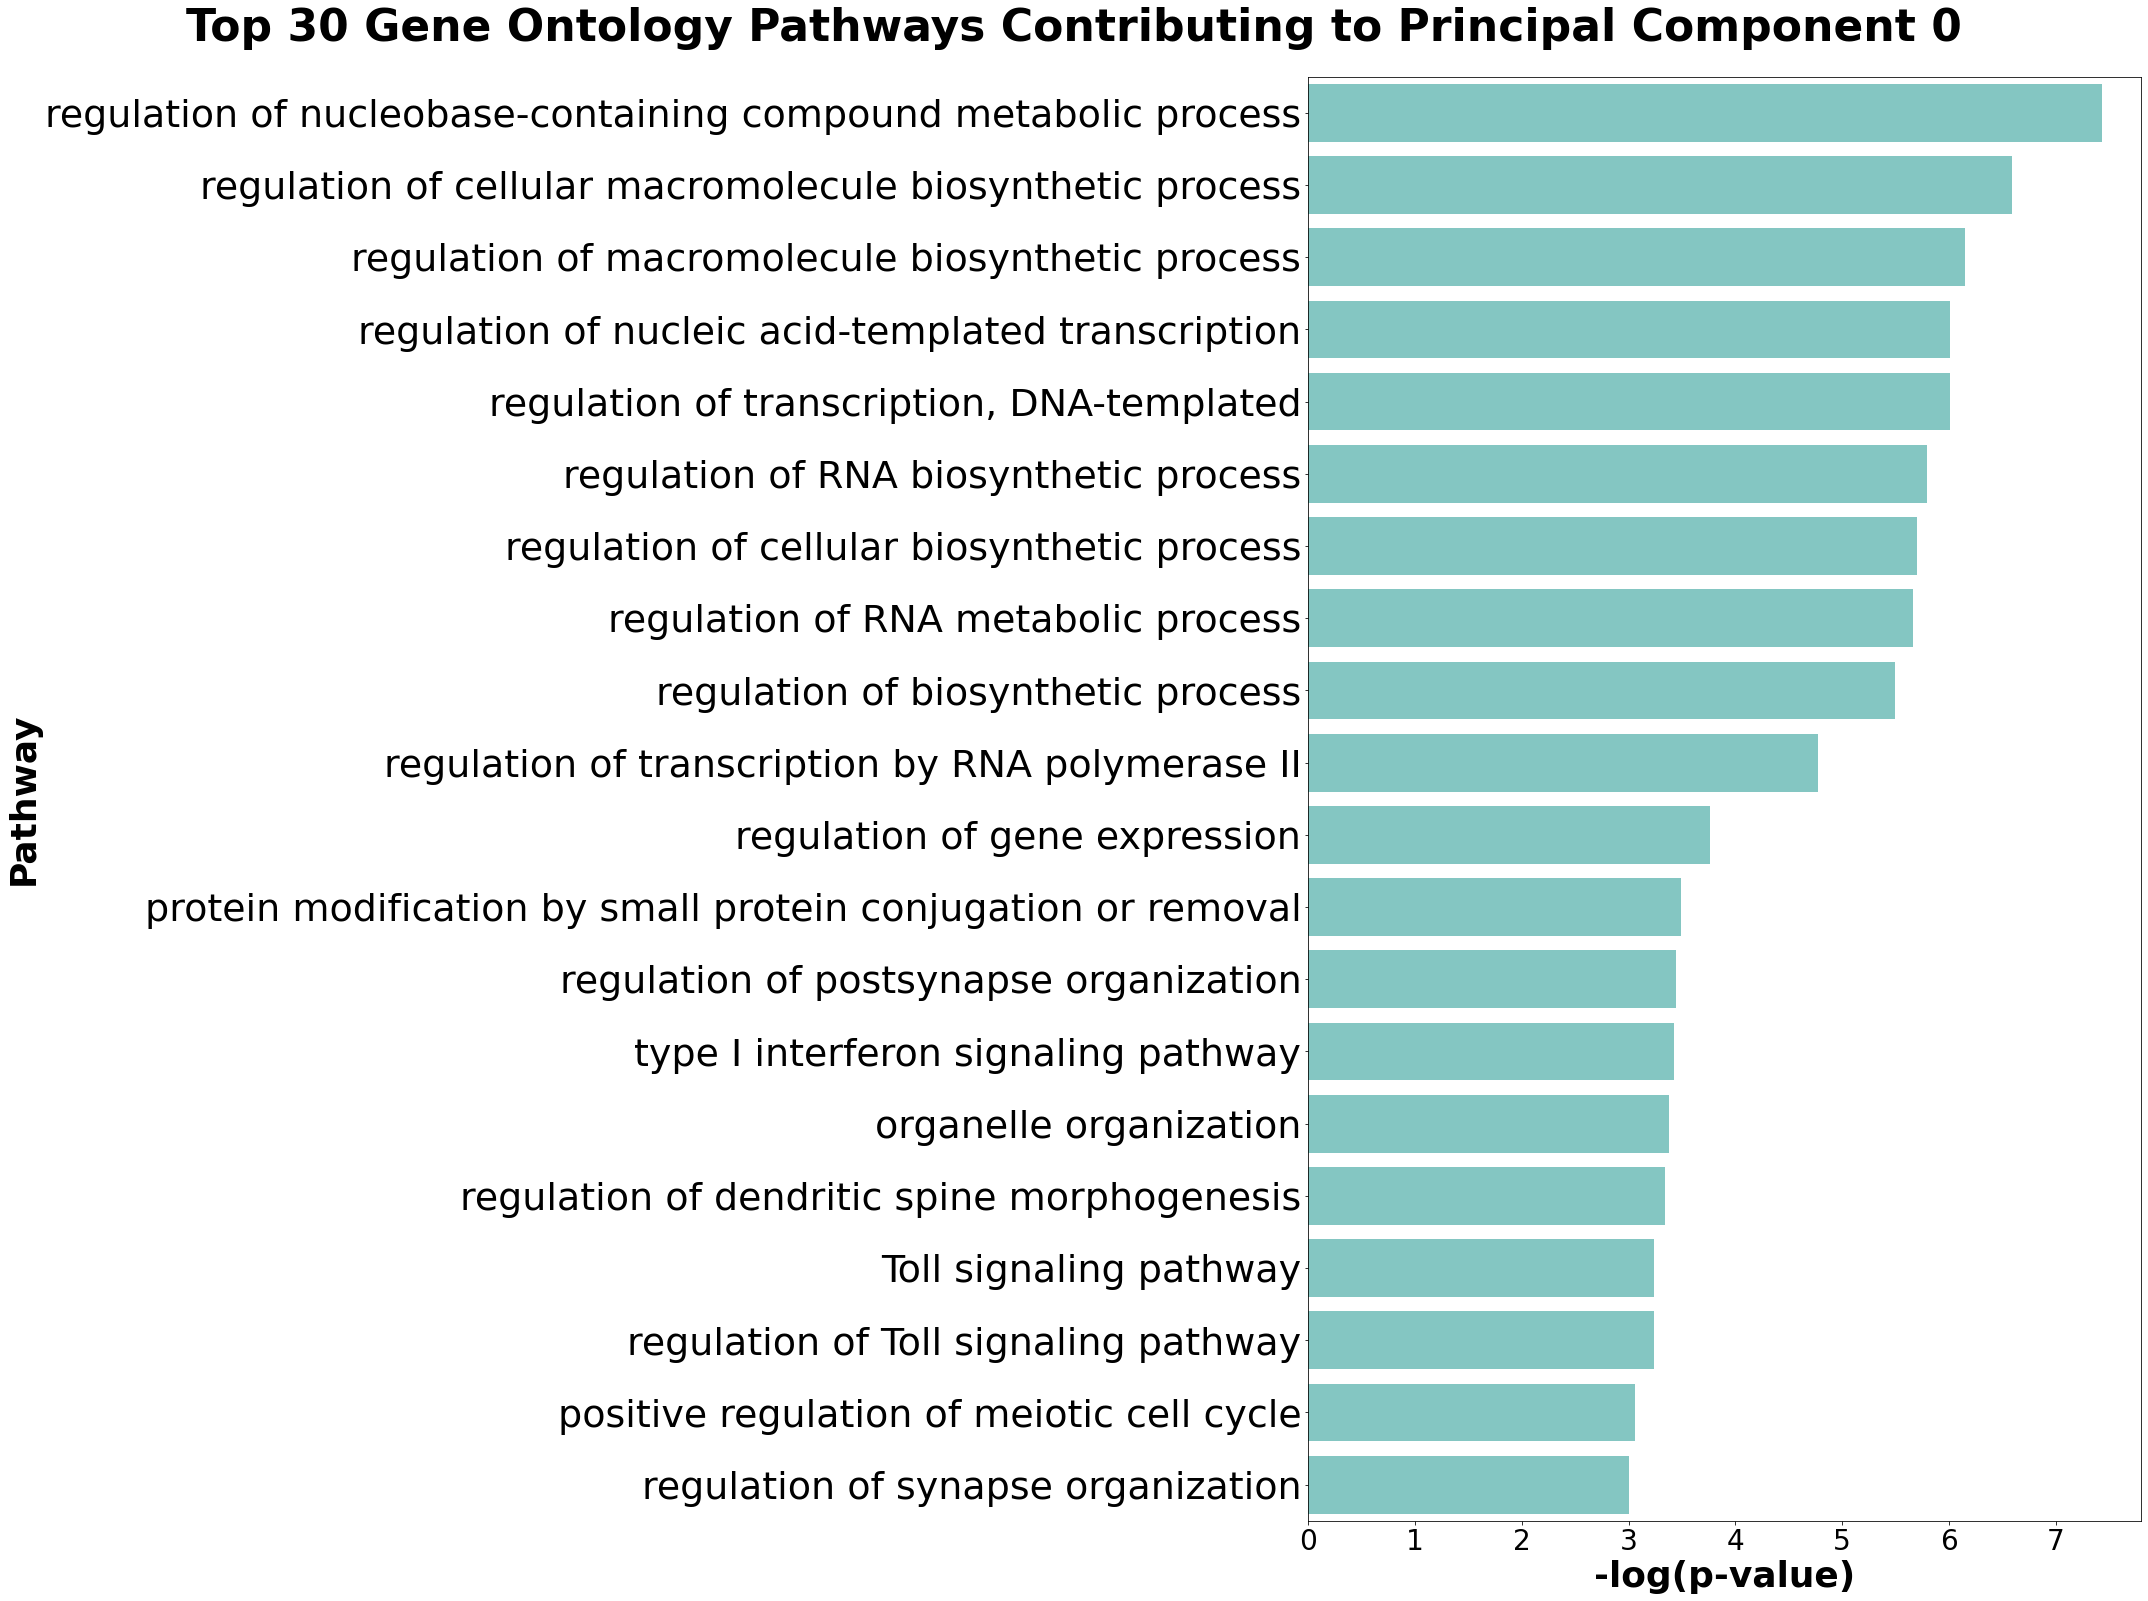

filtered: (30, 11)


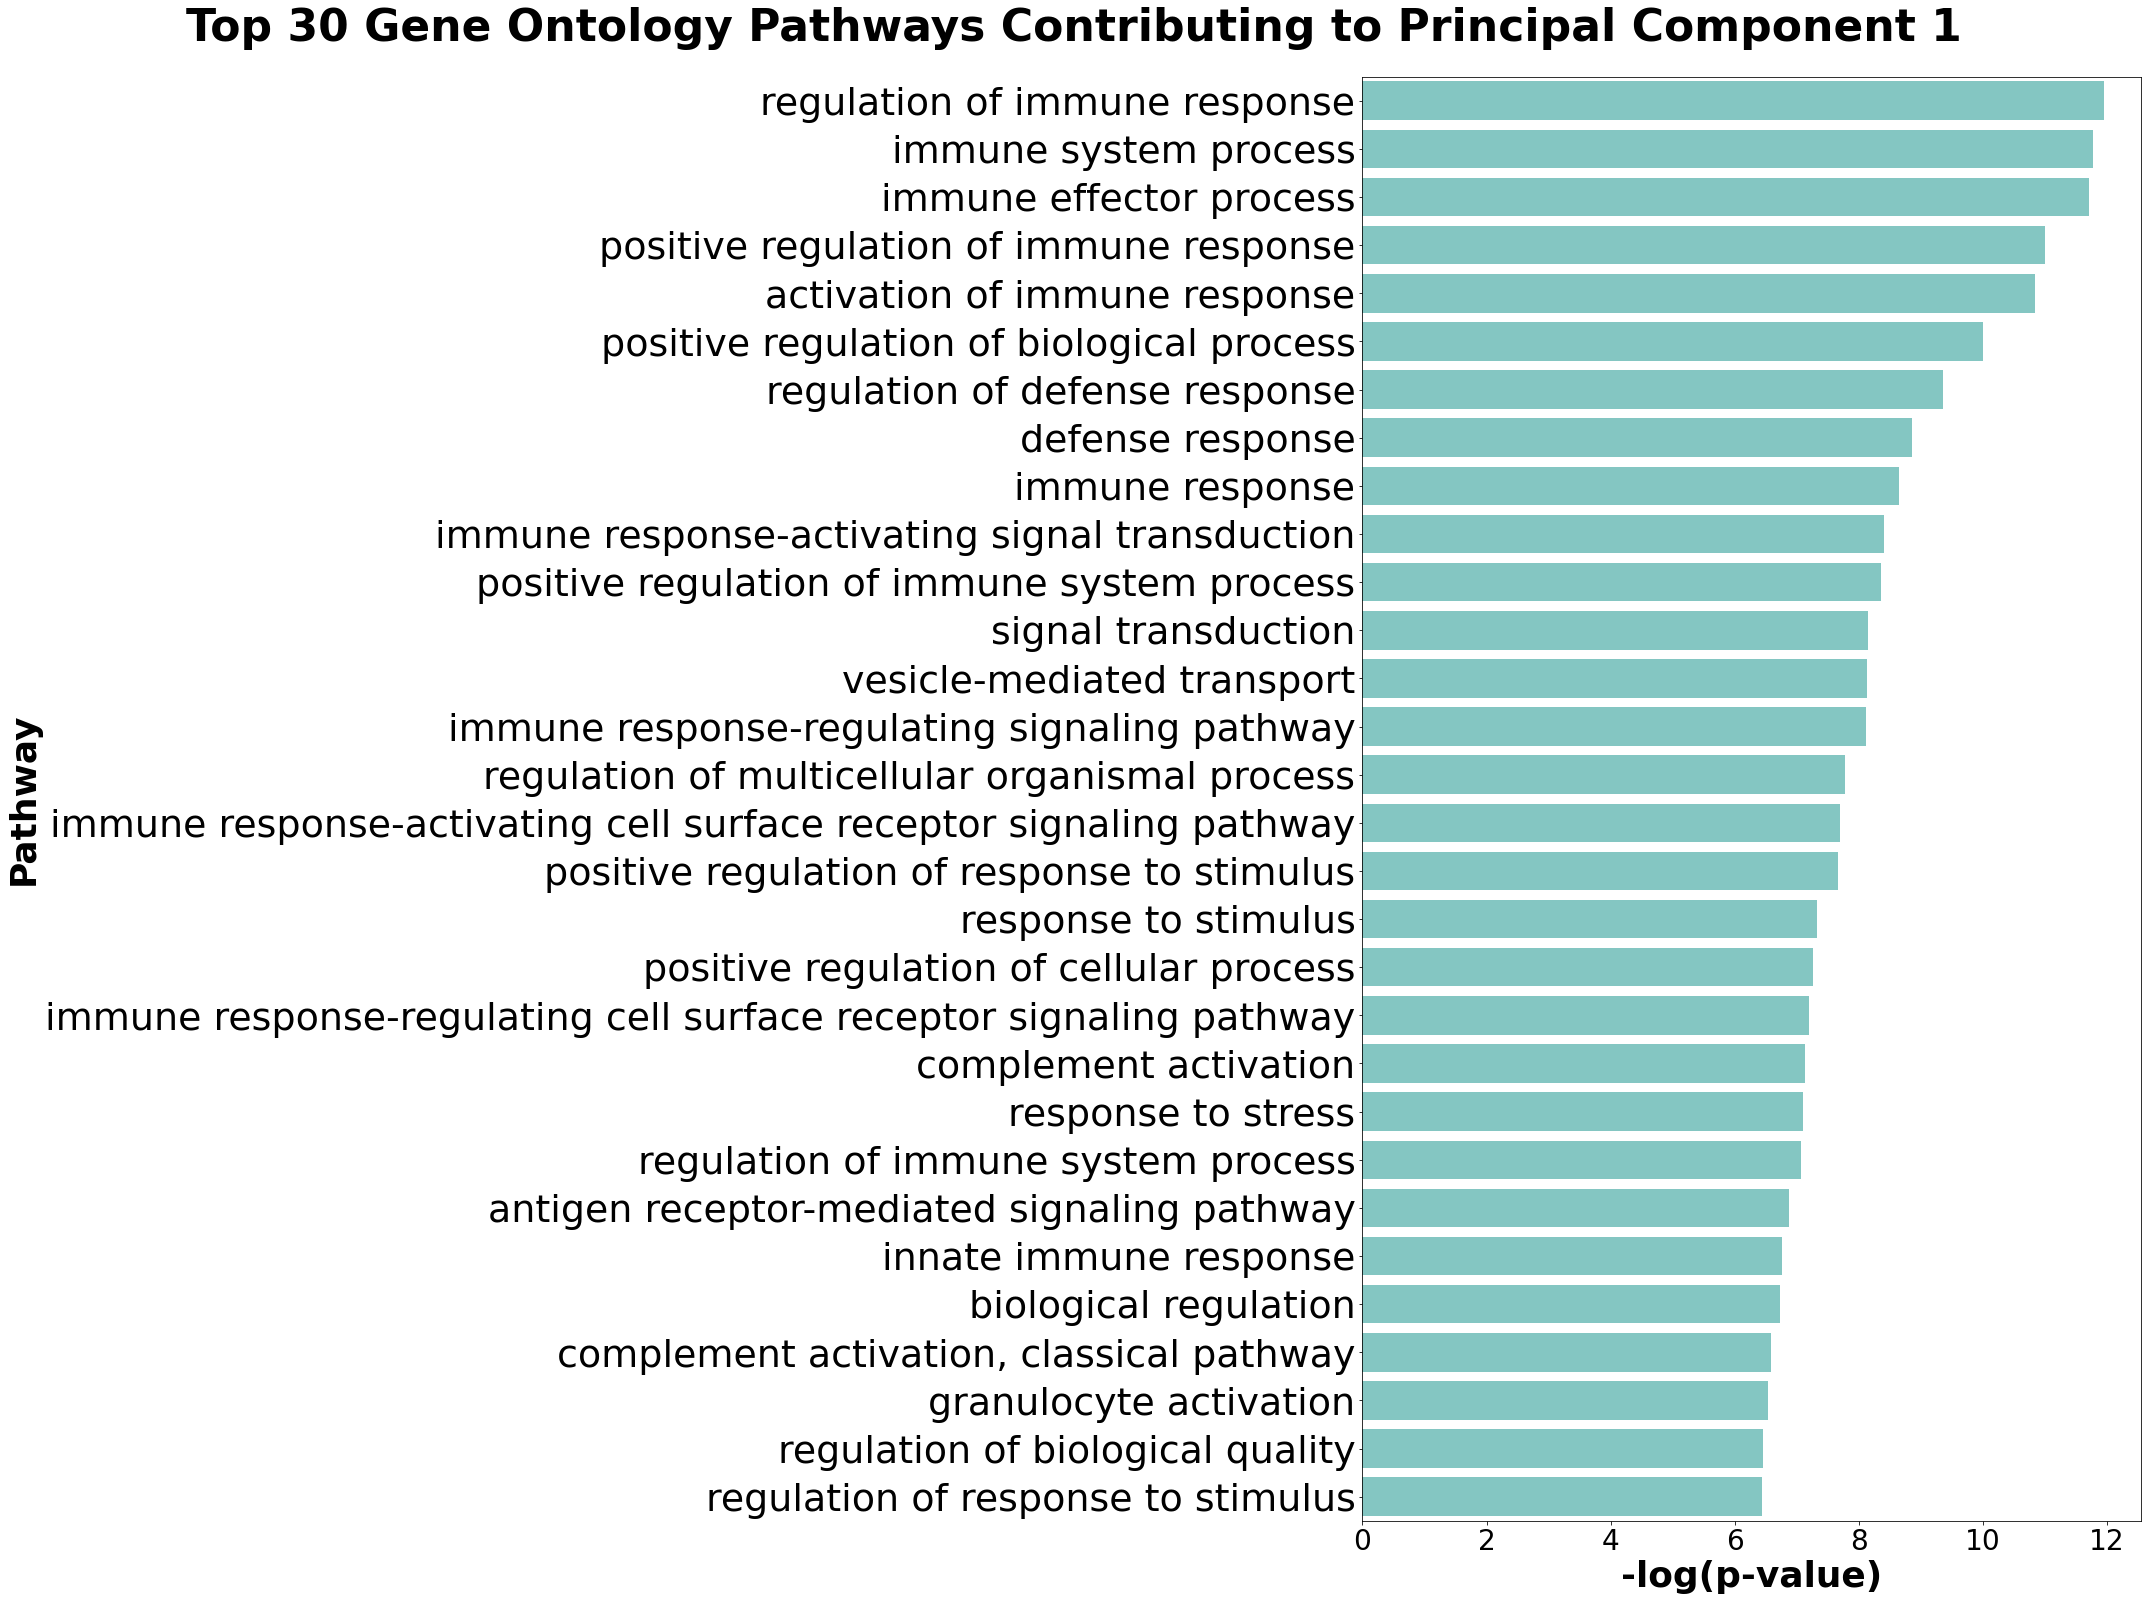

filtered: (30, 11)


filtered: (30, 11)


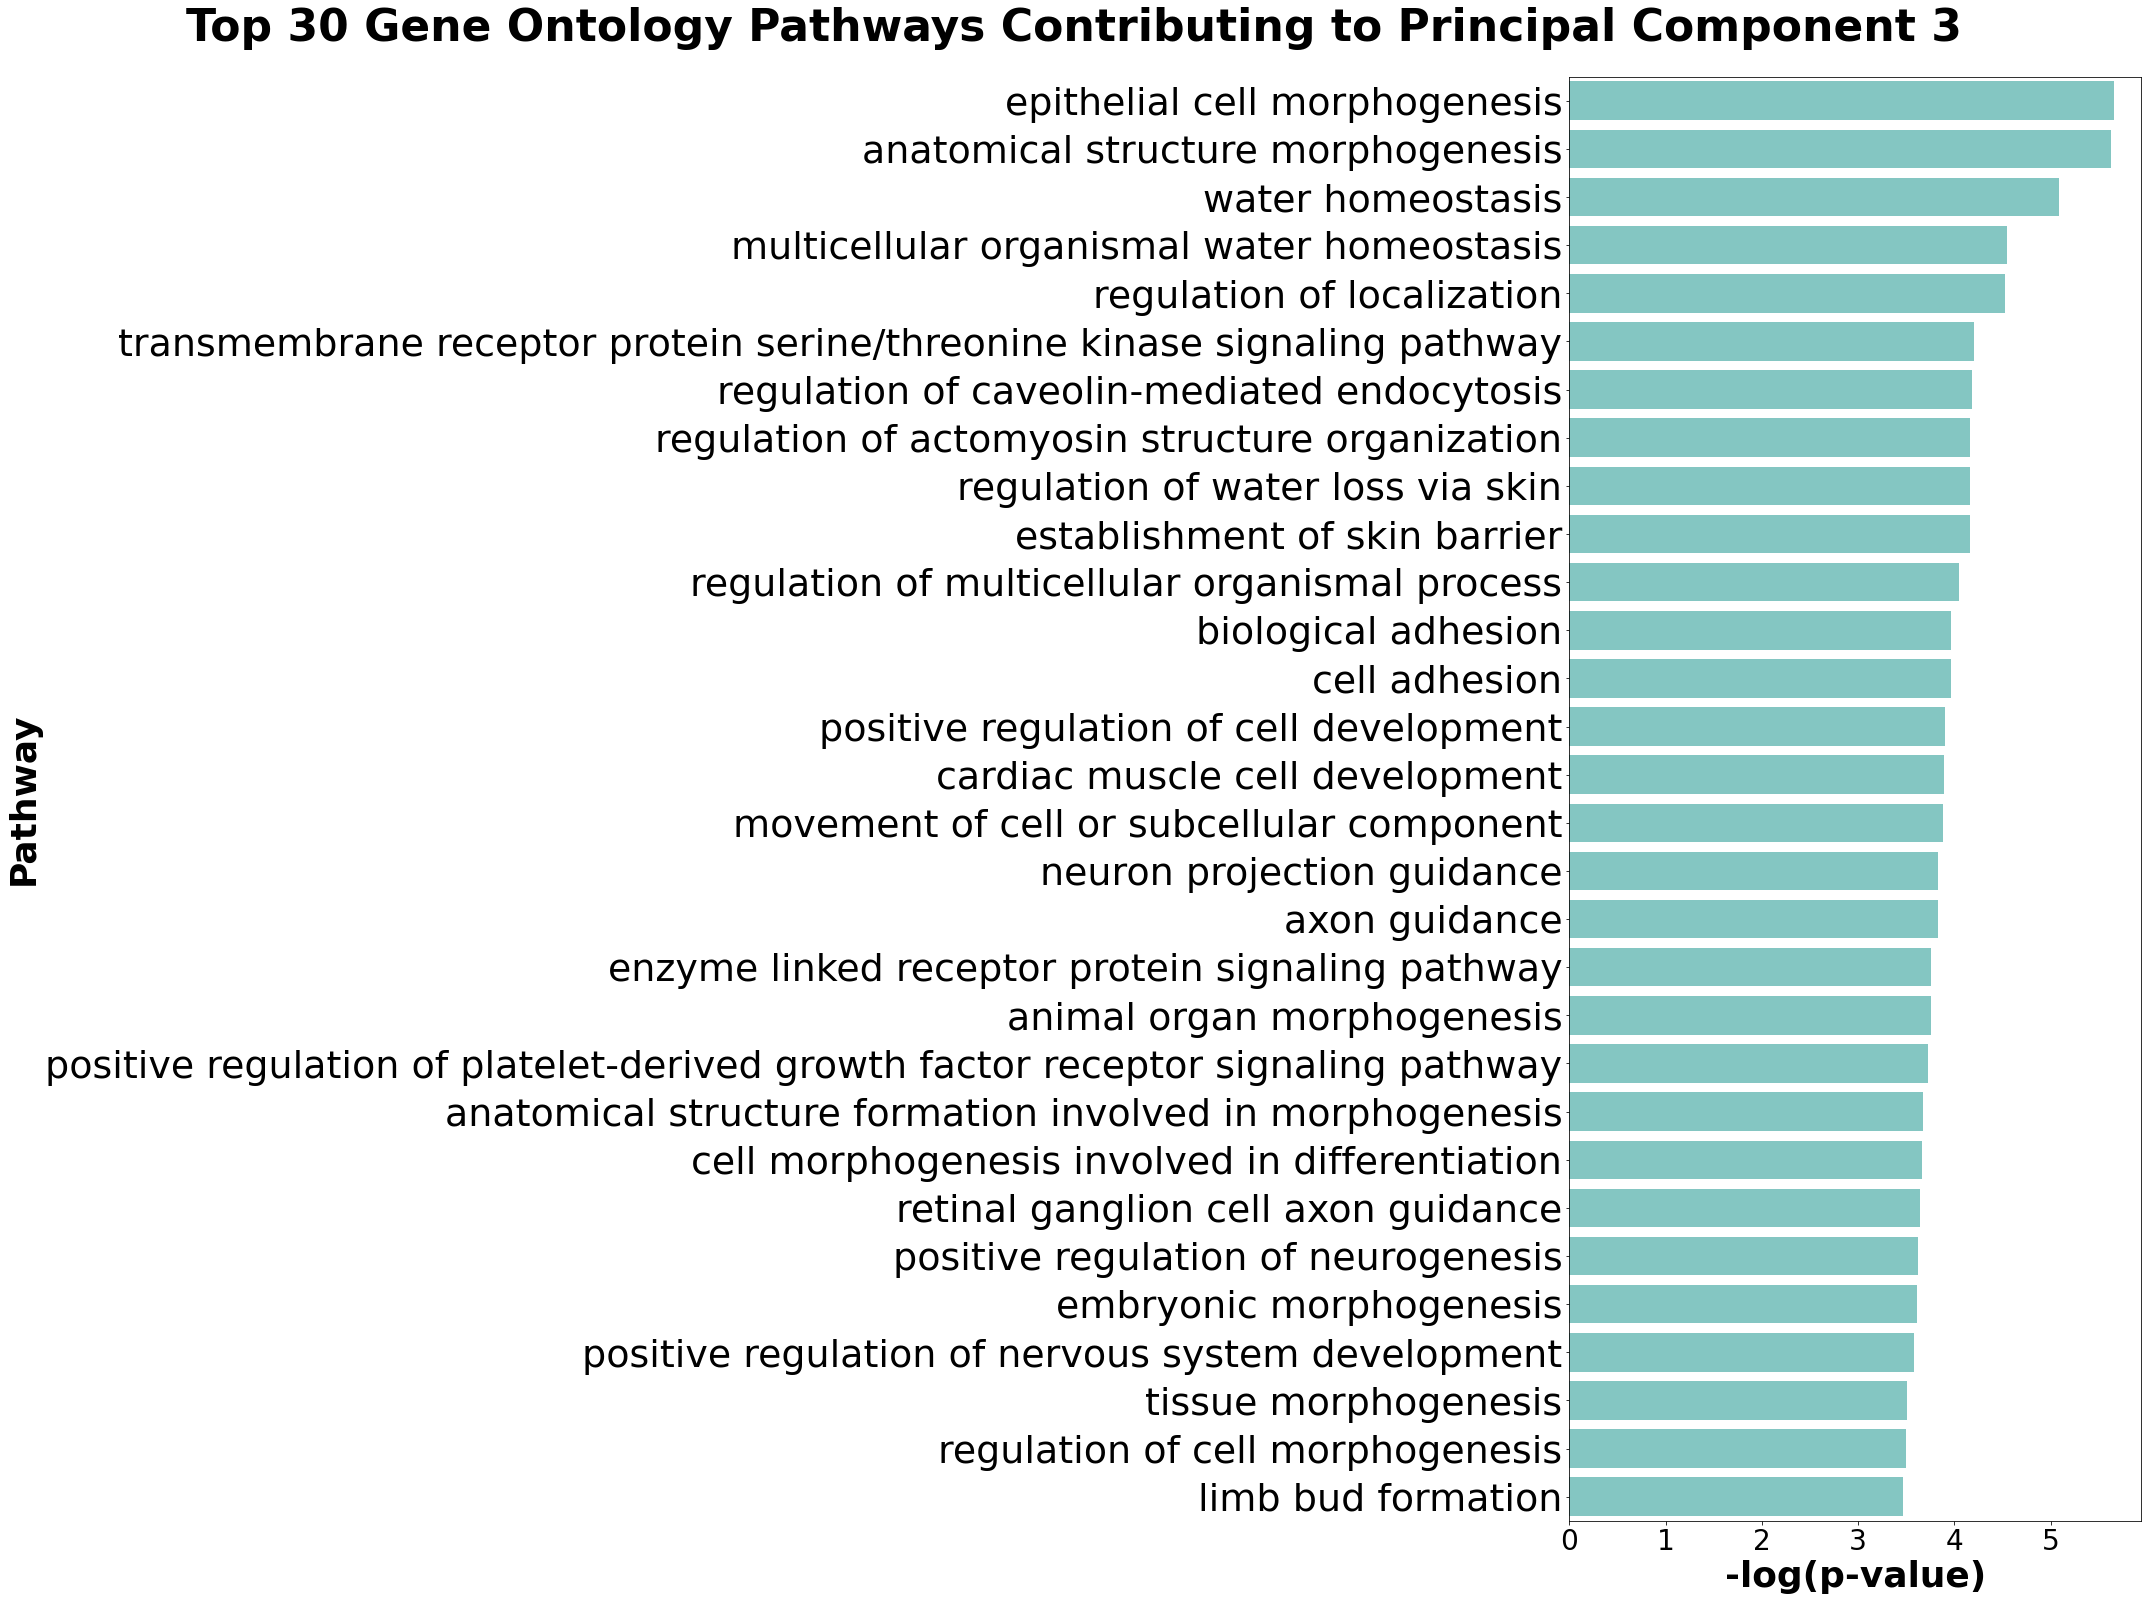

filtered: (30, 11)


filtered: (30, 11)


filtered: (30, 11)


filtered: (30, 11)


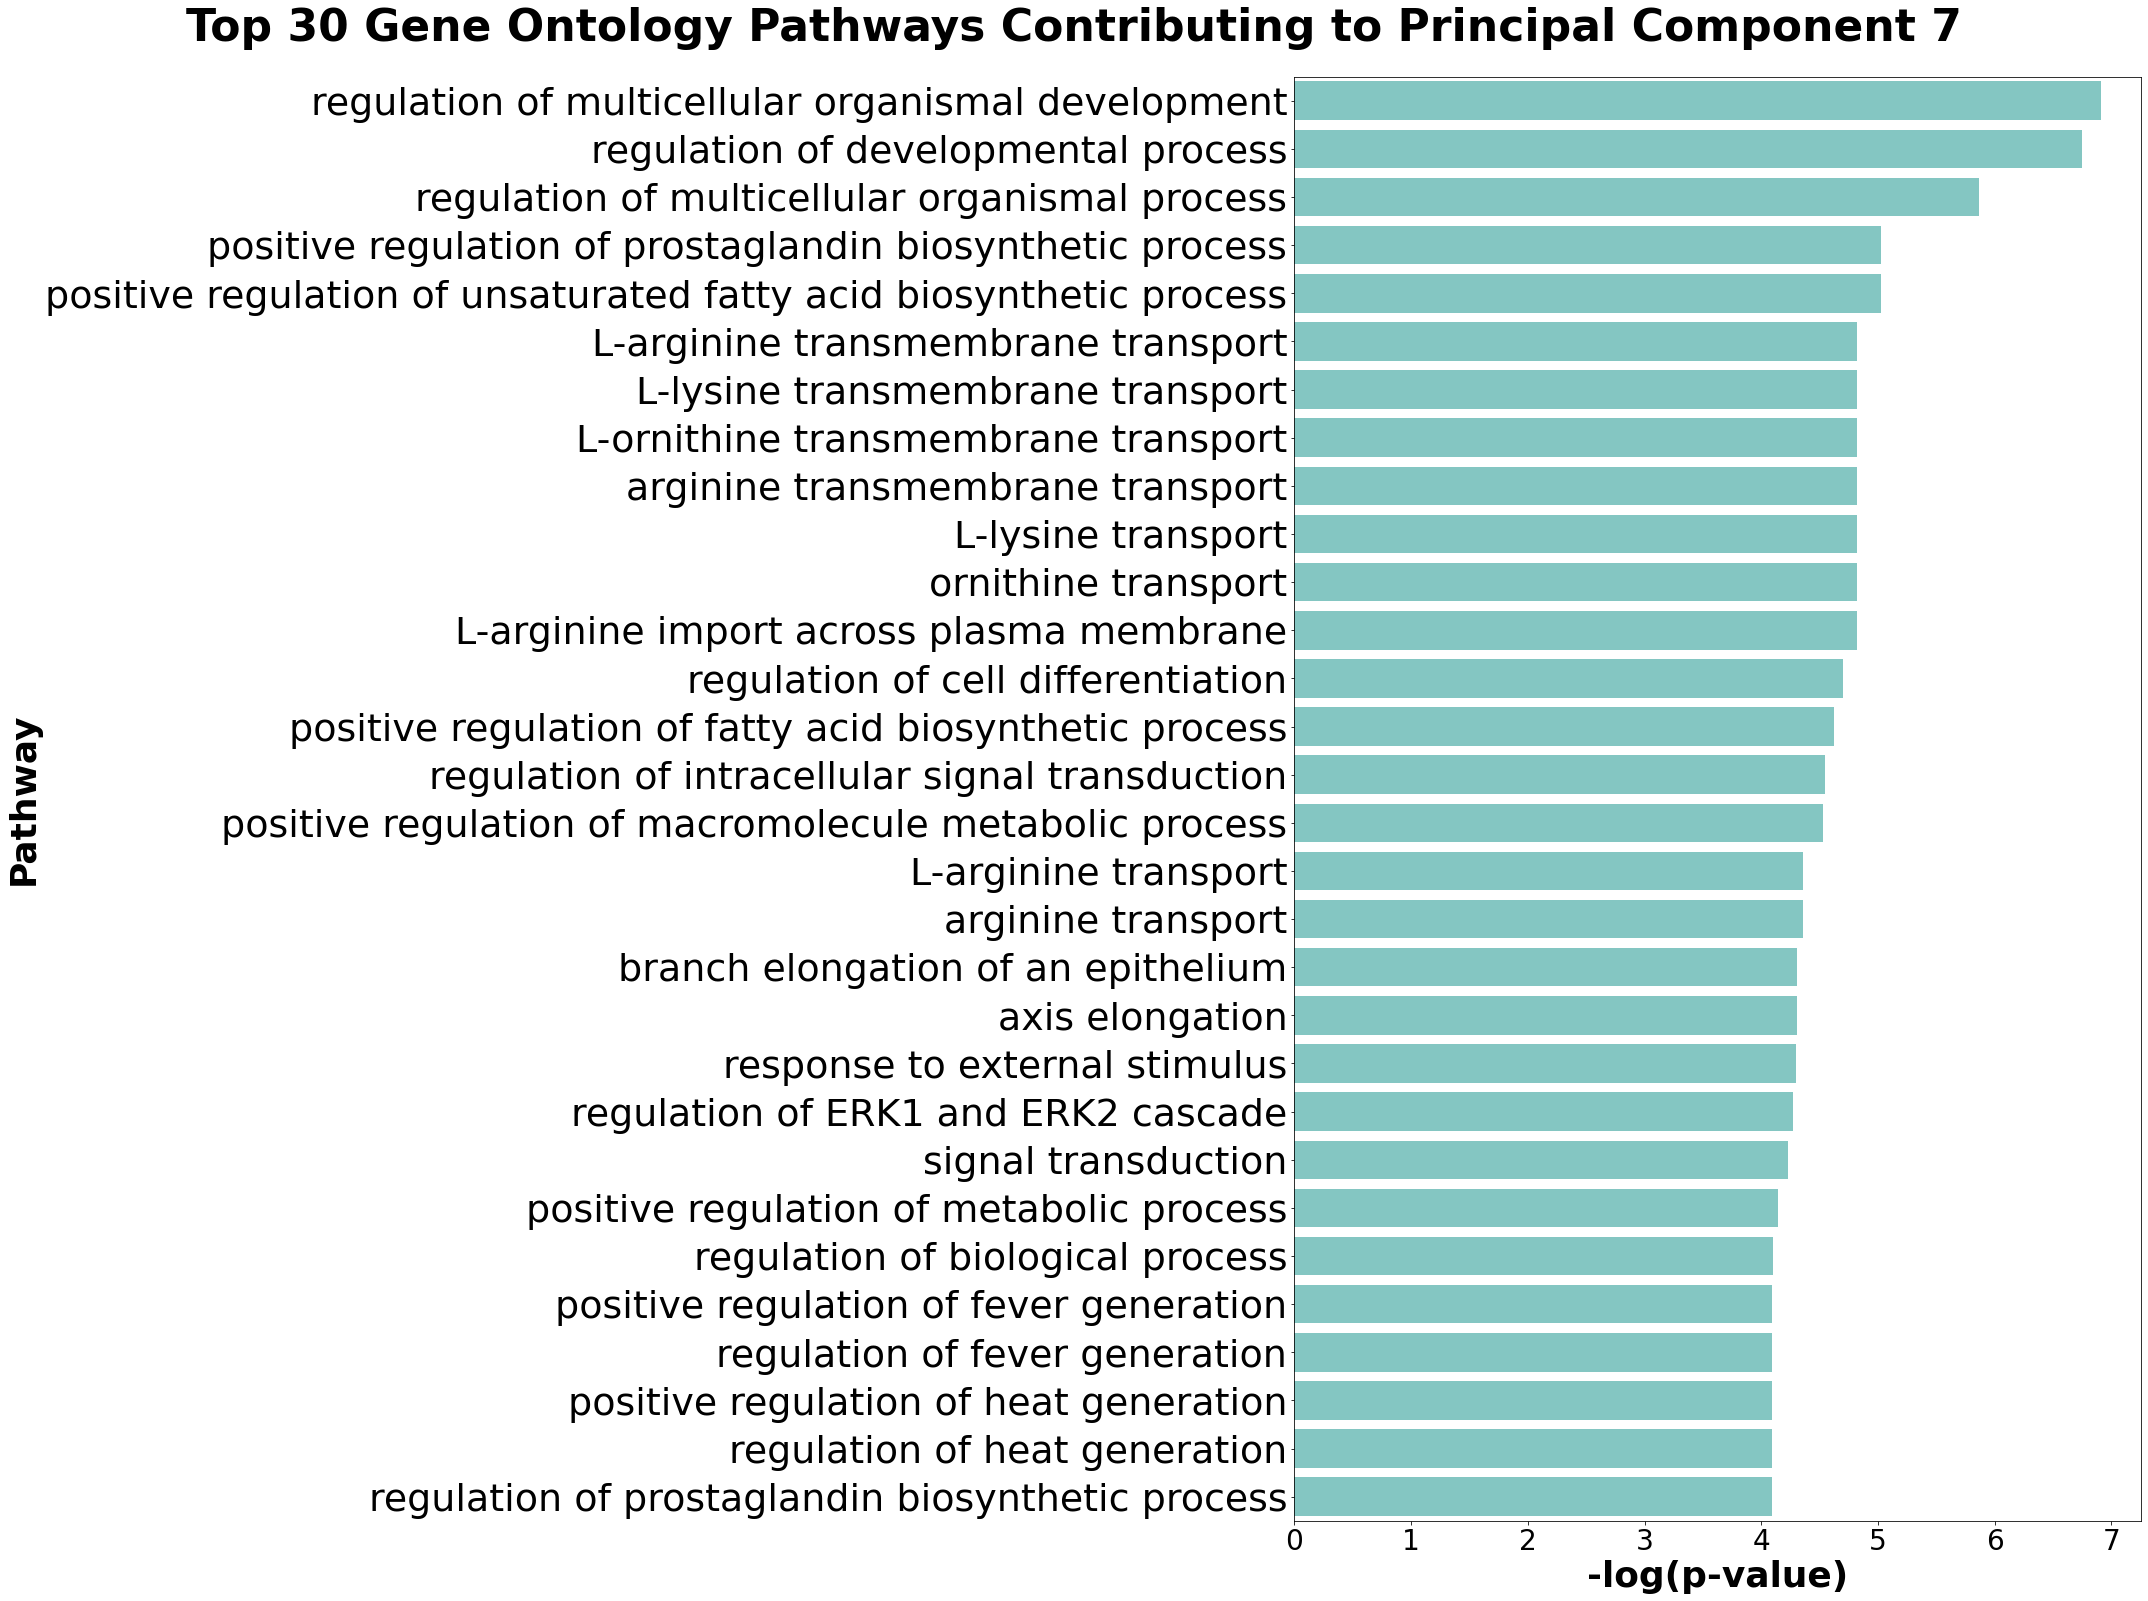

In [72]:
for sheet_name in sheet_names:
    # Reading the Excel sheet into a DataFrame
    pca_name_path = Path(f"{os.getcwd()}/../results/EXP5/", f"GOPROCESS_{added}")
    data = pd.read_excel(pca_name_path, sheet_name = sheet_name)
    data["-logpvalue"] = -np.log10(data["P-value"])
    # Filter the DataFrame for pathways related to adipocyte functions
    # and 'p-value' containing the p-values
    filtered_data = data.loc[0:29]
    print(f"filtered: {filtered_data.shape}")
    # Plotting the data
    num = num+1
    plt.figure(figsize=(30,22))  
    bar_plot = sns.barplot(x='-logpvalue', y='Description', data=filtered_data, color='lightseagreen',alpha=0.6)
    plt.xlabel('-log(p-value)', fontsize=36, fontweight='bold')
    plt.ylabel('Pathway', fontsize=36, fontweight='bold')
    plt.suptitle(f'Top 30 Gene Ontology Pathways Contributing to Principal Component {sheet_name[-1]}',
               fontname = 'Arial',fontweight='bold', fontsize=44,  y=1.0005)
    # Set the weight of the y-axis labels to bold
    for label in bar_plot.get_yticklabels():
        label.set_fontsize(38)
    plt.tight_layout()
    plt.xticks(fontsize=28)
    plt.show()

## NMF

Analyzing how close to negative the distributions of each residual are:

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


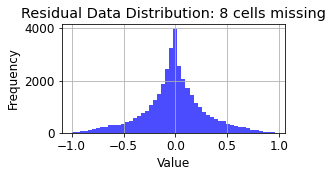

In [73]:
data = residuals_bulks.values
plt.figure(figsize=(4, 2)) 
plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
plt.title(f'Residual Data Distribution: {num} cells missing')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

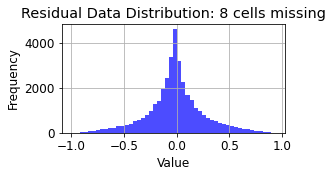

In [74]:
data = residuals_dissbulks.values
plt.figure(figsize=(4, 2)) 
plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
plt.title(f'Residual Data Distribution: {num} cells missing')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Shifting distributions according to above plots, and calculating NMF:

0.9987524016268683


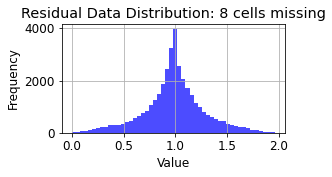

In [75]:
residuals_bulks_shift=residuals_bulks
if nmf_cut == "minimum_value":
    #calculate value to shift distributions minimally:
    min_val = abs(np.min(np.min(residuals_bulks)))
    print(min_val)
    residuals_bulks_shift= residuals_bulks + min_val
elif nmf_cut == "at_0":
    #cutting distribution at 0
    residuals_bulks_shift[residuals_bulks_shift.values <= 0] = 0
data = residuals_bulks_shift.values
plt.figure(figsize=(4, 2)) 
plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
plt.title(f'Residual Data Distribution: {num} cells missing')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

0.9958686221854988


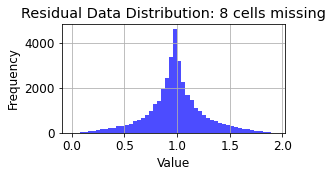

In [76]:
residuals_dissbulks_shift=residuals_dissbulks
if nmf_cut == "minimum_value":
    #calculate value to shift distributions minimally:
    min_val = abs(np.min(np.min(residuals_dissbulks)))
    print(min_val)
    residuals_dissbulks_shift= residuals_dissbulks + min_val
elif nmf_cut == "at_0":
    #cutting distribution at 0
    residuals_dissbulks_shift[residuals_dissbulks_shift.values <= 0] = 0
data = residuals_dissbulks_shift.values
plt.figure(figsize=(4, 2)) 
plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
plt.title(f'Residual Data Distribution: {num} cells missing')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

0.9987524016268683


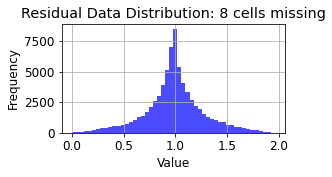

In [77]:
residuals_combo_shift=residuals_combo
if nmf_cut == "minimum_value":
    #calculate value to shift distributions minimcomboy:
    min_val = abs(np.min(np.min(residuals_combo)))
    print(min_val)
    residuals_combo_shift= residuals_combo + min_val
elif nmf_cut == "at_0":
    #cutting distribution at 0
    residuals_combo_shift[residuals_combo_shift.values <= 0] = 0
data = residuals_combo_shift.values
plt.figure(figsize=(4, 2)) 
plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
plt.title(f'Residual Data Distribution: {num} cells missing')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### The combined residuals (classic and dissociated)

In [78]:
#nmf on residual combined
num_nmf_comp_combo = 4
nmf = NMF(n_components = num_nmf_comp_combo, init='nndsvd', max_iter=10000)
res_nmf_df = nmf.fit_transform(residuals_combo_shift)
res_nmf_combo = pd.DataFrame(res_nmf_df)
components_combo = pd.DataFrame(nmf.components_)
components_combo.columns = gene_ids
components_combo

A1BG       A2M     AAGAB      AASS      AATF      AATK      ABAT  \
0  0.075820  0.155514  0.134280  0.140992  0.103671  0.100043  0.147926   
1  0.061893  0.157337  0.118701  0.111806  0.100242  0.134522  0.114039   
2  0.087227  0.122317  0.110729  0.135412  0.088045  0.184761  0.096701   
3  0.071504  0.126609  0.118671  0.151298  0.090283  0.106159  0.123736   

      ABCA1     ABCA5     ABCB1  ...    ZNHIT1    ZNHIT3     ZNRF1     ZNRF3  \
0  0.145739  0.105866  0.134192  ...  0.049674  0.114429  0.118777  0.114527   
1  0.146997  0.188268  0.107591  ...  0.035784  0.087357  0.093823  0.132620   
2  0.131511  0.063521  0.112262  ...  0.041688  0.089950  0.087615  0.106674   
3  0.127412  0.146875  0.103630  ...  0.018647  0.092499  0.093404  0.116082   

       ZPR1     ZRSR2   ZSCAN18    ZSWIM8      ZXDC       ZYX  
0  0.123871  0.113199  0.132811  0.188957  0.154551  0.157778  
1  0.119394  0.091308  0.138407  0.181290  0.180135  0.049813  
2  0.253310  0.094229  0.133346  0.145699  0.129095  0.187852  
3  0.129411  0.089149  0.109791  0.157618  0.119691  0.117662  

[4 rows x 4584 columns]

In [79]:
# Separate the data into "classic bulks" and "dissociated bulks"
df = res_nmf_combo
classic_bulks = df.iloc[:8, :]
dissociated_bulks = df.iloc[8:, :]

# Perform t-test for each component
results = pd.DataFrame(columns=['Component', 'T-Statistic', 'P-Value'])

for column in df.columns:
    t_statistic, p_value = stats.ttest_ind(classic_bulks[column], dissociated_bulks[column])
    results = results.append({'Component': column, 'T-Statistic': t_statistic, 'P-Value': p_value}, ignore_index=True)

# Print the results
print(results)

# Identify components with significantly different means
significantly_different = results[results['P-Value'] < 0.05]
print("Components with significantly different means:")
print(significantly_different)

   Component  T-Statistic       P-Value
0        0.0     0.090267  9.293536e-01
1        1.0     0.751413  4.648489e-01
2        2.0    -8.622641  5.663126e-07
3        3.0     1.023608  3.233834e-01
Components with significantly different means:
   Component  T-Statistic       P-Value
2        2.0    -8.622641  5.663126e-07


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


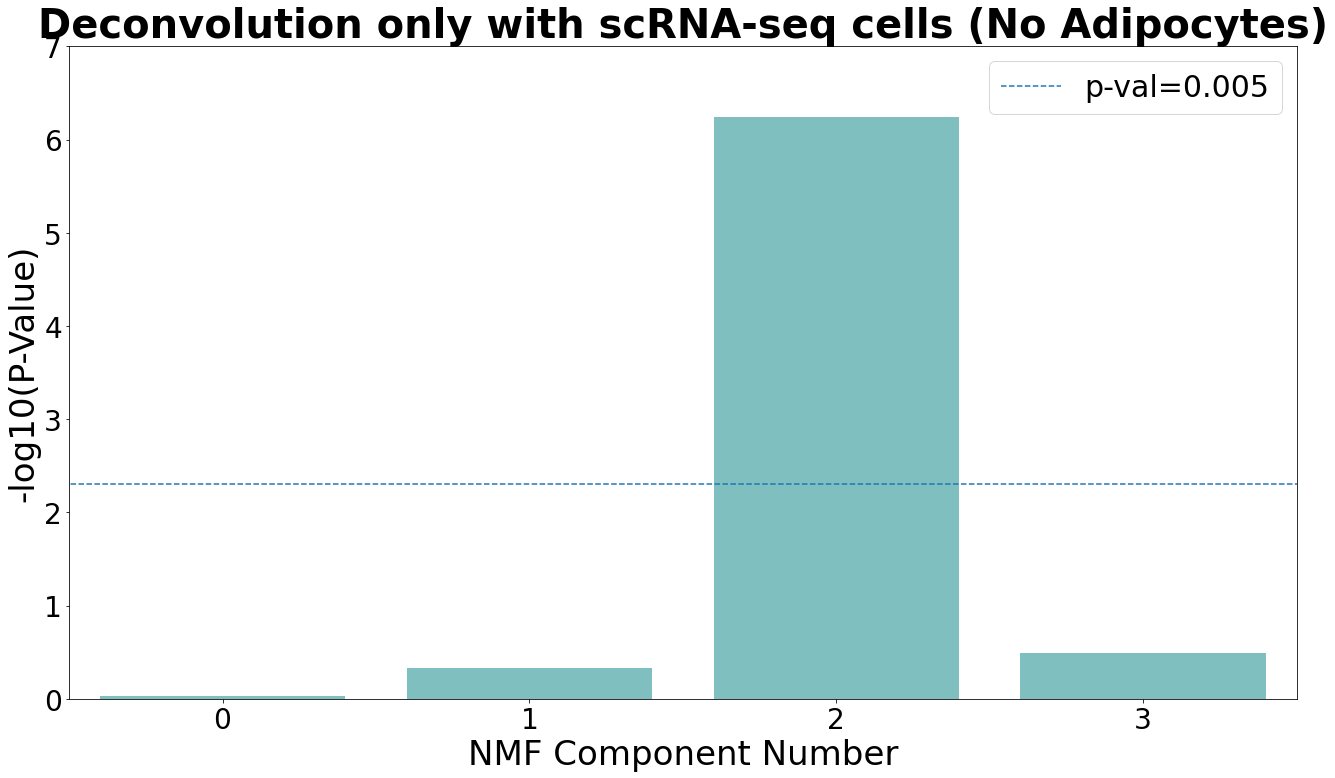

In [80]:
# Bar plot for each component
plt.figure(figsize=(22,12))
plt.bar(results['Component'], -np.log10(results['P-Value']), color='teal', alpha=0.5)

plt.xlabel('NMF Component Number', fontsize=34, fontname='Arial')
plt.ylabel('-log10(P-Value)', fontsize=34, fontname='Arial')
plt.plot([-1,0,1,2,3,4],np.repeat(-np.log10(0.005),6),linestyle='--', label='p-val=0.005')
if add_adipo == True:
    title_str = 'Deconvolution scRNA-seq cells and snRNA-seq added Adipocytes'
else:
    title_str ='Deconvolution only with scRNA-seq cells (No Adipocytes)'
plt.title(title_str, fontsize=40, fontname='Arial', fontweight='bold')
plt.xticks([0,1,2,3], fontsize=28)
plt.yticks(fontsize=28)
plt.ylim(0,7)
plt.xlim(-0.5,3.5)
plt.legend(fontsize=30)
plt.show()

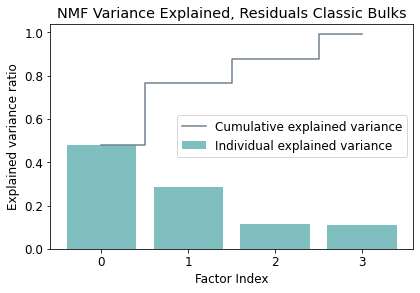

In [81]:
# W and H are your NMF results
V = residuals_combo_shift.values
W = res_nmf_combo.values
H = components_combo.values # Solve for H using least squares

# Calculate the explained variance for each component
explained_variance = []
for i in range(W.shape[1]):
    WH = np.dot(W[:, :i+1], H[:i+1, :])
    explained_variance.append(1 - np.linalg.norm(V - WH, 'fro')**2 / np.linalg.norm(V, 'fro')**2)

cum_sum = explained_variance

indiv_variance =  [cum_sum[0], 
                cum_sum[1] - cum_sum[0],
                cum_sum[2]- cum_sum[1],
                cum_sum[3] - cum_sum[2],
]

## plot variance explained
plt.bar(range(0,len(indiv_variance)), indiv_variance, alpha=0.5, align='center', label='Individual explained variance', color='teal')
plt.step(range(0,len(cum_sum)), cum_sum, where='mid',label='Cumulative explained variance', color='slategrey')
plt.ylabel('Explained variance ratio')
plt.xlabel('Factor Index')
plt.legend(loc='best')
plt.xticks([0,1,2,3])
plt.tight_layout()
plt.title(f"NMF Variance Explained, Residuals Classic Bulks")
plt.show()

In [82]:
W = res_nmf_combo.values
H = components_combo.values

nmf_genes_combo = pd.DataFrame()
num_components = num_nmf_comp_combo

# Iterate through each component
for component_idx in range(num_components):

    # Sort genes by their influence on the current component
    sorted_genes = residuals_combo.columns[np.argsort(H[component_idx])]

    # Visualize the top N genes that contribute the most to the current component
    N = len(sorted_genes)
    top_genes = sorted_genes[-N:]

    nmf_genes_combo[component_idx] = top_genes[::-1]
    
nmf_genes_combo.columns = ["Component_0","Component_1","Component_2","Component_3"]
nmf_genes_combo

Component_0 Component_1 Component_2 Component_3
0           LY75       GABRE       NLRP3        TLN2
1          CIITA       WDR91        RELT      PLXNA4
2           TAP2     TMEM63A      KLHL21        GPAM
3            TTN       VTCN1       DUSP2       F13A1
4         BTN3A1       PTPRS     ZC3H12A         TTN
...          ...         ...         ...         ...
4579         CFD       CXCL8     SELENOP         MDK
4580        AREG         ID2       HIPK2      CLEC2B
4581        MT1M      HSPA1A       LRMDA      PMAIP1
4582        MT1A        MT1A       BICD1       TEX14
4583       DEFB1       IGHA1        UPF2        CCL3

[4584 rows x 4 columns]

And plotting gene ontology analysis pathways.

NOTE: You'll have to run GOrilla for this part!

In [83]:
# The sheets on the Excel
if add_adipo:
    added = "NMF_genes_residuals_combo_ADIP.xlsx"
else:
    added ="NMF_genes_residuals_combo.xlsx"
sheet_names = ['Component_0','Component_1','Component_2','Component_3']  

In [84]:
#Exporting NMF genes per component.
nmf_name_path = Path(f"{os.getcwd()}/../results/EXP5/", f"{added}")
nmf_genes_combo.to_excel(nmf_name_path, sheet_name = "NMF_Components_Genes")

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


filtered: (30, 11)


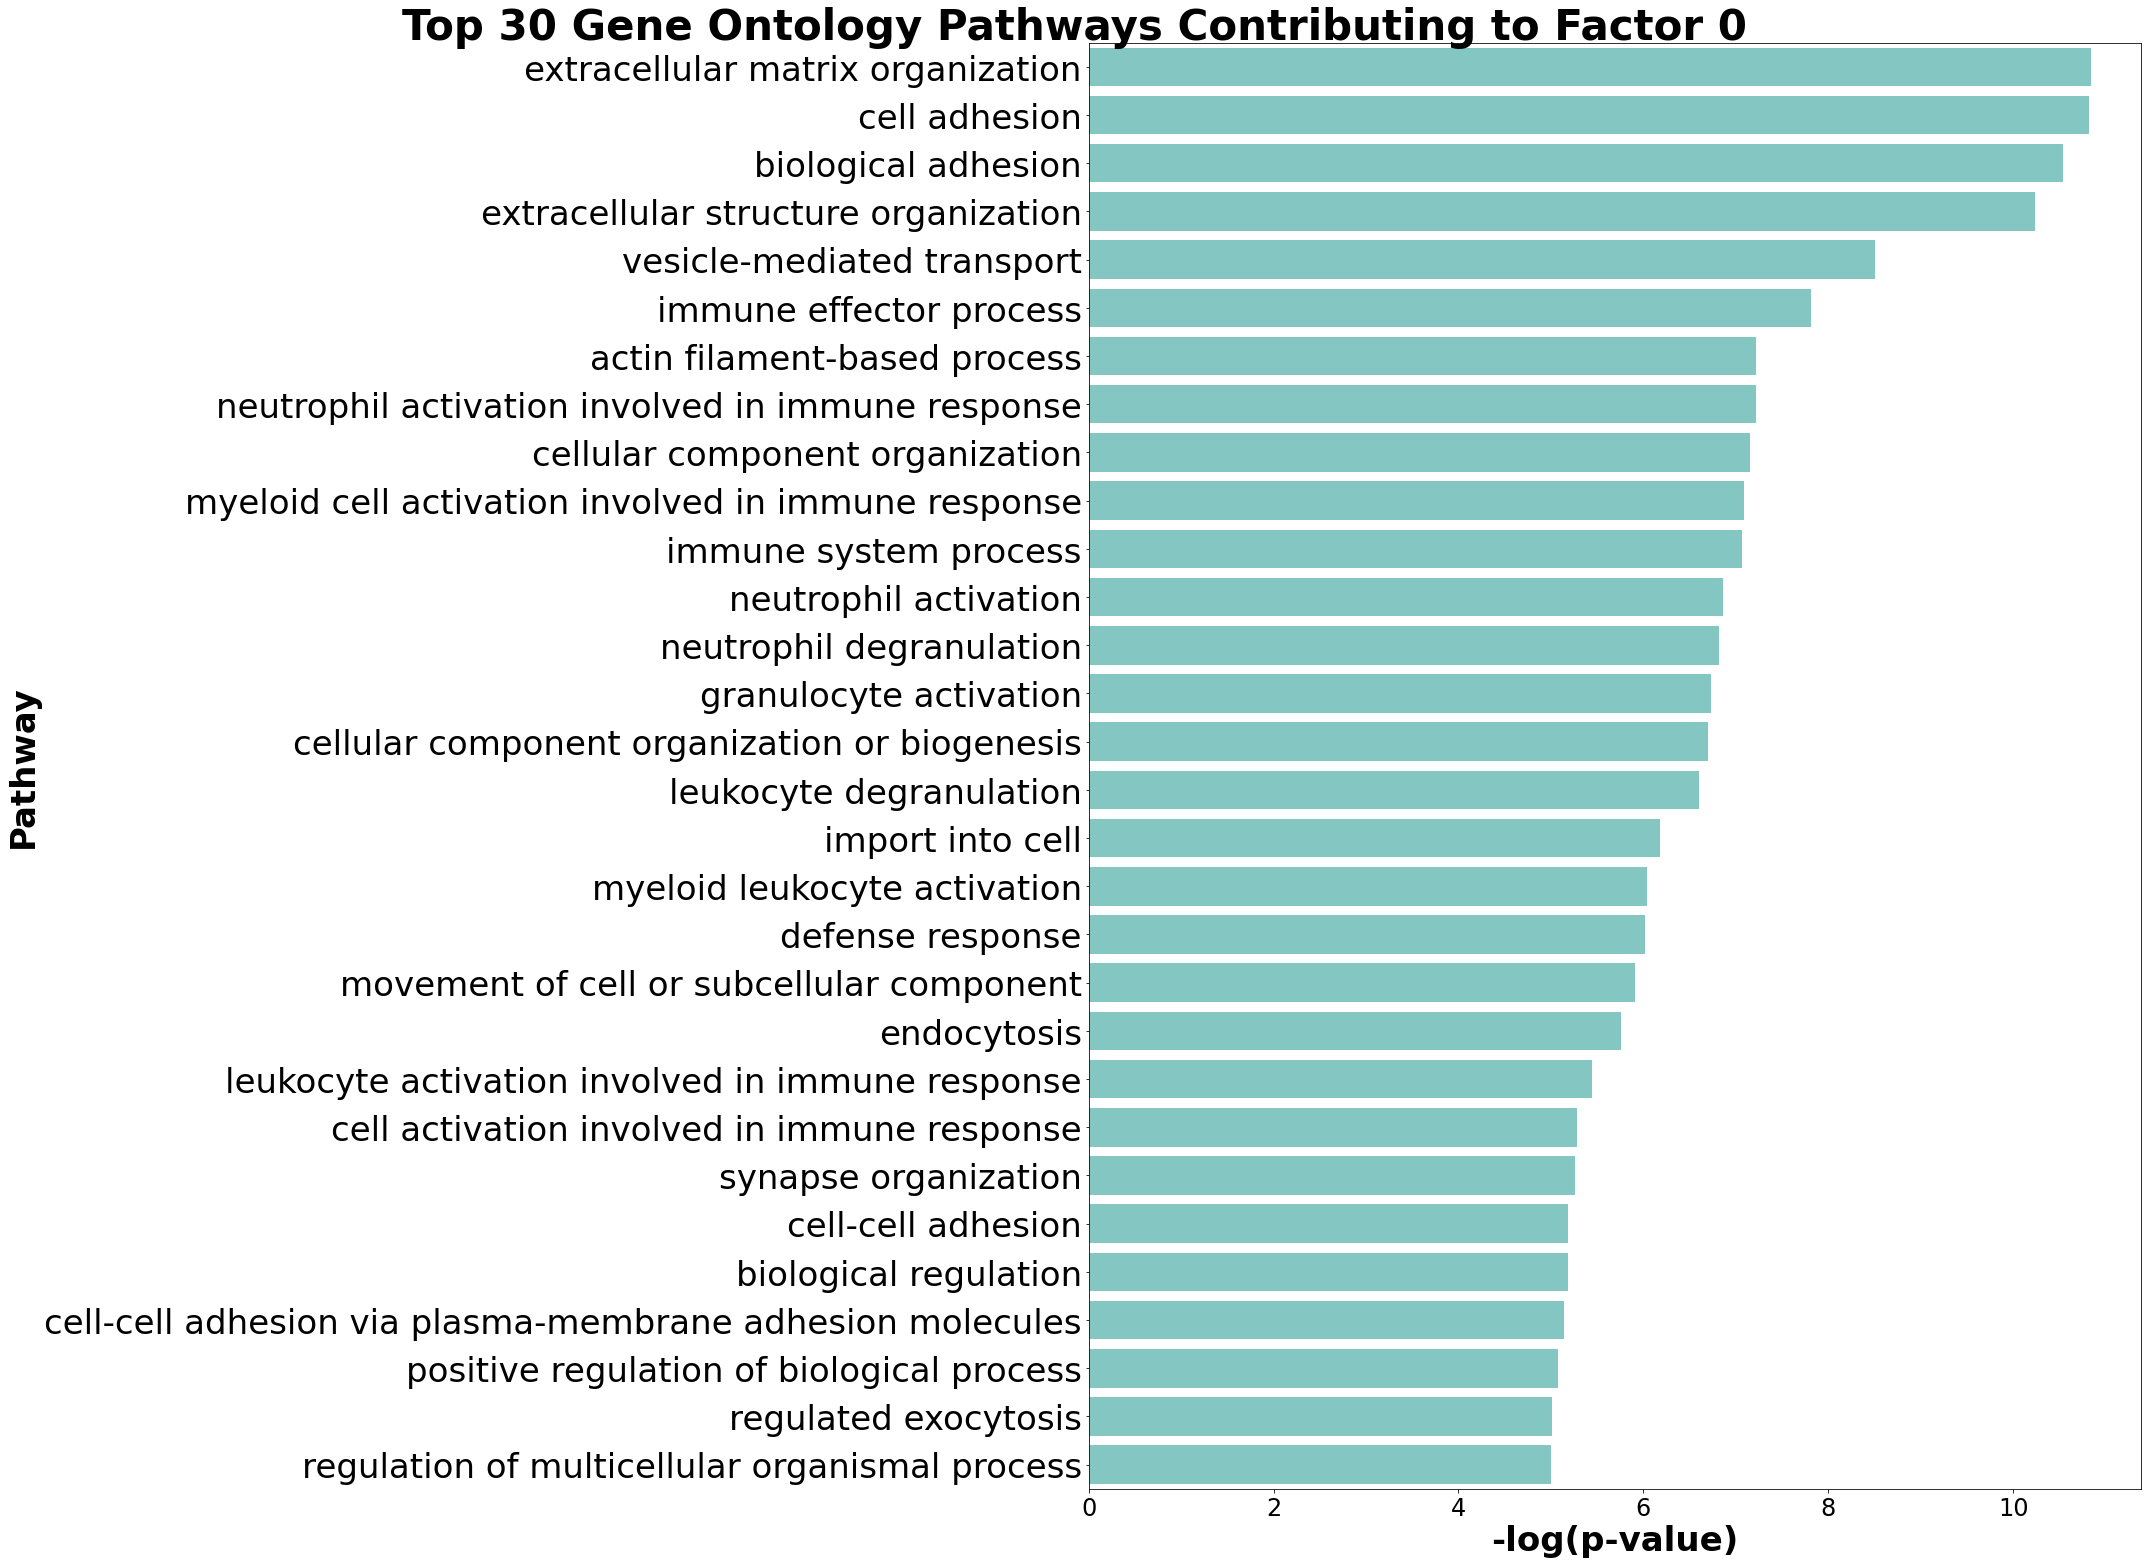

filtered: (9, 11)


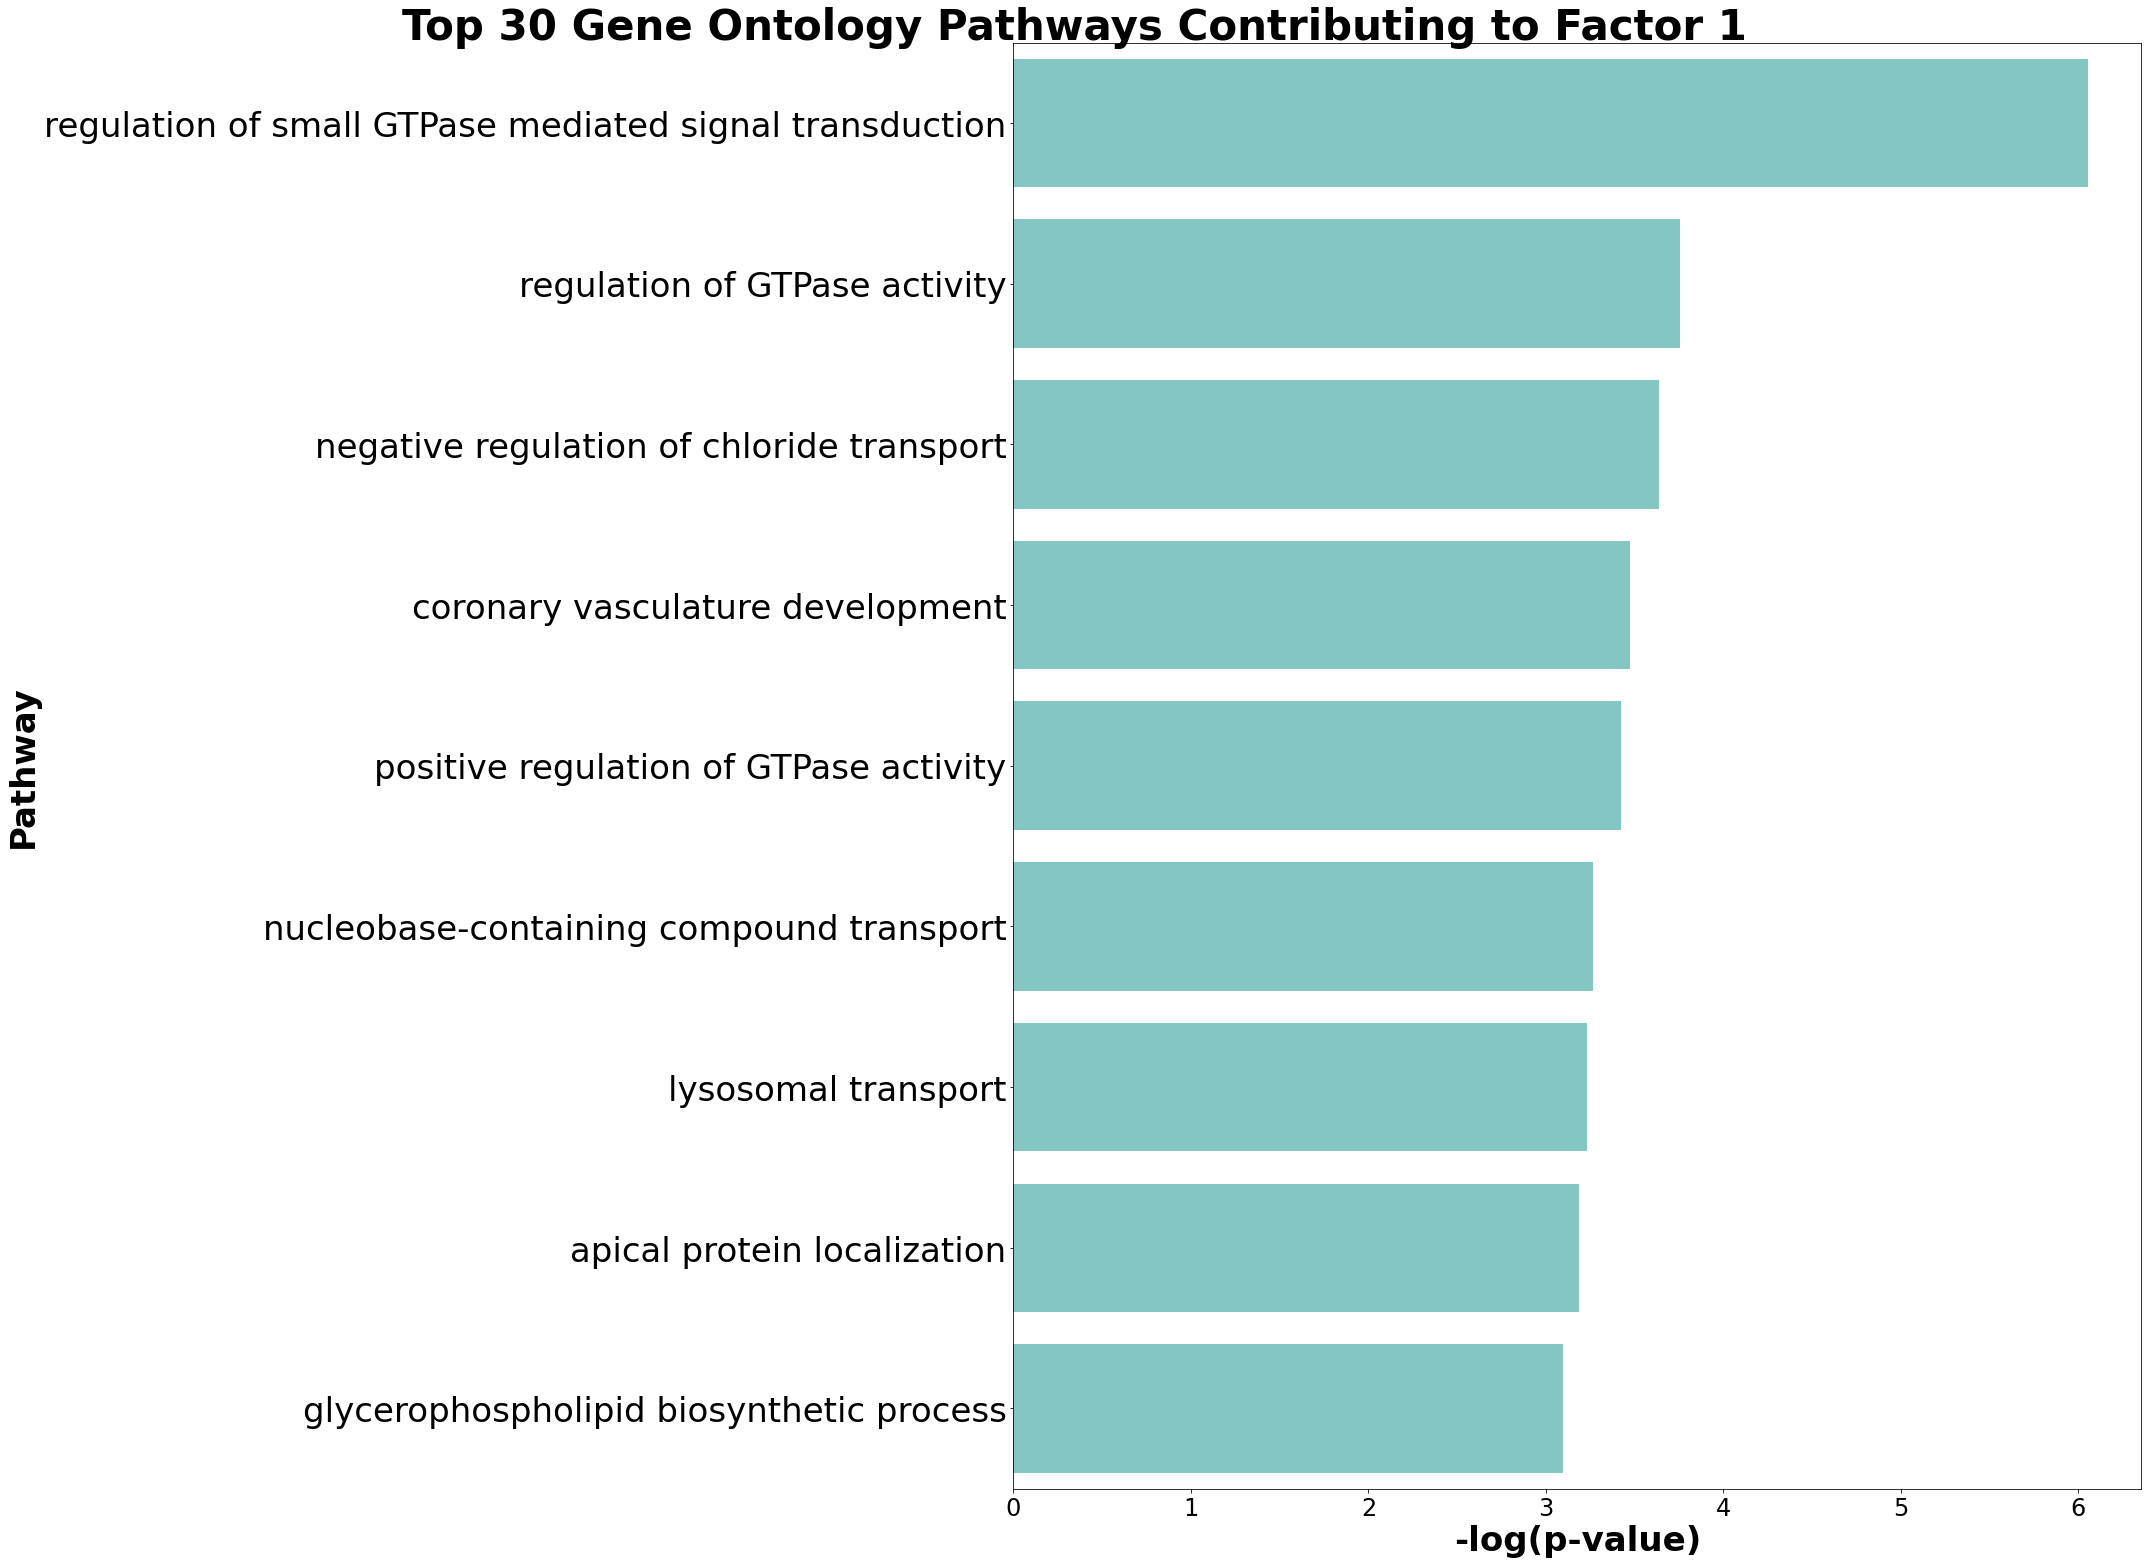

filtered: (30, 11)


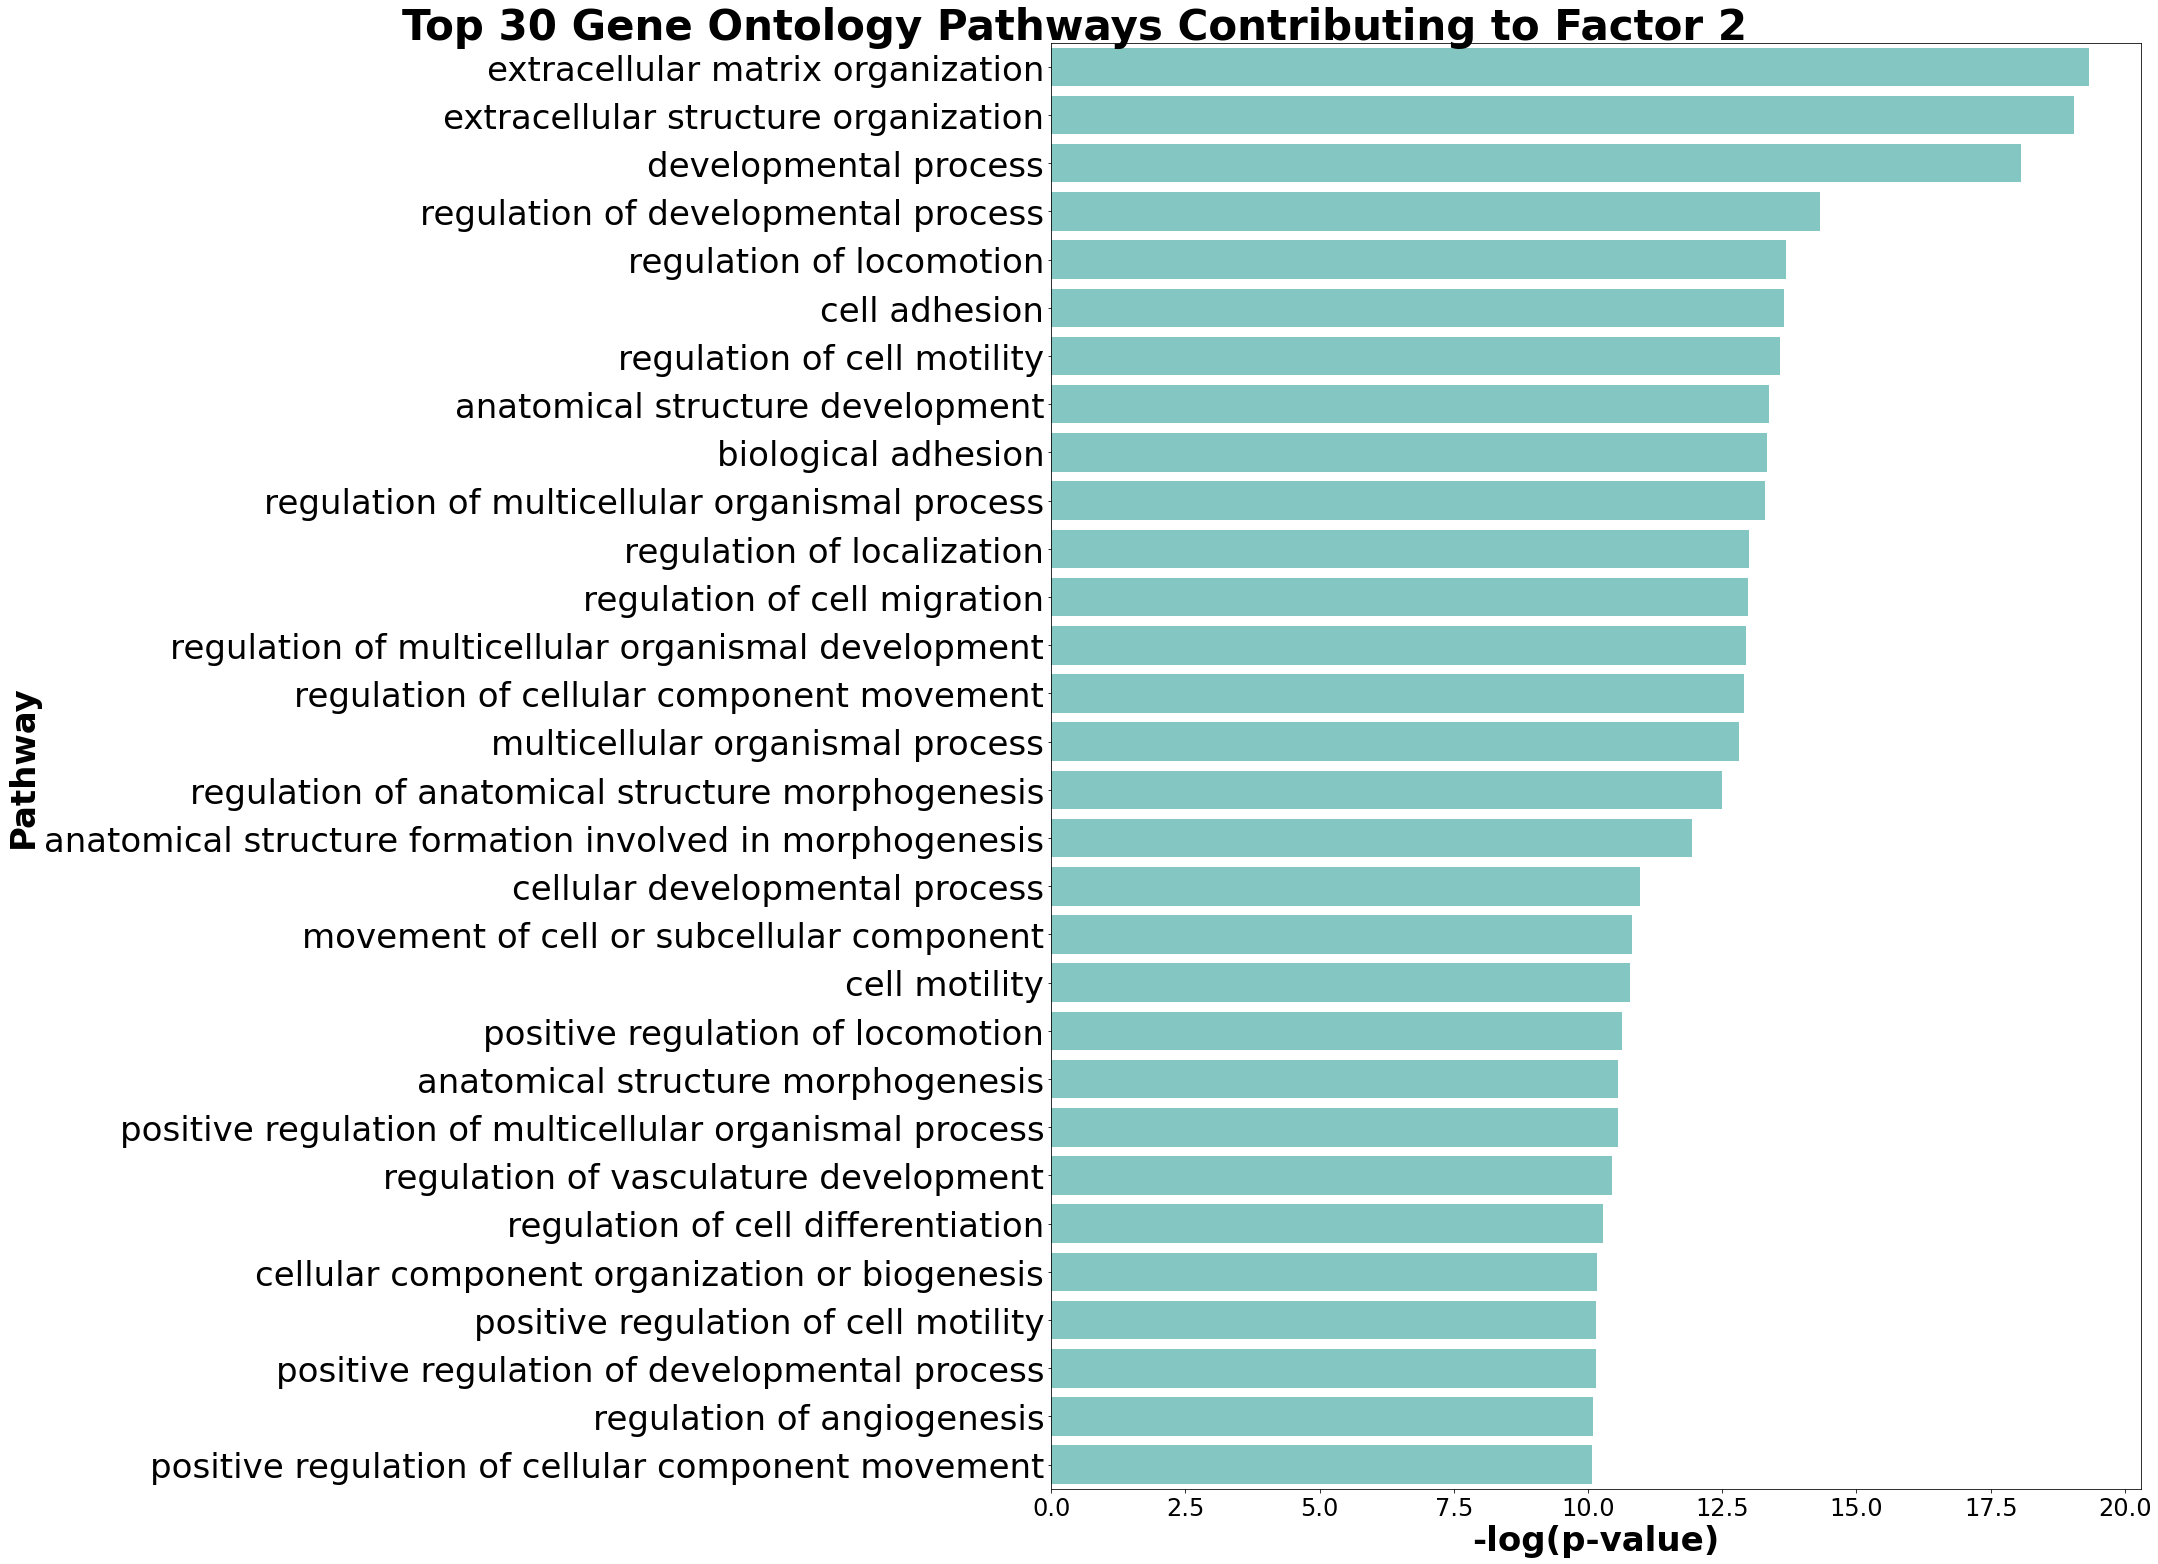

filtered: (30, 11)


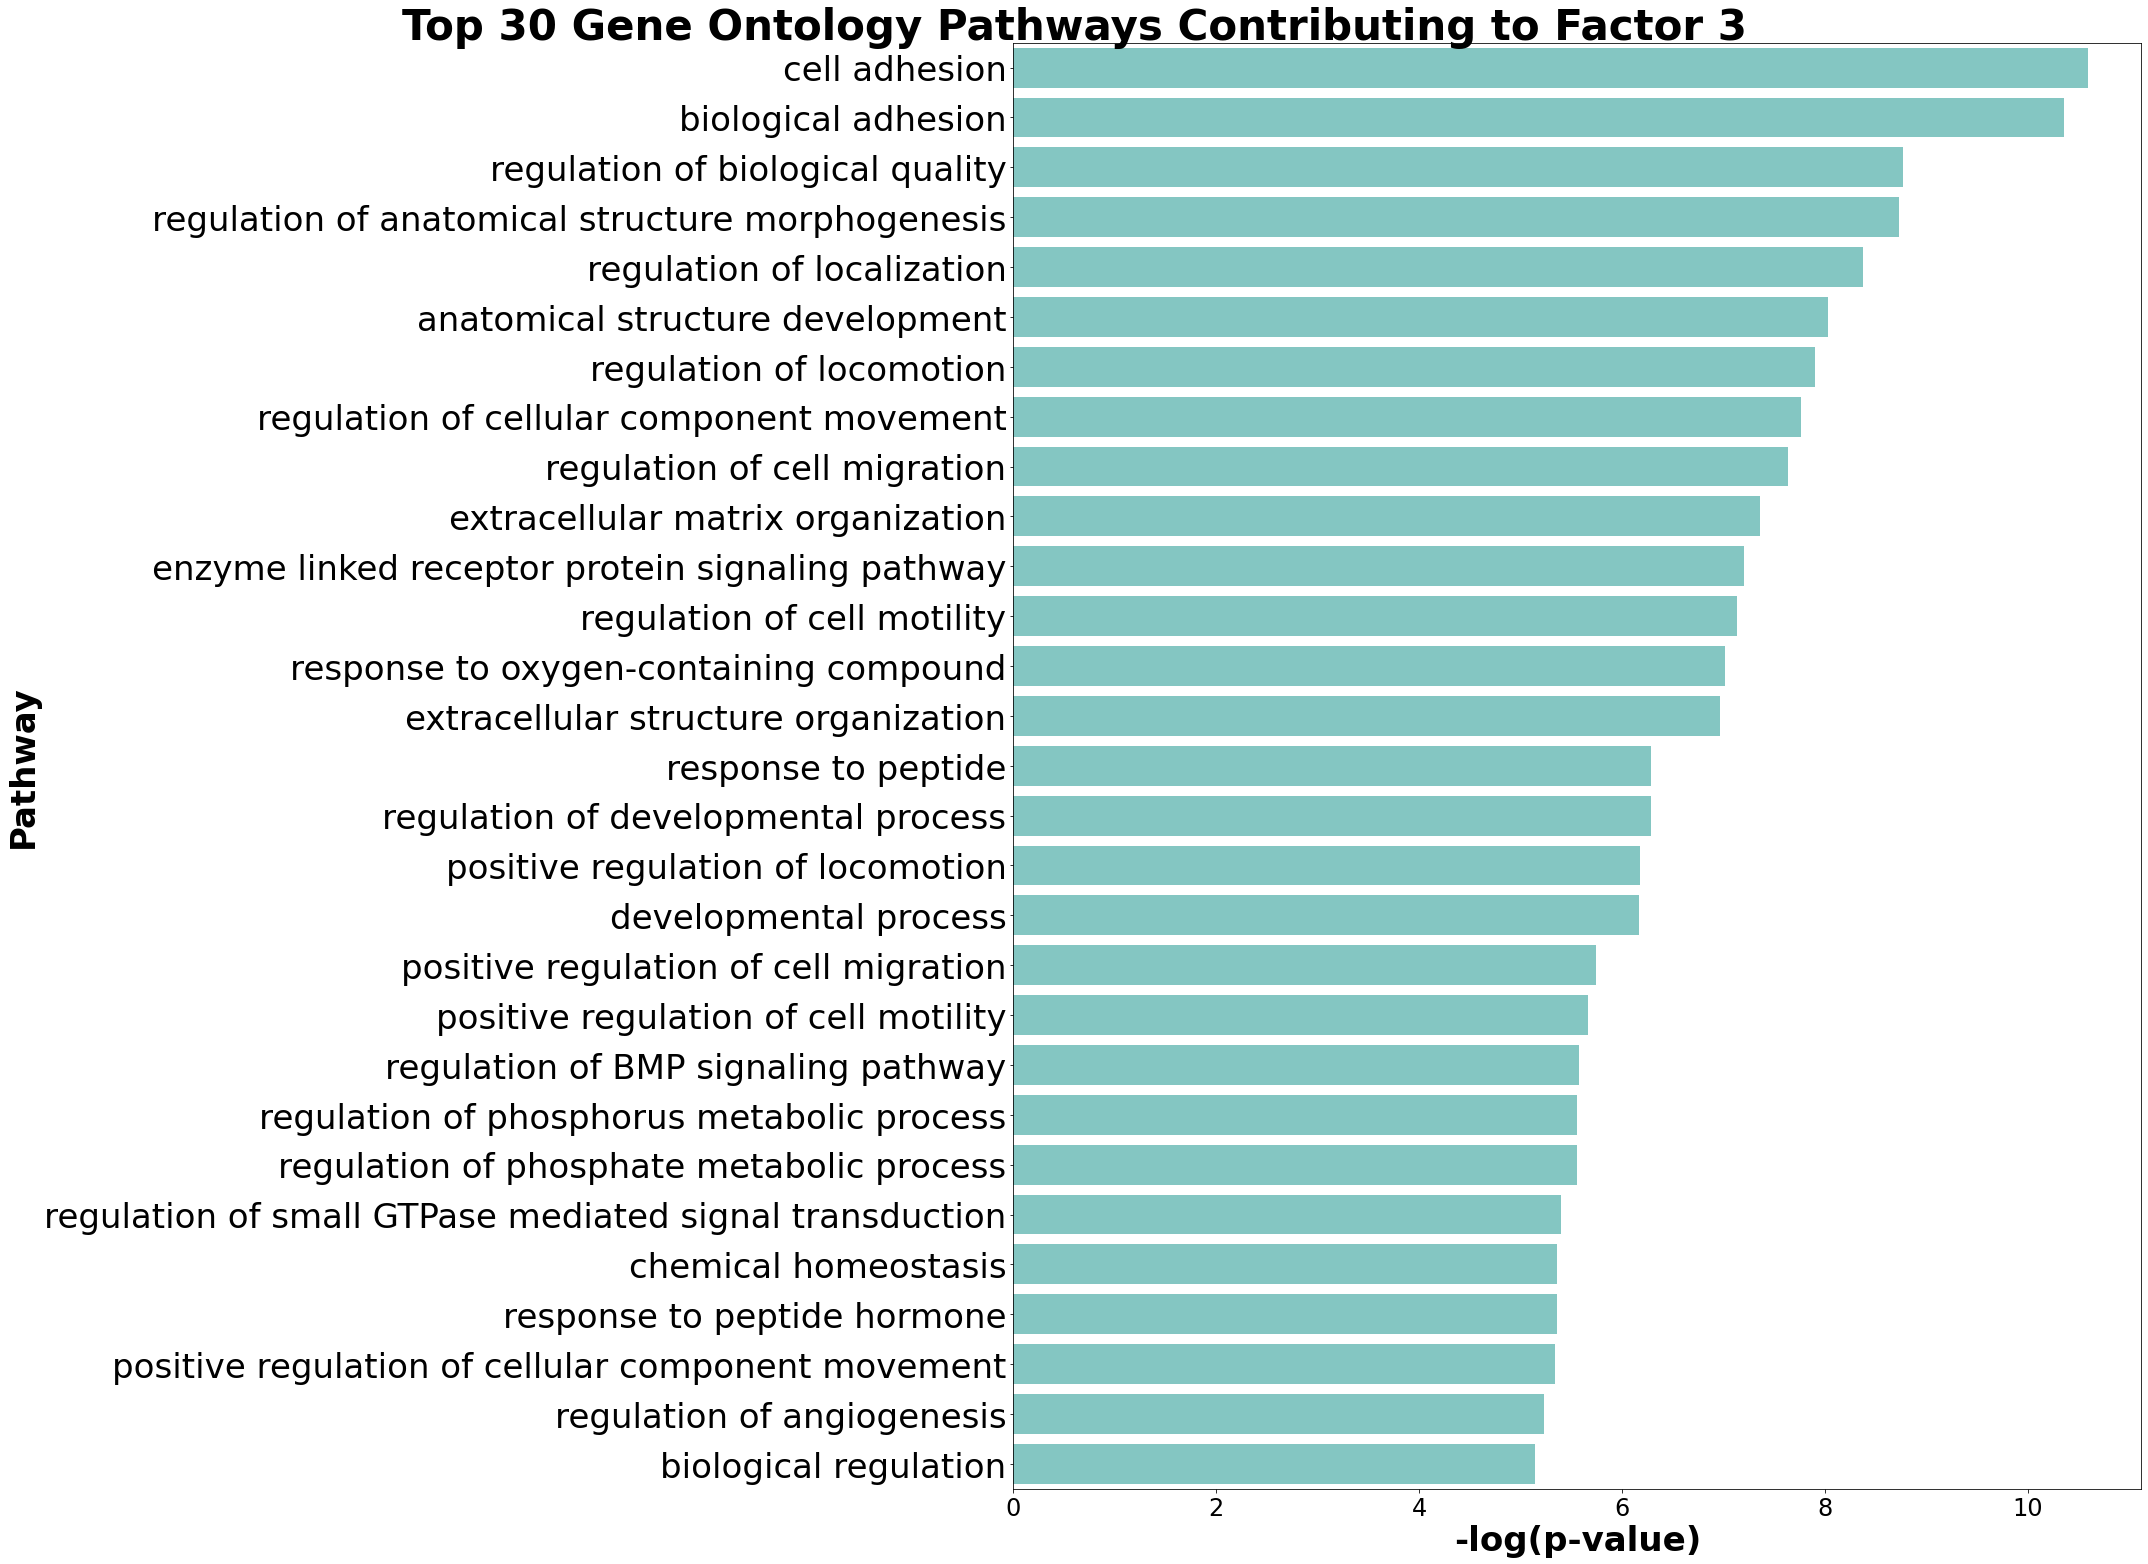

In [85]:
num=0
for sheet_name in sheet_names:
    
    # Reading the Excel sheet into a DataFrame
    pca_name_path = Path(f"{os.getcwd()}/../results/EXP5/", f"GOPROCESS_{added}")
    data = pd.read_excel(pca_name_path, sheet_name = sheet_name)
    data["-logpvalue"] = -np.log10(data["P-value"])
    # Filter the DataFrame for pathways related to adipocyte functions
    # and 'p-value' containing the p-values
    filtered_data = data.loc[0:29]
    print(f"filtered: {filtered_data.shape}")
    # Plotting the data
    num = num+1
    plt.figure(figsize=(30,22))  
    bar_plot = sns.barplot(x='-logpvalue', y='Description', data=filtered_data, color='lightseagreen',alpha=0.6)
    plt.xlabel('-log(p-value)', fontsize=34, fontweight='bold')
    plt.ylabel('Pathway', fontsize=34, fontweight='bold')
    plt.suptitle(f'Top 30 Gene Ontology Pathways Contributing to Factor {sheet_name[-1]}',
               fontname = 'Arial',fontweight='bold', fontsize=42)
    # Set the weight of the y-axis labels to bold
    for label in bar_plot.get_yticklabels():
        label.set_fontsize(34)
    plt.tight_layout()
    plt.xticks(fontsize=24)
    plt.show()